In [1]:
# # (-1) Bootstrap
# import sys, subprocess, site, os

# def pipi(args):
#     subprocess.check_call([sys.executable, "-m", "pip"] + args)

# # 0) keep pip compatible with legacy build flow used by some packages
# pipi(["install", "-q", "pip<25.3"])

# # 1) base stack (pinned)
# pipi(["install", "-q", "--upgrade",
#       "numpy==2.2.6",
#       "pandas==2.3.2",
#       "matplotlib==3.10.6",
#       "scipy==1.16.1",
#       "arch==7.2.0",
#       "joblib==1.5.2",
#       "openpyxl==3.1.5",
#       "xlrd==2.0.2"])

# # 2) py-banshee — wheel-first, then PEP517 fallback
# try:
#     pipi(["install", "-q", "--only-binary=:all:", "py-banshee==1.1.2"])
# except subprocess.CalledProcessError:
#     pipi(["install", "-q", "--use-pep517", "py-banshee==1.1.2"])

# # 3) show environment + versions
# import numpy as np, pandas as pd, matplotlib, scipy, joblib
# try:
#     import arch
#     arch_ver = arch.__version__
# except Exception:
#     arch_ver = "n/a"
# try:
#     import py_banshee as _pb
#     banshee_ver = getattr(_pb, "__version__", "installed")
# except Exception:
#     banshee_ver = "not-importable"
# import openpyxl, xlrd

# print(f"Python: {sys.version.split()[0]}")
# print(f"Kernel: {sys.executable}")
# print(f"CONDA_PREFIX: {os.environ.get('CONDA_PREFIX','(none)')}")
# print("site-packages:")
# for p in site.getsitepackages():
#     print("  -", p)
# print("Note: you may need to restart the kernel to use updated packages.")
# print(f"[VERS] numpy={np.__version__} pandas={pd.__version__} matplotlib={matplotlib.__version__} "
#       f"scipy={scipy.__version__} arch={arch_ver} joblib={joblib.__version__} "
#       f"py-banshee={banshee_ver} openpyxl={openpyxl.__version__} xlrd={xlrd.__version__}")


In [2]:
# (0) Session setup (imports, paths, plotting/theme, helpers)
# Purpose:
#   - Import the scientific stack
#   - Define workspace paths and display prefs
#   - Set global plotting controls (PLOT_YEARS, MARK_YEARS, palette)
#   - Provide plotting helpers (apply_plot_years, mark_years)
#   - Provide core data helpers (index alignment, moving means, tests)

# --- Imports
from pathlib import Path
import io, re, sys, os
from collections.abc import Iterable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple

from scipy.ndimage import convolve1d
from scipy.stats import mannwhitneyu, kruskal, ttest_ind, f_oneway, pearsonr
from IPython.display import display, Markdown

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.prediction import inference
import py_banshee.rankcorr as _banshee_rc

from numpy.lib.stride_tricks import as_strided
from arch.unitroot import ADF as _ARCH_ADF

ROOT = Path(os.environ.get("BCS_ROOT", "")).resolve() if os.environ.get("BCS_ROOT") else None

if ROOT is None:
    cwd = Path.cwd().resolve()
    if cwd.name == "examples" and (cwd.parent / "data").exists():
        ROOT = cwd.parent
    elif (cwd / "data").exists() and (cwd / "examples").exists():
        ROOT = cwd
    else:
        ROOT = cwd.parent

DATA    = ROOT / "data" / "_bogs"
RESULTS = ROOT / "results" / "_bogs"
RESULTS.mkdir(parents=True, exist_ok=True)

# --- Display preferences (optional but handy for diagnostics)
pd.options.display.float_format = "{:.6g}".format

# --- Canonical year axes used across the pipeline
YEARS = np.arange(1701, 2025, dtype=int)        # timeline

# --- Human-readable cohort labels (used in figure titles/legends)
spec_names = ["Birch", "Spruce", "Pine", "Larch"]
loc_names  = ["Control bog", "Dried bog 1", "Dried bog 2"]

# --- Single source of truth for cohort colors (RGB in [0,1])
#     0: Control, 1: Dried 1, 2: Dried 2
C0, C1, C2 = [0.4660, 0.6740, 0.1880], [0.8500, 0.3250, 0.0980], [0.9290, 0.6940, 0.1250]

# --- Global stats settings for per-year tests
TEST  = "ranksum"   # 'ranksum' | 'kruskal' | 'welch' | 'anova'
ALPHA = 0.05        # two-sided

# ==== Global plotting controls (hyperparameters) ====
# 1) Restrict X-axis of plots. None -> no restriction; otherwise (start_year, end_year).
PLOT_YEARS = (1950, 2020)

# 2) Apply PLOT_YEARS also to computation of windows (first_years/last_years)
#    Default False = restrict only plotting (not computations).
APPLY_PLOT_YEARS_TO_WINDOWS = False

# 3) Vertical reference lines shared by plots (e.g., interventions)
MARK_YEARS = (1969, 1989)

# 4) Colors for marked years.
#    Either a single color (str) for all lines OR a tuple/list matching MARK_YEARS length.
#    Here we intentionally re-use our cohort palette so styling stays consistent.
MARK_COLORS = (C1, C2)

BLACK_COLOUR = ([0, 0, 0], [0, 0, 0])

def apply_plot_years(ax, dates):
    """
    If PLOT_YEARS is set, clip the X-axis to the requested year range,
    but keep a tiny padding of 1 year for aesthetics.
    """
    if PLOT_YEARS is None:
        return
    lo, hi = map(int, PLOT_YEARS)
    lo = max(lo, int(dates[0]))
    hi = min(hi, int(dates[-1]))
    if lo <= hi:
        ax.set_xlim(lo - 1, hi + 1)

def mark_years(ax, years, colors=None, linestyle="--", linewidth=2, alpha=0.85):
    """
    Draw vertical dashed lines at x = year.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        Axis to draw on.
    years : int | list[int] | tuple[int]
        Single year or a sequence of years.
    colors : str | list[str] | tuple[str] | None
        Single color or a list of colors (same length as 'years').
        If None, falls back to global MARK_COLORS.
    linestyle : str
        Matplotlib line style (default: dashed).
    linewidth : float
        Line width.
    alpha : float
        Transparency (0..1).
    """
    if years is None:
        return
    if np.isscalar(years):
        years = [int(years)]
    else:
        years = list(map(int, years))

    if colors is None:
        colors = MARK_COLORS

    if isinstance(colors, str):
        colors = [colors] * len(years)
    else:
        colors = list(colors)
        if len(colors) != len(years):
            raise ValueError("Length of 'colors' must match the number of 'years'.")

    for y, c in zip(years, colors):
        ax.axvline(x=y, color=c, linestyle=linestyle, linewidth=linewidth, alpha=alpha)

h0 = Line2D([], [], ls="--", color=C0, marker="o", mfc="none", mec=C0, ms=6, label=loc_names[0])
h1 = Line2D([], [], ls="-.", color=C1, marker="^", mfc="none", mec=C1, ms=6, label=loc_names[1])
h2 = Line2D([], [], ls="-.", color=C2, marker="s", mfc="none", mec=C2, ms=6, label=loc_names[2])

sig = (
    Line2D([], [], ls="None", marker="^", color="b", mfc=C1, mec="b", ms=7),
    Line2D([], [], ls="None", marker="s", color="b", mfc=C2, mec="b", ms=7),
)

# --- IDs to be filled after data load ---
SPEC_IDS: np.ndarray = np.array([], dtype=int)
U_LOC:    np.ndarray = np.array([], dtype=int)

def refresh_ids():
    """
    Fill SPEC_IDS and U_LOC from globals specium/location if they are loaded.
    Safe to call multiple times; does nothing if already filled.
    """
    global SPEC_IDS, U_LOC
    if SPEC_IDS.size == 0 and 'specium' in globals():
        SPEC_IDS = np.sort(np.unique(specium[np.isfinite(specium)])).astype(int)
    if U_LOC.size == 0 and 'location' in globals():
        U_LOC = np.sort(np.unique(location[np.isfinite(location)])).astype(int)

# ==== Notebook / Binder controls ====
# BINDER_SAFE: if True (Binder/JupyterHub), clamp parallelism and use 'threading' backend.
# MAX_JOBS_BINDER: hard cap for Binder-safe runs (typically 2).
# SAVE_OUTPUTS: gate all file writes (figures/CSVs). Keep False on Binder.
BINDER_SAFE        = True
MAX_JOBS_BINDER    = 16
SAVE_OUTPUTS       = False

# ---------- Core helpers (indexing, transforms, summaries) ----------
def pad_to_years(years_src: np.ndarray, X: np.ndarray, years_axis: np.ndarray) -> np.ndarray:
    """Reindex 2D data (rows=years, cols=variables) onto a target year axis; fill gaps by NaN."""
    df = pd.DataFrame(np.asarray(X, float), index=np.asarray(years_src, int))
    return df.reindex(pd.Index(years_axis, name="year")).to_numpy()

def pad_to_years_matrix(dates_src: np.ndarray, M: np.ndarray,
                        start_year: int = 1700, end_year: int = 2024) -> np.ndarray:
    """Wrapper for monthly climate tables (rows=years, cols=Jan..Dec)."""
    axis = np.arange(start_year, end_year + 1, dtype=int)
    return pad_to_years(dates_src, M, axis)

def monthly_to_sep_aug(M: np.ndarray) -> np.ndarray:
    """
    Realign monthly (Jan..Dec) data to hydrological years (Sep..Aug).
    Implementation: vectorize by columns, drop leading 8 and trailing 4 months,
    then reshape back, so col1=Sep and col12=Aug.
    """
    M = np.asarray(M, float)
    assert M.ndim == 2 and M.shape[1] == 12, "Expected (years × 12) table"
    vec = M.T.flatten(order="F")
    vec = vec[8:-4]  # remove Jan..Aug of first and Sep..Dec of last hydrological year
    assert vec.size % 12 == 0, "Vector length must be divisible by 12 after trimming"
    return np.reshape(vec, (12, -1), order="F").T  # (T × 12), cols=Sep..Aug

def zscore_cols(M: np.ndarray, ddof: int = 1) -> np.ndarray:
    """Column-wise standardization: (X - mean) / std per column (sample std with ddof=1)."""
    M = np.asarray(M, float)
    mu = np.nanmean(M, axis=0)
    sd = np.nanstd(M, axis=0, ddof=ddof)
    sd = np.where(sd == 0, np.nan, sd)
    return (M - mu) / sd

def movmean_rows_center_includenan(M: np.ndarray, k: int = 3) -> np.ndarray:
    """
    Centered moving average over rows with strict NaN propagation.
    A window yields a value only if all k entries are present; edges shrink.
    """
    assert M.ndim == 2
    R, C = M.shape
    ker = np.ones(k, dtype=float)
    X = M.copy()
    nanmask = np.isnan(X)
    X[nanmask] = 0.0
    sum_vals = convolve1d(X, ker, axis=0, mode="constant", cval=0.0, origin=0)
    count    = convolve1d((~nanmask).astype(float), ker, axis=0, mode="constant", cval=0.0, origin=0)
    maxcnt   = np.broadcast_to(convolve1d(np.ones((R, 1)), ker, axis=0, mode="constant", cval=0.0, origin=0), (R, C))
    out = np.full((R, C), np.nan, dtype=float)
    full = (count == maxcnt)
    out[full] = (sum_vals[full] / maxcnt[full])
    return out

def row_nanmean(X: np.ndarray) -> np.ndarray:
    """Row-wise mean with NaN omission; returns NaN for rows with no finite values."""
    X = np.asarray(X, float)
    s = np.nansum(X, axis=1)
    c = np.sum(~np.isnan(X), axis=1)
    out = np.full(X.shape[0], np.nan)
    np.divide(s, c, out=out, where=c > 0)
    return out

def safe_nanmean(A):
    """Scalar NaN-mean: returns np.nan if all-NaN."""
    A = np.asarray(A, float); m = np.isfinite(A)
    return float(A[m].mean()) if m.any() else np.nan

def nanmean_axis_safe(X, axis):
    """Axis-wise mean with NaN omission (shape follows np.nansum)."""
    X = np.asarray(X, float)
    cnt = np.sum(np.isfinite(X), axis=axis)
    sm  = np.nansum(X, axis=axis)
    out = np.full(sm.shape, np.nan)
    np.divide(sm, cnt, out=out, where=cnt > 0)
    return out

# ---------- Per-year two-sample tests ----------
# Listwise year-by-year testing policy:
#   - Compute a p-value only if both cohorts have ≥1 finite observation at that year.
#   - Otherwise return NaN (explicitly avoids imputing structure).
#   - TEST ∈ {'ranksum','kruskal','welch','anova'} controls the test family globally.
def pval_two_group(x0: np.ndarray, x1: np.ndarray, method: str = "ranksum") -> float:
    """
    Two-sample p-value for independent groups (two-sided). NaNs must be removed upstream.
    Methods: 'ranksum' (Mann–Whitney U), 'kruskal', 'welch' (unequal variances), 'anova'.
    """
    n0, n1 = x0.size, x1.size
    if method == "ranksum":
        return mannwhitneyu(x0, x1, alternative="two-sided", method="auto", use_continuity=True).pvalue
    elif method == "kruskal":
        return kruskal(x0, x1, nan_policy="omit").pvalue
    elif method == "welch":
        return ttest_ind(x0, x1, equal_var=False).pvalue if (n0 >= 2 and n1 >= 2) else np.nan
    elif method == "anova":
        return f_oneway(x0, x1).pvalue if (n0 >= 2 and n1 >= 2) else np.nan
    else:
        raise ValueError("method ∈ {'ranksum','kruskal','welch','anova'}")

def pvals_by_year(data: np.ndarray, sel0: np.ndarray, sel1: np.ndarray,
                  dates: np.ndarray, method: str = "ranksum") -> np.ndarray:
    """Per-year p-values: computed only where both cohorts have ≥1 non-NaN observation; else NaN."""
    T = len(dates)
    pvals = np.full(T, np.nan)
    for t in range(T):
        x0 = data[t, sel0]; x1 = data[t, sel1]
        m0 = ~np.isnan(x0);  m1 = ~np.isnan(x1)
        if m0.any() and m1.any():
            pvals[t] = pval_two_group(x0[m0], x1[m1], method=method)
    return pvals

# Pearson correlation with strict listwise deletion:
#   Returns NaN unless there are at least 2 joint finite samples.
#   Centers both vectors and guards against zero variance.
def corr_1d_pairwise(x: np.ndarray, y: np.ndarray) -> float:
    """Listwise Pearson correlation between two 1D arrays; NaN if <2 joint finite samples."""
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 2:
        return np.nan
    x0 = x[m] - np.nanmean(x[m])
    y0 = y[m] - np.nanmean(y[m])
    den = np.sqrt(np.dot(x0, x0) * np.dot(y0, y0))
    return float(np.dot(x0, y0) / den) if den > 0 else np.nan


In [3]:
# (*) Diagnostics helper
# --- PURPOSE: light-weight matrix/vector diagnostics
# Notes for readers (methods context):
#   This helper is used throughout to sanity-check shapes, NaN coverage, and quick heads/tails.
#   Keeping diagnostics visible improves reproducibility and auditability of the pipeline.

def diag_print(name: str, X, cols: int = 3) -> None:
    """
    Print concise diagnostics about an array-like object.

    Parameters
    ----------
    name : str
        Label printed in the header.
    X : array-like
        Vector or matrix to inspect.
    cols : int, default=3
        Number of leading columns to preview for 2D arrays.
    """
    X = np.asarray(X)
    print(f"=== [DIAG] {name} ===")
    print(f"shape = {X.shape}")
    nans = int(np.isnan(X).sum()) if np.issubdtype(X.dtype, np.floating) else 0
    vals = X.size - nans
    pct  = (100 * nans / X.size) if X.size else 0.0
    print(f"NaN = {nans}, non-NaN = {vals} (NaN% = {pct:.2f})")
    if X.ndim == 1:
        h = X[:3]; t = X[-3:] if X.size >= 3 else X
        print("head:", h)
        print("tail:", t)
    elif X.ndim >= 2:
        r = slice(0, min(3, X.shape[0]))
        rr = slice(max(0, X.shape[0]-3), X.shape[0])
        c = slice(0, min(cols, X.shape[1]))
        print("head (first 3 rows, first 3 cols):\n", X[r, c])
        print("tail (last 3 rows, first 3 cols):\n", X[rr, c])


In [4]:
# (1) Load individual TRW and cohort labels → align to canonical year axis
# --- INPUT:  TRW_Chronology.xlsx
# --- OUTPUT: cohort labels (species/colony), location labels, dates (T,), data (T×N), N_trees
# Rationale:
#   Load per-tree TRW series and cohort metadata. Promote the year column to a canonical
#   timeline (YEARS) and reindex with NaN padding. Keep raw per-tree values; no detrending.

tbl1 = pd.read_excel(DATA / "TRW_Chronology.xlsx", header=None)

# Metadata rows
specium   = tbl1.iloc[0, 1:].to_numpy(dtype=float)
location  = tbl1.iloc[1, 1:].to_numpy(dtype=float)

# Raw time axis + TRW
dates_src = tbl1.iloc[3:, 0].to_numpy(dtype=int)
data_src  = tbl1.iloc[3:, 1:].to_numpy(dtype=float)

# Reindex
data  = pad_to_years(dates_src, data_src, YEARS)
dates = YEARS.copy()
N_trees = data.shape[1]

# [DIAG]
# diag_print("TRW data", data)
# print(f"[DIAG] years: {dates[0]}..{dates[-1]} (T={len(dates)}), N_trees={N_trees}")
# diag_print("specium(row1)", specium[None, :])
# diag_print("location(row2)", location[None, :])


In [5]:
# (2) PDSI ingestion (monthly) → hydrological years (Sep–Aug); pad & realign
# --- INPUT:  monthly PDSI file (Jan..Dec)
# --- OUTPUT: PDSI (T×12, Sep..Aug)
# Rationale:
#   Read monthly PDSI, pad its year index to the TRW domain, and realign to hydrological
#   years (Sep..Aug) to capture late-season carry-over. Preserve the monthly structure
#   for multi-year lag stacking downstream.

tbl3 = pd.read_csv(
    DATA / "iscpdsi_60.3E_56.9N_firstyear-lastyear_n.dat.txt",
    sep=r"\s+", header=None, engine="python"
)
dates3_raw = tbl3.iloc[:, 0].to_numpy(int)
PDSI_mon   = tbl3.iloc[:, 1:13].to_numpy(float)

PDSI_pad = pad_to_years_matrix(dates3_raw, PDSI_mon, start_year=1700, end_year=2024)
PDSI     = monthly_to_sep_aug(PDSI_pad)            # (T × 12), cols = Sep..Aug

# [DIAG]
# diag_print("PDSI monthly Sep–Aug", PDSI)
# print(f"[DIAG] PDSI years after shift: T={PDSI.shape[0]}")


In [6]:
# (3) Temperature ingestion → hydrological years (Sep–Aug); pad & realign
# --- INPUT:  legacy .xls with Year + 12 months
# --- OUTPUT: Temp (T×12, Sep–Aug)
# Rationale:
#   Parse the legacy sheet (no headers), detect/use the Year column and the 12 monthly columns,
#   pad to the TRW domain, then realign to Sep–Aug.

raw = pd.read_excel(DATA / "Meteo_Ekb.xls", sheet_name=0, header=None, engine="xlrd")

# Find a plausible year column
def _find_year_col(df: pd.DataFrame) -> int:
    for j in range(df.shape[1]):
        s = pd.to_numeric(df.iloc[:, j], errors="coerce")
        ok = s.between(1700, 2100) & (np.floor(s) == s)
        if ok.sum() >= 10:
            return j
    raise ValueError("Cannot find a plausible year column in Meteo_Ekb.xls")

jY = _find_year_col(raw)
years_col = pd.to_numeric(raw.iloc[:, jY], errors="coerce")
r0 = years_col[years_col.between(1700, 2100) & (np.floor(years_col) == years_col)].index.min()
assert np.isfinite(r0), "No year rows found in Meteo_Ekb.xls"

yrs = pd.to_numeric(raw.iloc[r0:, jY], errors="coerce")
assert jY + 12 < raw.shape[1], "Not enough columns for 12 months after year col"

mon = raw.iloc[r0:, jY+1:jY+13].apply(pd.to_numeric, errors="coerce")
mon = mon.mask(mon >= 900, np.nan)  # treat 999/999.9 etc. as NaN

valid = yrs.between(1700, 2024) & (np.floor(yrs) == yrs)
years_valid = yrs[valid].astype(int).to_numpy()
Temp_mon    = mon[valid].to_numpy(float)  # Jan..Dec

Temp_pad = pad_to_years_matrix(years_valid, Temp_mon, start_year=1700, end_year=2024)
Temp     = monthly_to_sep_aug(Temp_pad)

# [DIAG]
# diag_print("Temp monthly Sep–Aug", Temp)
# print(f"[DIAG] Temp years after shift: T={Temp.shape[0]}")


In [7]:
# (4) Multi-year monthly lag stacks (5×12) for climate predictors
# --- INPUT:  PDSI (T×12), Temp (T×12)
# --- OUTPUT: data_seasonal_* (T×20), stats0 (T×20), data1 (T×21×N)
# Rationale:
#   For each climate table, concatenate the current hydrological year and 4 previous years
#   (lags 0..4) to form a 60-column predictor block per time step (top-padded with NaNs).

#   Seasonal smoothing → 10+10 features; standardize and pack predictors

#   Apply centered 3-month smoothing with strict NaN propagation to the 60-cols stacks,
#   keep the central month of each triplet → 20 seasonal features. Z-score columns (ddof=1)
#   after smoothing, then horizontally stack 10 PDSI + 10 Temp into stats0. Broadcast stats0
#   across trees and append the TRW channel to obtain data1.

def multi_year_monthly_blocks(M: np.ndarray, max_lag: int = 4) -> np.ndarray:
    """5-year lag stack: (T×60) = [lag4 | lag3 | lag2 | lag1 | lag0], each block 12 months."""
    M = np.asarray(M, float)
    T = M.shape[0]
    blocks = []
    for lag in (4, 3, 2, 1, 0):
        if lag > 0:
            blk = np.vstack([np.full((lag, 12), np.nan), M[:T-lag, :]])
        else:
            blk = M.copy()
        blocks.append(blk)
    return np.hstack(blocks)

# Monthly lag stacks (T x 60)
data_multi_year_PDSI = multi_year_monthly_blocks(PDSI, 4)
data_multi_year_Temp = multi_year_monthly_blocks(Temp,  4)

# Seasonal smoothing (centered 3-month window), keep central month of each triplet
#     Strict NaN propagation: use the helper defined earlier in your notebook.
sm_pdsi = movmean_rows_center_includenan(data_multi_year_PDSI.T, k=3).T
sm_temp = movmean_rows_center_includenan(data_multi_year_Temp.T, k=3).T
data_seasonal_PDSI = sm_pdsi[:, 1::3]   # -> (T x 20)
data_seasonal_Temp = sm_temp[:, 1::3]   # -> (T x 20)

# Final per-column standardization AFTER the seasonal step
data_seasonal_PDSI = zscore_cols(data_seasonal_PDSI, ddof=1)
data_seasonal_Temp = zscore_cols(data_seasonal_Temp, ddof=1)

# Exactly the same 10+10 features: PDSI(11..20) + Temp(11..20)
stats0 = np.hstack([data_seasonal_PDSI[:, 10:20], data_seasonal_Temp[:, 10:20],])  # (T x 20)

# We construct climate predictors once and keep them fixed across all downstream analyses.
# Steps:
#   1) Build 5 hydrological years (Sep–Aug) of monthly data per time step: 12×5 = 60 months,
#        arranged as [lag4 | lag3 | lag2 | lag1 | lag0], top-padded with NaNs to preserve alignment.
#   2) Apply centered 3-month smoothing with strict NaN propagation over the 60-month stack.
#   3) Keep each triplet’s central month → 20 “seasonal” features per climate table.
#   4) Standardize columns (ddof=1) AFTER the seasonal step.
# Selection policy:
#   • We retain the last 10 seasonal features (columns 11..20) from each table, which summarize
#     the most recent ~2.5 hydrological years (higher signal-to-noise for attribution while still
#     allowing short memory of the past).
#   • Columns from PDSI and Temperature are concatenated in a fixed order to form `stats0` (T×20).
# NPBN usage:
#   • `stats0` is the ONLY climate input consumed by the NPBN steps (trend and fluctuation targets).
#   • We do NOT whiten/orthogonalize these predictors: NPBN works in rank space and can accommodate
#     correlated inputs via the learned triangular parent structure. This keeps the construction
#     transparent and reproducible, avoids target-aware feature engineering, and prevents leakage.
# Reproducibility guardrails:
#   • Do not reorder or rename columns in `stats0`; downstream NPBN code assumes this layout.
#   • Standardization happens after seasonal smoothing (changing this affects scales and comparability).

# Pack into (T x 21 x N_trees): 20 climate + 1 TRW channel
stats0_3d = np.repeat(stats0[:, :, None], N_trees, axis=2)
data1     = np.concatenate([stats0_3d, data[:, None, :]], axis=1)

# [DIAG]
# diag_print('data_multi_year_PDSI (T x 60)', data_multi_year_PDSI)
# diag_print('data_multi_year_Temp (T x 60)', data_multi_year_Temp)
# diag_print('data_seasonal_PDSI (T x 20)', data_seasonal_PDSI)
# diag_print('data_seasonal_Temp (T x 20)', data_seasonal_Temp)
# diag_print('stats0 (T x 20)', stats0)
# print(f"[DIAG] data1 size = {data1.shape[0]}x{data1.shape[1]}x{data1.shape[2]}")


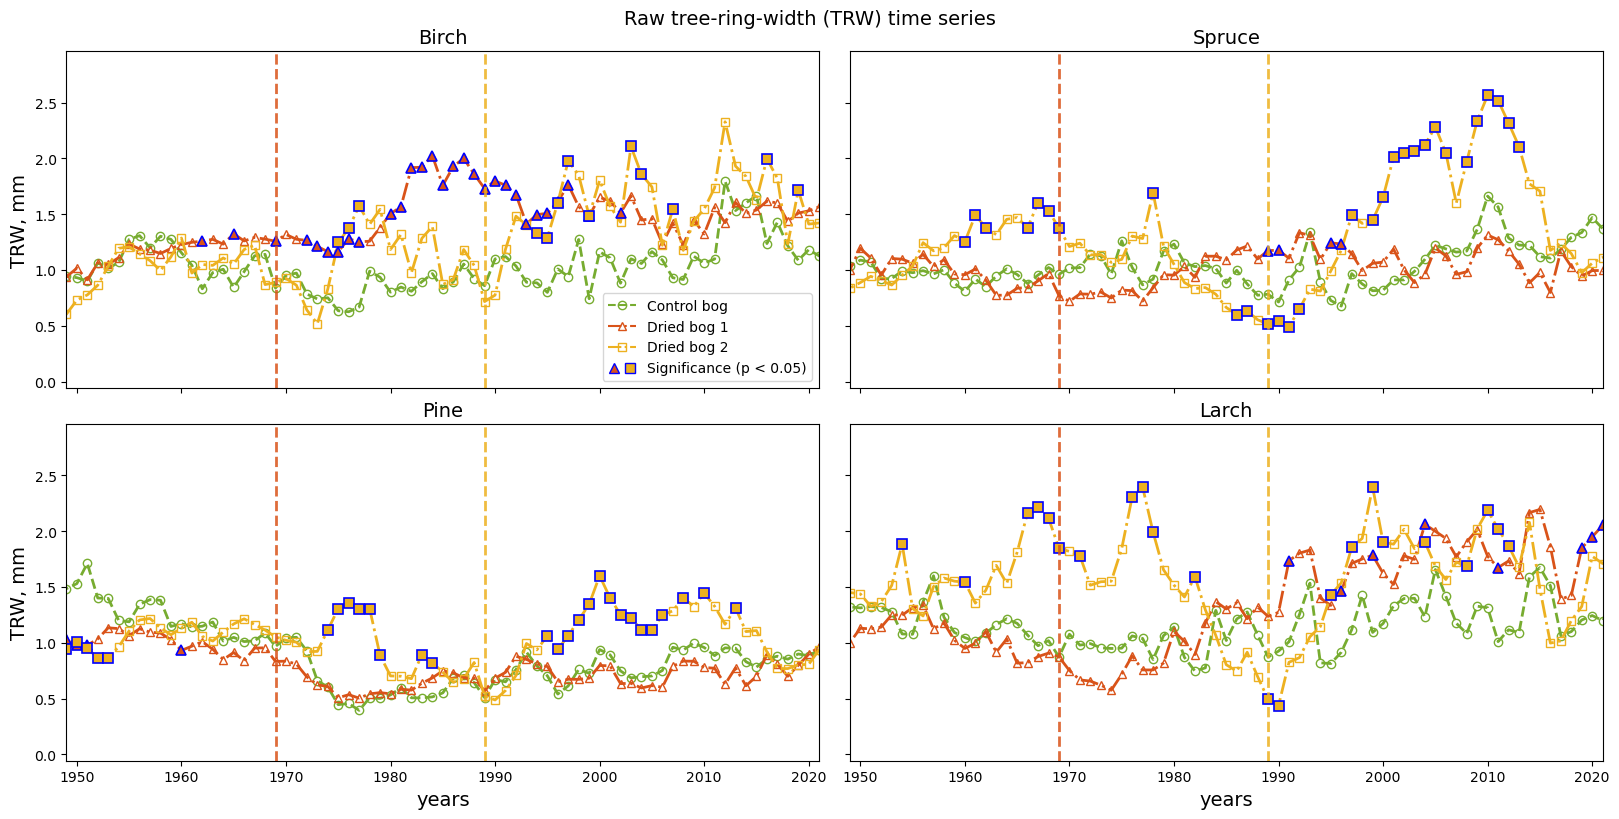

In [8]:
# (5) Raw TRW time series — cohort means with per-year significance overlays
# --- INPUT:  data (T×N), dates (T,), cohort labels, location labels
# --- OUTPUT: Figure_1.pdf, TRW_1.csv
# Rationale:
#   Compute cohort means (row-wise NaN-means) and test per-year differences vs the reference
#   cohort using the selected two-sample test (TEST). Overlay significant years and share axes
#   across panels for comparability.

T = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

refresh_ids()

for ax, sp in zip(axes, SPEC_IDS):
    sel0 = (specium == sp) & (location == 1)  # Control bog
    sel1 = (specium == sp) & (location == 2)  # Dried bog 1
    sel2 = (specium == sp) & (location == 3)  # Dried bog 2

    y0 = row_nanmean(data[:, sel0]) if sel0.any() else np.full(T, np.nan)
    y1 = row_nanmean(data[:, sel1]) if sel1.any() else np.full(T, np.nan)
    y2 = row_nanmean(data[:, sel2]) if sel2.any() else np.full(T, np.nan)

    # Per-year tests (Control vs Dried1, Control vs Dried2)
    P1 = pvals_by_year(data, sel0, sel1, dates, method=TEST)
    P2 = pvals_by_year(data, sel0, sel2, dates, method=TEST)
    sig1 = np.isfinite(P1) & (P1 < ALPHA)
    sig2 = np.isfinite(P2) & (P2 < ALPHA)

    # Mean curves (o/^/s; unfilled markers on curves)
    ax.plot(dates, y0, linestyle='--', linewidth=2, color=C0,
            marker='o', markersize=6, markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])
    ax.plot(dates, y1, linestyle='-.', linewidth=2, color=C1,
            marker='^', markersize=6, markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])
    ax.plot(dates, y2, linestyle='-.', linewidth=2, color=C2,
            marker='s', markersize=6, markerfacecolor='none', markeredgecolor=C2, label=loc_names[2])

    # Significance overlays (unfilled blue shapes)
    y1_sig = y1.copy(); y1_sig[~sig1] = np.nan
    ax.plot(dates, y1_sig, linestyle='None', marker='^', markersize=7,
            markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2)
    y2_sig = y2.copy(); y2_sig[~sig2] = np.nan
    ax.plot(dates, y2_sig, linestyle='None', marker='s', markersize=7,
            markerfacecolor=C2, markeredgecolor='b', markeredgewidth=1.2)

    mark_years(ax, MARK_YEARS, MARK_COLORS)
    if PLOT_YEARS is not None:
        apply_plot_years(ax, dates)

    title = spec_names[sp-1] if (sp-1) < len(spec_names) else f"Species {sp}"
    ax.set_title(title, fontsize=14);
    if (list(SPEC_IDS).index(sp) % 2) == 0:
        ax.set_ylabel('TRW, mm', fontsize=14)
    if (list(SPEC_IDS).index(sp) // 2) == 1:
        ax.set_xlabel("years", fontsize=14)
    # ax.legend(loc='upper left')
    # [DIAG]
    # sig1_cnt = int(np.nansum(sig1)); sig2_cnt = int(np.nansum(sig2))
    # print(f"[DIAG] Species {sp}: nC={sel0.sum()}, nD1={sel1.sum()}, nD2={sel2.sum()}, "
    #       f"sig(C vs D1)={sig1_cnt}, sig(C vs D2)={sig2_cnt} (TEST={TEST}, ALPHA={ALPHA})")

fig.suptitle('Raw tree-ring-width (TRW) time series', fontsize=14)
axes[0].legend([h0, h1, h2, sig],
               [loc_names[0], loc_names[1], loc_names[2], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)},
               loc="best")
if SAVE_OUTPUTS:
    fig.savefig(RESULTS / "Figure_1.pdf", format="pdf")
    pd.DataFrame(data).to_csv(RESULTS / "TRW_1.csv", index=False, header=False)
plt.show()


_HAVE_JOBLIB = True
_JOBS = 2, _BACKEND = 'threading', BINDER_SAFE = True
S-grid = [11..50], Sd = 47


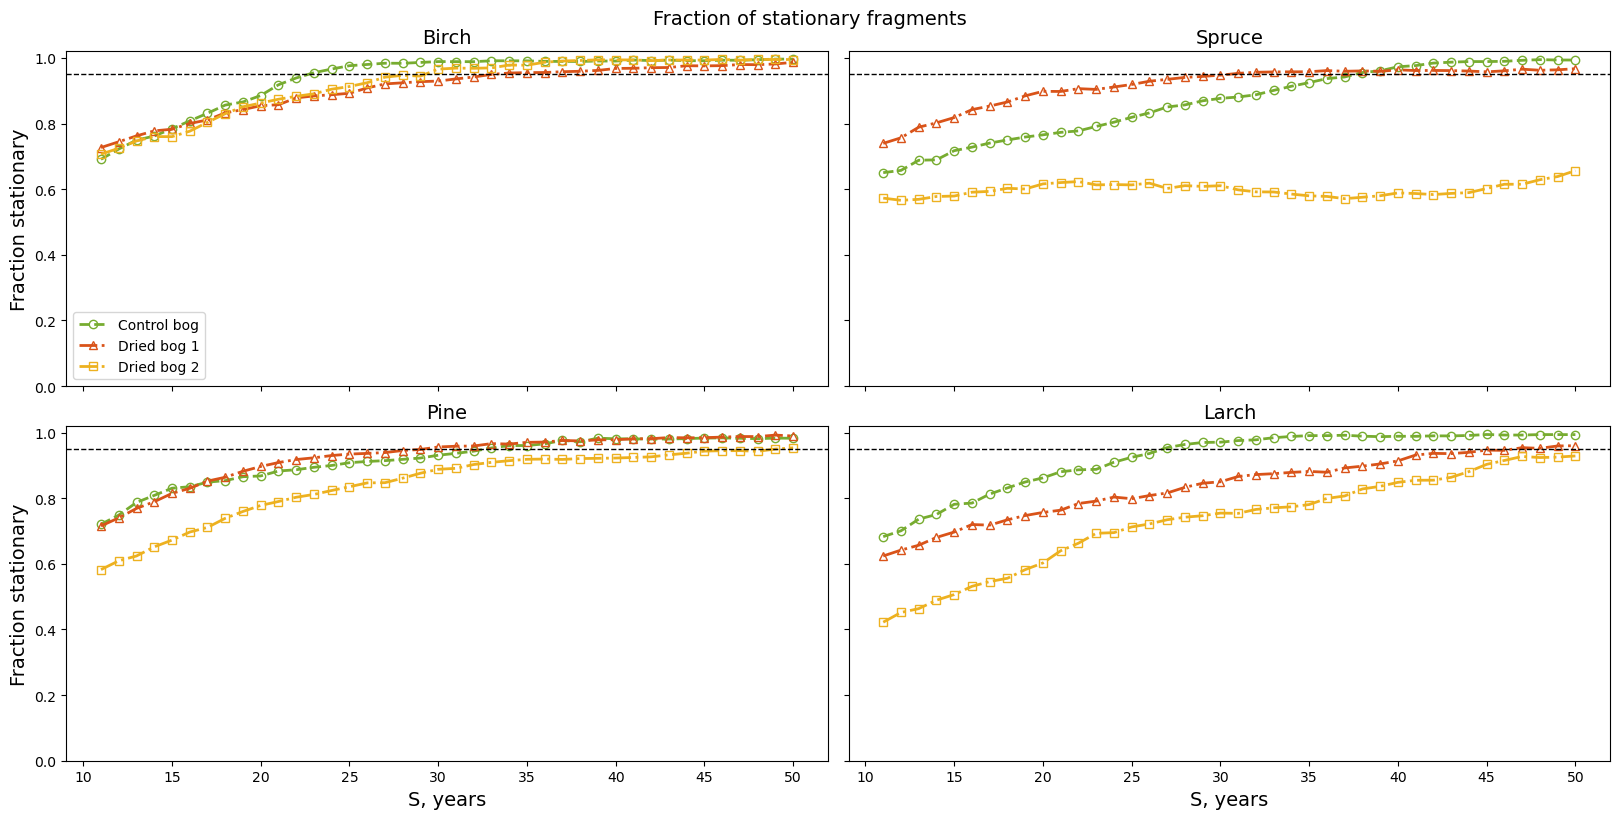

In [9]:
# (6) Decomposition into long-term trend & stationary fluctuations + ADF stationarity grid
# --- INPUT:  data (T×N), dates (T,), cohort labels
# --- OUTPUT: data_trend (T×N), data_fluct (T×N), ADF_3d (T×N×|S|), Sd, Figure_2.pdf
# Rationale:
#   For S∈{11..50} compute k-year centered moving-mean trends and residual fluctuations.
#   Partition residuals into non-overlapping S-blocks across all phase offsets and assess
#   stationarity with the Augmented Dickey–Fuller test. Pick Sd as the smallest S with mean
#   stationary coverage > THRESHOLD (or argmax otherwise). Visualize coverage by cohort.

# ---------- Parameters ----------
S             = np.arange(11, 51)
ADF_ALPHA     = 0.05
ADF_MODEL     = 'AR'     # 'AR' (no const), 'ARD' (const), 'TS' (const+trend)
ADF_LAGS      = 0
NAN_POLICY    = 'strict' # skip blocks with NaNs
THRESHOLD     = 0.95
VAR_EPS       = 1e-12
ADF_DECISION  = 'crit'   # 'crit'|'pvalue'|'auto'

try:
    from joblib import Parallel, delayed
    _HAVE_JOBLIB = True
except Exception:
    _HAVE_JOBLIB = False

print(f"_HAVE_JOBLIB = {_HAVE_JOBLIB}")

_TREND_MAP = {'AR': 'n', 'ARD': 'c', 'TS': 'ct'}

# Binder/local job & backend selection (uses globals from Block 0)
def _effective_jobs():
    host = max(1, (os.cpu_count() or 2) - 1)  # all logical CPUs minus one
    return min(MAX_JOBS_BINDER, host) if BINDER_SAFE else host

_BACKEND = 'threading' if BINDER_SAFE else 'loky'
_JOBS    = _effective_jobs()
print(f"_HAVE_JOBLIB = {_HAVE_JOBLIB}, _JOBS = {_JOBS}, _BACKEND = '{_BACKEND}', BINDER_SAFE = {BINDER_SAFE}")

# ADF wrapper (arch.unitroot.ADF) with NaN/variance guards:
#   - 'strict' policy skips any block containing NaNs; 'omit' drops NaNs column-wise.
#   - If variance ≤ VAR_EPS, treat as stationary (degenerate) to avoid numerical issues.
#   - Decision by 'crit' uses the 5% critical value; 'pvalue' uses reported p-value.
def adf_arch(y: np.ndarray, model='AR', lags=0, alpha=0.05,
             nan_policy='strict', decision='auto'):
    """ADF wrapper over arch.unitroot; returns (h, p) with NaN-safe guards."""
    y = np.asarray(y, float)
    if nan_policy == 'strict' and np.isnan(y).any(): return np.nan, np.nan
    if nan_policy == 'omit': y = y[np.isfinite(y)]
    if y.size < 3: return np.nan, np.nan
    if np.nanvar(y) <= VAR_EPS: return 1.0, 0.0
    try:
        res  = _ARCH_ADF(y, lags=int(lags), trend=_TREND_MAP.get(model.upper(), 'n'))
        stat = float(res.stat)
        p    = float(res.pvalue) if np.isfinite(res.pvalue) else np.nan
        use_crit = (decision == 'crit') or (decision == 'auto' and abs(alpha-0.05) < 1e-12)
        if use_crit and ('5%' in res.critical_values):
            h = float(stat <= res.critical_values['5%'])
        else:
            h = float(p < alpha) if np.isfinite(p) else np.nan
        return h, p
    except Exception:
        return np.nan, np.nan

def _strided_block_view(X: np.ndarray, k: int):
    """
    Build all phase-aligned blocks of length k as a single 3D view: (B_total × k × N).
    Uses striding; no copies.
    """
    T, N = X.shape
    views = []
    for s in range(k):
        Xs = X[s:, :]
        B  = Xs.shape[0] // k
        if B == 0:
            continue
        Xtrim   = Xs[:B*k, :]                           # (B*k × N)
        shape   = (B, k, N)
        strides = (k*Xtrim.strides[0], Xtrim.strides[0], Xtrim.strides[1])
        views.append(as_strided(Xtrim, shape=shape, strides=strides, writeable=False))
    if not views:
        return np.empty((0, k, X.shape[1]), dtype=float)
    return np.concatenate(views, axis=0)

def _adf_on_one_block(seg_2d: np.ndarray) -> np.ndarray:
    """seg_2d: (k×N) -> vector of length N with ADF decisions (NaN where skipped)."""
    k, N = seg_2d.shape
    out = np.full(N, np.nan, float)
    if NAN_POLICY == 'strict':
        good = ~np.isnan(seg_2d).any(axis=0)
    else:
        good = (np.isfinite(seg_2d).sum(axis=0) >= 3)
    for j in np.where(good)[0]:
        h, _ = adf_arch(seg_2d[:, j], model=ADF_MODEL, lags=ADF_LAGS,
                        alpha=ADF_ALPHA, nan_policy=NAN_POLICY, decision=ADF_DECISION)
        if np.isfinite(h):
            out[j] = h
    return out

# Core computation
data = np.asarray(data, float); T, N = data.shape; L = len(S)
data_trend_3d = np.full((T, N, L), np.nan)
data_fluct_3d = np.full((T, N, L), np.nan)
ADF_3d        = np.full((T, N, L), np.nan)

for li, k in enumerate(S):
    # Centered moving mean via pandas (NaN-aware, edge-shrinking)
    trend = pd.DataFrame(data).rolling(window=int(k), center=True, min_periods=1).mean().to_numpy()
    fluct = data - trend
    data_trend_3d[:, :, li] = trend
    data_fluct_3d[:, :, li] = fluct

    # All k-length blocks across all phase offsets
    blocks = _strided_block_view(fluct, k)             # (B × k × N)
    B = blocks.shape[0]
    Bcap = min(B, T)                                   # parity with prior workflow
    if Bcap == 0:
        continue

    # Parallel ADF across blocks (Binder-safe: limited threads + threading backend)
    if _HAVE_JOBLIB and _JOBS > 1:
        rows = Parallel(n_jobs=_JOBS, backend=_BACKEND, batch_size='auto')(
            delayed(_adf_on_one_block)(blocks[b, :, :]) for b in range(Bcap)
        )
        res = np.vstack(rows)                          # (Bcap × N)
    else:
        res = np.vstack([_adf_on_one_block(blocks[b, :, :]) for b in range(Bcap)])

    ADF_3d[:Bcap, :, li] = res

# Choose Sd
mean_over = np.array([safe_nanmean(ADF_3d[:, :, li]) for li in range(L)])
gt = np.where(mean_over > THRESHOLD)[0]
Sd_idx = int(gt[0]) if gt.size else int(np.nanargmax(mean_over))
Sd = int(S[Sd_idx])

print(f"S-grid = [{S[0]}..{S[-1]}], Sd = {Sd}")

# Final outputs for the pipeline
data_trend = data_trend_3d[:, :, Sd_idx]
data_fluct = data_fluct_3d[:, :, Sd_idx]

# Visualization: fraction of stationary fragments by species/location
fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

h0 = h1 = h2 = None
for idx, (ax, sp) in enumerate(zip(axes, SPEC_IDS)):
    sel0 = (specium == sp) & (location == 1)
    sel1 = (specium == sp) & (location == 2)
    sel2 = (specium == sp) & (location == 3)

    y0 = [safe_nanmean(ADF_3d[:, sel0, li]) if sel0.any() else np.nan for li in range(L)]
    y1 = [safe_nanmean(ADF_3d[:, sel1, li]) if sel1.any() else np.nan for li in range(L)]
    y2 = [safe_nanmean(ADF_3d[:, sel2, li]) if sel2.any() else np.nan for li in range(L)]

    l0 = ax.plot(S, y0, linestyle='--', linewidth=2, marker='o', markersize=6,
                 color=C0, markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])
    l1 = ax.plot(S, y1, linestyle='-.', linewidth=2, marker='^', markersize=6,
                 color=C1, markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])
    l2 = ax.plot(S, y2, linestyle='-.', linewidth=2, marker='s', markersize=6,
                 color=C2, markerfacecolor='none', markeredgecolor=C2, label=loc_names[2])
    if idx == 0:
        h0, h1, h2 = l0[0], l1[0], l2[0]

    ax.axhline(THRESHOLD, color='k', linestyle='--', linewidth=1)
    ax.set_ylim(0, 1.02)
    title = spec_names[sp-1] if (sp-1) < len(spec_names) else f"Species {sp}"
    ax.set_title(title, fontsize=14)
    if (idx % 2) == 0:
        ax.set_ylabel('Fraction stationary', fontsize=14)
    if (idx // 2) == 1:
        ax.set_xlabel("S, years", fontsize=14)


axes[0].legend([h0, h1, h2], [loc_names[0], loc_names[1], loc_names[2]], loc='best')

fig.suptitle('Fraction of stationary fragments', fontsize=14)
if SAVE_OUTPUTS:
    plt.savefig(RESULTS / "Figure_2.pdf", format="pdf")
plt.show()
# [DIAG]
# diag_print("data_trend (T x N)", data_trend)
# diag_print("data_fluct (T x N)", data_fluct)
# print("[DIAG] data_trend:", data_trend.shape, " data_fluct:", data_fluct.shape)


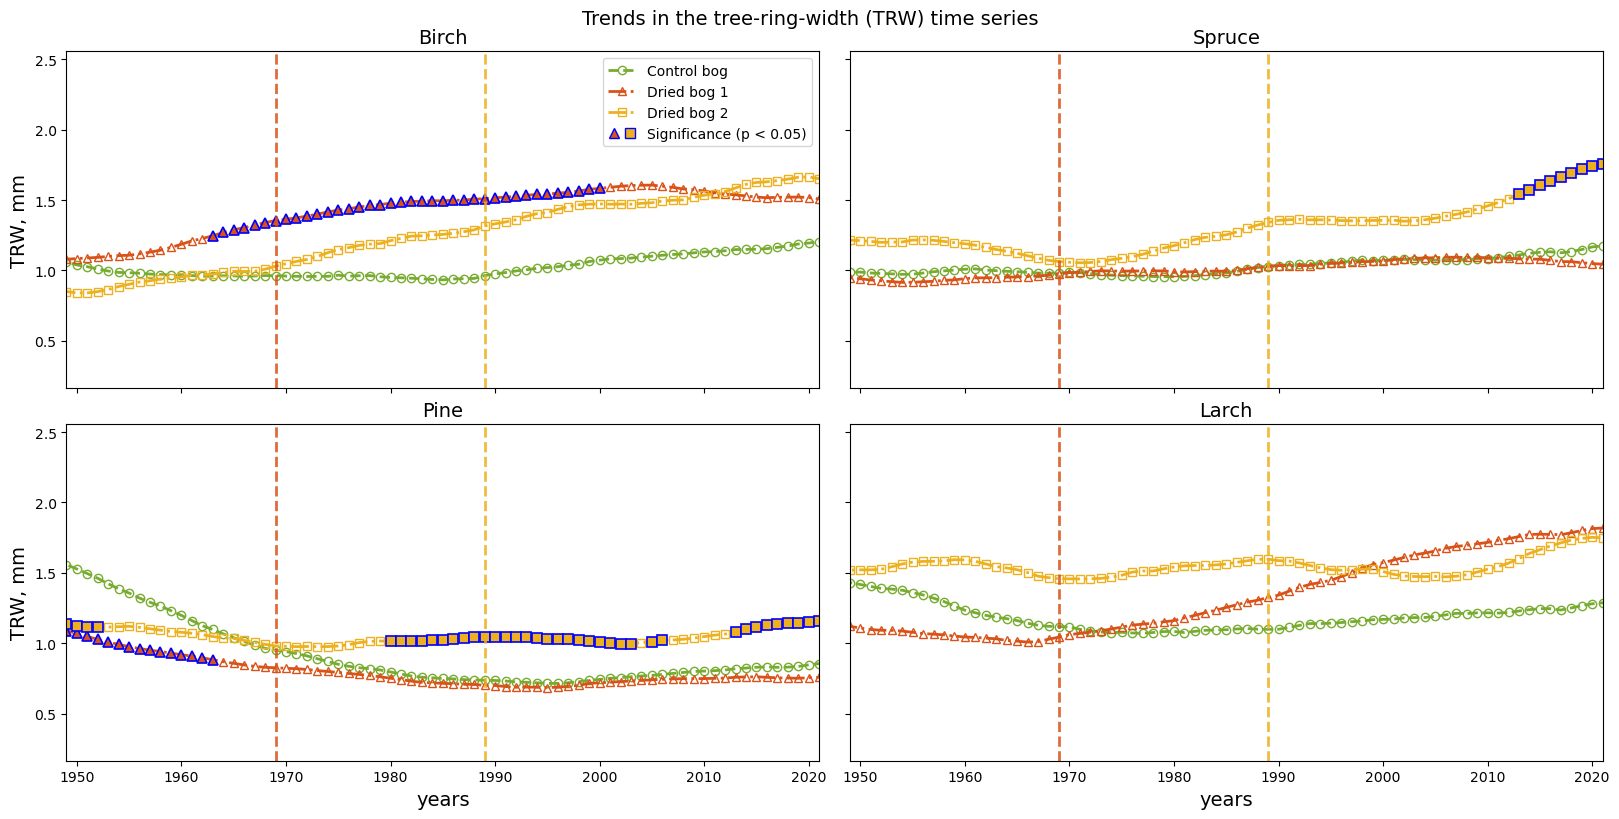

In [10]:
# (7) TRW trend comparison by cohort (reference vs impacted)
# --- INPUT:  data_trend (T×N), dates (T,), cohort & location labels
# --- OUTPUT: Figure_3.pdf, TRW_3.csv
# Rationale:
#   Plot cohort-mean long-term trends and mark per-year differences (p<ALPHA).

T = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

global_vals = []

for ax, sp in zip(axes, SPEC_IDS):
    sel0 = (specium == sp) & (location == 1)
    sel1 = (specium == sp) & (location == 2)
    sel2 = (specium == sp) & (location == 3)

    y0 = row_nanmean(data_trend[:, sel0]) if sel0.any() else np.full(T, np.nan)
    y1 = row_nanmean(data_trend[:, sel1]) if sel1.any() else np.full(T, np.nan)
    y2 = row_nanmean(data_trend[:, sel2]) if sel2.any() else np.full(T, np.nan)

    ax.plot(dates, y0, "o--", linewidth=2, color=C0, markersize=6,
            markerfacecolor="none", markeredgecolor=C0, label=loc_names[0])
    ax.plot(dates, y1, "^-.", linewidth=2, color=C1, markersize=6,
            markerfacecolor="none", markeredgecolor=C1, label=loc_names[1])
    ax.plot(dates, y2, "s-.", linewidth=2, color=C2, markersize=6,
            markerfacecolor="none", markeredgecolor=C2, label=loc_names[2])

    P1 = pvals_by_year(data_trend, sel0, sel1, dates, method=TEST)
    P2 = pvals_by_year(data_trend, sel0, sel2, dates, method=TEST)
    sig1 = np.isfinite(P1) & (P1 < ALPHA)
    sig2 = np.isfinite(P2) & (P2 < ALPHA)

    y1_sig = y1.copy(); y1_sig[~sig1] = np.nan
    y2_sig = y2.copy(); y2_sig[~sig2] = np.nan
    ax.plot(dates, y1_sig, linestyle="None", marker="^", markersize=7,
            markerfacecolor=C1, markeredgecolor="b", markeredgewidth=1.2)
    ax.plot(dates, y2_sig, linestyle="None", marker="s", markersize=7,
            markerfacecolor=C2, markeredgecolor="b", markeredgewidth=1.2)

    mark_years(ax, MARK_YEARS, MARK_COLORS)
    if PLOT_YEARS is not None:
        apply_plot_years(ax, dates)

    title = spec_names[sp-1] if (sp-1) < len(spec_names) else f"Species {sp}"
    ax.set_title(title, fontsize=14);
    if (list(SPEC_IDS).index(sp) % 2) == 0:
        ax.set_ylabel('TRW, mm', fontsize=14)
    if (list(SPEC_IDS).index(sp) // 2) == 1:
        ax.set_xlabel("years", fontsize=14)
    # ax.legend(loc="upper right")
    # [DIAG]
    # sig1_cnt = int(np.nansum(sig1)); sig2_cnt = int(np.nansum(sig2))
    # print(f"[DIAG][TREND] Species {sp}: nC={sel0.sum()}, nD1={sel1.sum()}, nD2={sel2.sum()}, "
    #       f"sig(C vs D1)={sig1_cnt}, sig(C vs D2)={sig2_cnt} (TEST={TEST}, ALPHA={ALPHA})")

fig.suptitle("Trends in the tree-ring-width (TRW) time series", fontsize=14)
axes[0].legend([h0, h1, h2, sig],
               [loc_names[0], loc_names[1], loc_names[2], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)},
               loc="best")

if SAVE_OUTPUTS:
    plt.savefig(RESULTS / "Figure_3.pdf", format="pdf")
    pd.DataFrame(data_trend).to_csv(RESULTS / "TRW_3.csv", index=False, header=False)
plt.show()


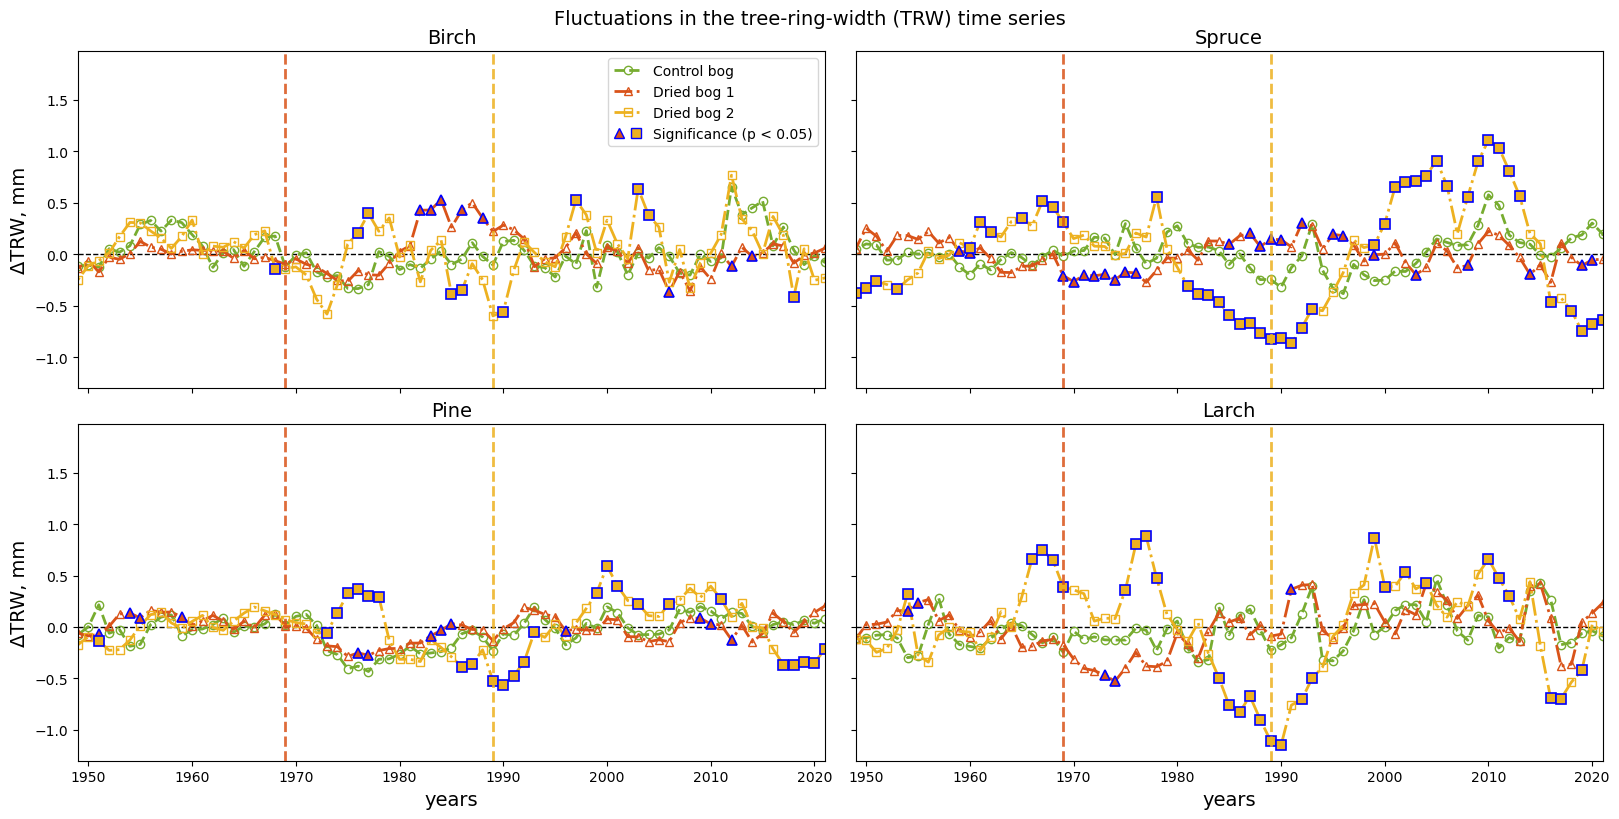

In [11]:
# (8) TRW fluctuation comparison by cohort (reference vs impacted)
# --- INPUT:  data_fluct (T×N), dates (T,), cohort & location labels
# --- OUTPUT: Figure_4.pdf, TRW_4.csv
# Rationale:
#   Plot cohort-mean stationary fluctuations (around the trend) with a zero baseline and
#   per-year significance overlays vs the reference cohort.

T = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

for ax, sp in zip(axes, SPEC_IDS):
    sel0 = (specium == sp) & (location == 1)
    sel1 = (specium == sp) & (location == 2)
    sel2 = (specium == sp) & (location == 3)

    y0 = row_nanmean(data_fluct[:, sel0]) if sel0.any() else np.full(T, np.nan)
    y1 = row_nanmean(data_fluct[:, sel1]) if sel1.any() else np.full(T, np.nan)
    y2 = row_nanmean(data_fluct[:, sel2]) if sel2.any() else np.full(T, np.nan)

    ax.axhline(0.0, color="k", linestyle="--", linewidth=1)

    ax.plot(dates, y0, "o--", linewidth=2, color=C0, markersize=6,
            markerfacecolor="none", markeredgecolor=C0, label=loc_names[0])
    ax.plot(dates, y1, "^-.", linewidth=2, color=C1, markersize=6,
            markerfacecolor="none", markeredgecolor=C1, label=loc_names[1])
    ax.plot(dates, y2, "s-.", linewidth=2, color=C2, markersize=6,
            markerfacecolor="none", markeredgecolor=C2, label=loc_names[2])

    P1 = pvals_by_year(data_fluct, sel0, sel1, dates, method=TEST)
    P2 = pvals_by_year(data_fluct, sel0, sel2, dates, method=TEST)
    sig1 = np.isfinite(P1) & (P1 < ALPHA)
    sig2 = np.isfinite(P2) & (P2 < ALPHA)

    y1_sig = y1.copy(); y1_sig[~sig1] = np.nan
    y2_sig = y2.copy(); y2_sig[~sig2] = np.nan
    ax.plot(dates, y1_sig, linestyle="None", marker="^", markersize=7,
            markerfacecolor=C1, markeredgecolor="b", markeredgewidth=1.2)
    ax.plot(dates, y2_sig, linestyle="None", marker="s", markersize=7,
            markerfacecolor=C2, markeredgecolor="b", markeredgewidth=1.2)

    mark_years(ax, MARK_YEARS, MARK_COLORS)
    if PLOT_YEARS is not None:
        apply_plot_years(ax, dates)

    title = spec_names[sp-1] if (sp-1) < len(spec_names) else f"Species {sp}"
    ax.set_title(title, fontsize=14);
    if (list(SPEC_IDS).index(sp) % 2) == 0:
        ax.set_ylabel('ΔTRW, mm', fontsize=14)
    if (list(SPEC_IDS).index(sp) // 2) == 1:
        ax.set_xlabel("years", fontsize=14)
    # [DIAG]
    # sig1_cnt = int(np.nansum(sig1)); sig2_cnt = int(np.nansum(sig2))
    # print(f"[DIAG][FLUCT] Species {sp}: nC={sel0.sum()}, nD1={sel1.sum()}, nD2={sel2.sum()}, "
    #       f"sig(C vs D1)={sig1_cnt}, sig(C vs D2)={sig2_cnt} (TEST={TEST}, ALPHA={ALPHA})")

fig.suptitle("Fluctuations in the tree-ring-width (TRW) time series", fontsize=14)
axes[0].legend([h0, h1, h2, sig],
               [loc_names[0], loc_names[1], loc_names[2], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)},
               loc="best")

if SAVE_OUTPUTS:
    plt.savefig(RESULTS / "Figure_4.pdf", format="pdf")
    pd.DataFrame(data_fluct).to_csv(RESULTS / "TRW_4.csv", index=False, header=False)
plt.show()


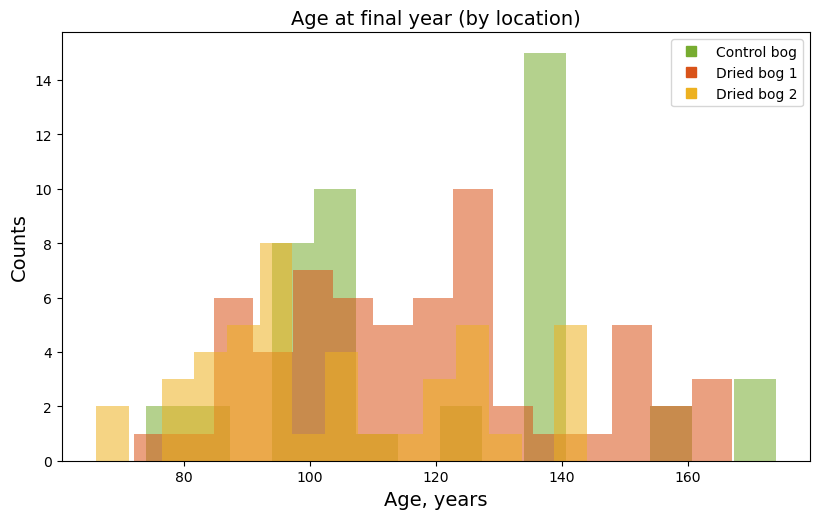

In [12]:
# (9) Derive tree birth years and age matrix; age histogram by location
# --- INPUT:  data (T×N), dates (T,), location (N,)
# --- OUTPUT: birth (N,), age (T×N)
# Rationale:
#   Birth year = first finite TRW observation per tree. Age(t,j)=year_t−birth_j with negatives masked.
#   Inspect end-year age distributions by location to reveal cohort age structures.

T, N = data.shape

birth = np.full(N, np.nan)
finite_mask = np.isfinite(data)
for j in range(N):
    idx = np.where(finite_mask[:, j])[0]
    if idx.size:
        birth[j] = dates[idx[0]]

age = dates[:, None] - birth[None, :]
age[age < 0] = np.nan

# Histogram of ages at the final year by location
fig, ax = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True)  
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0, hspace=0.0) 

bins = 15
loc_vals = [1, 2, 3]
for lv in loc_vals:
    sel = (location == lv)
    vals = age[-1, sel]
    vals = vals[np.isfinite(vals)]
    if vals.size:
        ax.hist(vals, bins=bins, alpha=0.55, label=loc_names[lv-1],
                color=(C0 if lv==1 else C1 if lv==2 else C2), edgecolor='none') 

ax.set_title("Age at final year (by location)", fontsize=14)
ax.set_xlabel("Age, years", fontsize=14)
ax.set_ylabel("Counts", fontsize=14)
ax.legend([Line2D([], [], ls="None", marker="s", color=C0, mfc=C0, mec=C0, ms=7), 
           Line2D([], [], ls="None", marker="s", color=C1, mfc=C1, mec=C1, ms=7), 
           Line2D([], [], ls="None", marker="s", color=C2, mfc=C2, mec=C2, ms=7)], 
          [loc_names[0], loc_names[1], loc_names[2]], loc='best')
plt.show()

# [DIAG]
# b5 = " ".join(str(int(x)) for x in birth[:5] if np.isfinite(x))
# print(f"[DIAG] birth (first 5): {b5} ...")
# print(f"[DIAG] age size = {age.shape[0]}x{age.shape[1]}, NaN% = {np.isnan(age).mean()*100:.2f}")


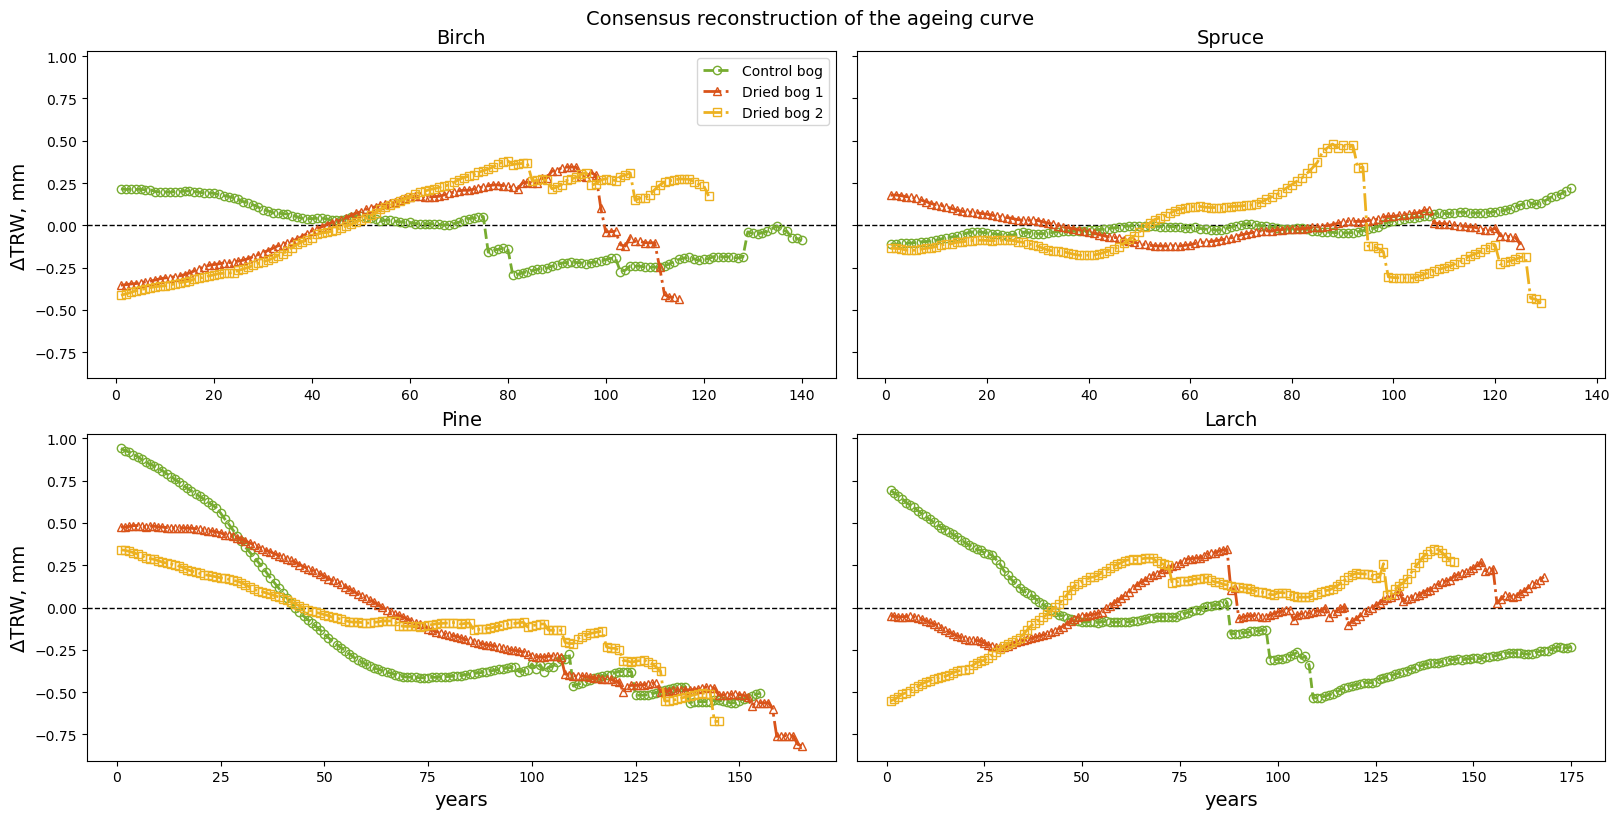

In [13]:
# (10) Consensus age–growth curve (cohort × location) and broadcasting
# --- INPUT:  data_trend (T×N), dates (T,), birth (N,), cohort & location labels
# --- OUTPUT: A (T×N), A2 (T×N), A_cohort (T×⋯×loc), Figure_5.pdf, TRW_5.csv
# Rationale:
#   Align trends by biological age (age-synchronous stacking) within each cohort×location,
#   compute consensus ageing profiles, zero-center them by cohort mean, and broadcast back
#   to trees (A2). Plot consensus curves to validate shape realism.

A  = np.full((T, N), np.nan)
A2 = np.full((T, N), np.nan)   # species×location consensus profile broadcast to each tree

dates_i = np.rint(dates).astype(int)
birth_i = np.rint(birth).astype(int)

# Put each tree’s trend starting at its birth year
for j in range(N):
    if not np.isfinite(birth[j]):
        continue
    start = birth_i[j] - dates_i[0]
    if 0 <= start < T:
        seg = data_trend[start:, j]
        A[:seg.shape[0], j] = seg

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=False, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

# A_col: T × nSpecies × 3 
A_col = np.full((T, len(SPEC_IDS), 3), np.nan)

age_x = np.arange(1, T+1)

for ax, sp in zip(axes, SPEC_IDS):             
    sp_i = int(np.where(SPEC_IDS == sp)[0][0])  

    sel0 = (specium == sp) & (location == 1)  # Control
    sel1 = (specium == sp) & (location == 2)  # Dried 1
    sel2 = (specium == sp) & (location == 3)  # Dried 2

    ax.axhline(0.0, color='k', linestyle='--', linewidth=1)

    # species×location consensus
    if sel0.any():
        prof_rows = nanmean_axis_safe(A[:, sel0], axis=1)
        mu_all    = safe_nanmean(A[:, sel0])
        prof0     = prof_rows - mu_all
        A_col[:, sp_i, 0] = prof0
        A2[:, sel0] = prof0[:, None]
        ax.plot(age_x, prof0, linestyle='--', linewidth=2, marker='o', markersize=6,
                color=C0, markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])

    if sel1.any():
        prof_rows = nanmean_axis_safe(A[:, sel1], axis=1)
        mu_all    = safe_nanmean(A[:, sel1])
        prof1     = prof_rows - mu_all
        A_col[:, sp_i, 1] = prof1
        A2[:, sel1] = prof1[:, None]
        ax.plot(age_x, prof1, linestyle='-.', linewidth=2, marker='^', markersize=6,
                color=C1, markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])

    if sel2.any():
        prof_rows = nanmean_axis_safe(A[:, sel2], axis=1)
        mu_all    = safe_nanmean(A[:, sel2])
        prof2     = prof_rows - mu_all
        A_col[:, sp_i, 2] = prof2
        A2[:, sel2] = prof2[:, None]
        ax.plot(age_x, prof2, linestyle='-.', linewidth=2, marker='s', markersize=6,
                color=C2, markerfacecolor='none', markeredgecolor=C2, label=loc_names[2])

    title = spec_names[sp-1] if (sp-1) < len(spec_names) else f"Species {sp}"
    ax.set_title(title, fontsize=14);
    if (list(SPEC_IDS).index(sp) % 2) == 0:
        ax.set_ylabel('ΔTRW, mm', fontsize=14)
    if (list(SPEC_IDS).index(sp) // 2) == 1:
        ax.set_xlabel("years", fontsize=14)

axes[0].legend([h0, h1, h2], [loc_names[0], loc_names[1], loc_names[2]], loc='best')

plt.suptitle("Consensus reconstruction of the ageing curve", fontsize=14)

if SAVE_OUTPUTS:
    plt.savefig(RESULTS / "Figure_5.pdf", format="pdf")
    pd.DataFrame(A).to_csv(RESULTS / "TRW_5.csv", index=False, header=False)
plt.show()

# [DIAG]
# diag_print("A (T x N)", A)
# diag_print("A2 (T x N)", A2)


In [14]:
# (11) Age-baseline removal (age-rectified trend)
# --- INPUT:  data_trend (T×N), A2 (T×N), dates (T,), birth (N,)
# --- OUTPUT: data_trend_noage (T×N)
# Rationale:
#   Subtract the broadcast consensus age profile per tree, aligned to its birth, to remove
#   age-related baseline while preserving calendar alignment.

data_trend_noage = np.full_like(data, np.nan)
for j in range(N):
    if not np.isfinite(birth[j]):
        continue
    start = birth_i[j] - dates_i[0]
    if 0 <= start < T:
        L = data_trend[start:, j].shape[0]
        data_trend_noage[start:, j] = data_trend[start:, j] - A2[:L, j]

# [DIAG]
# diag_print("data_trend_noage (T x N)", data_trend_noage)


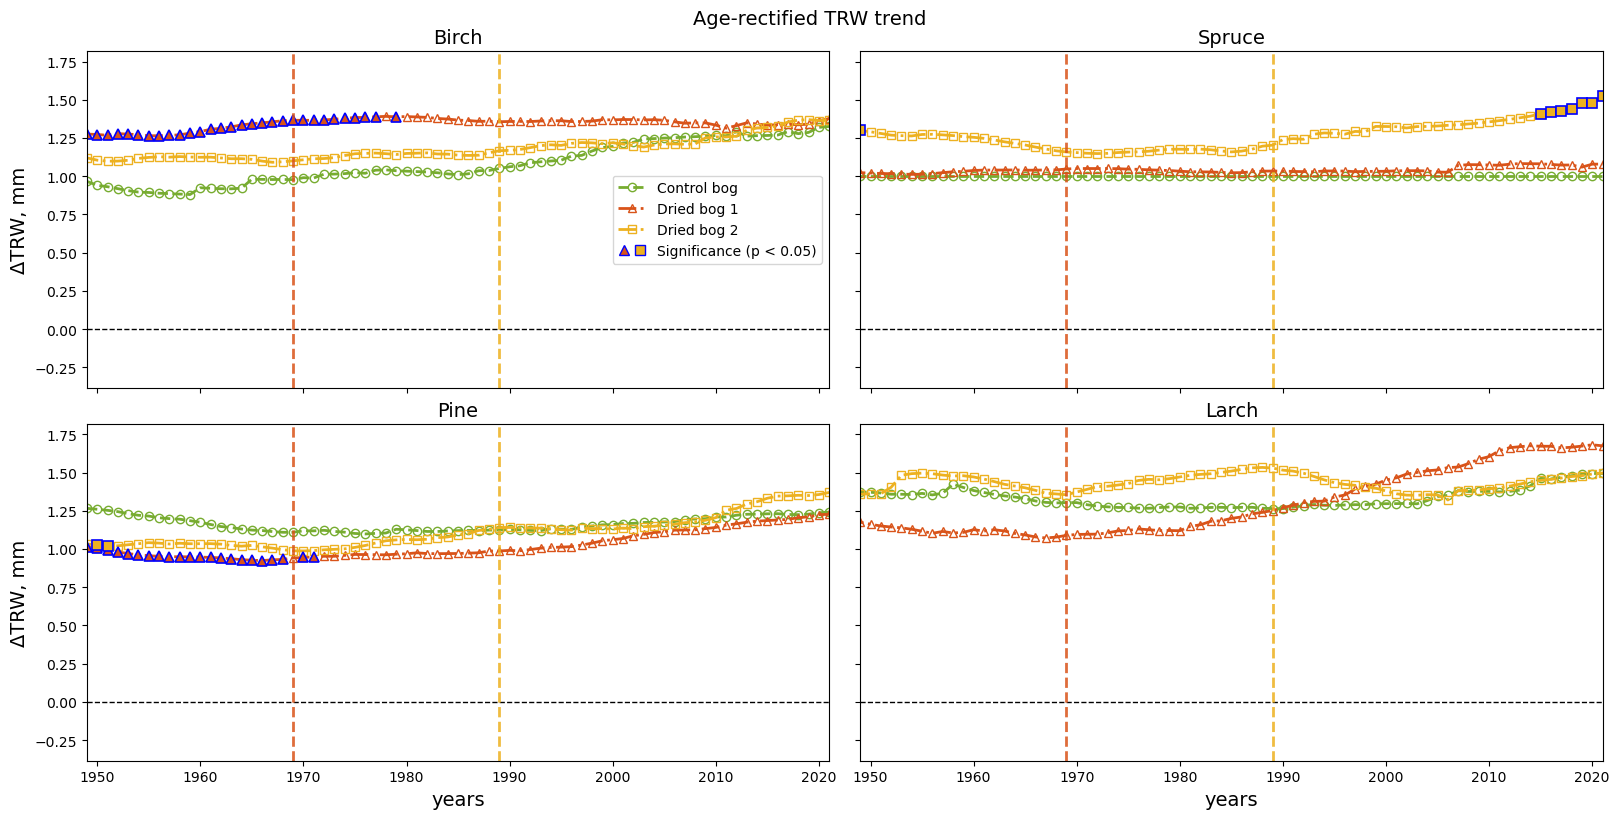

In [15]:
# (12) Age-rectified TRW trend — cohort comparison with per-year tests
# --- INPUT:  data_trend_noage (T×N), dates (T,), cohort & location labels
# --- OUTPUT: Figure_6.pdf, TRW_6.csv
# Rationale:
#   After removing age effects, test whether cohort means still differ at each year (p<ALPHA).

Tlen = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

for ax, sp in zip(axes, SPEC_IDS):
    sel0 = (specium == sp) & (location == 1)  # Control
    sel1 = (specium == sp) & (location == 2)  # Dried 1
    sel2 = (specium == sp) & (location == 3)  # Dried 2

    y0 = row_nanmean(data_trend_noage[:, sel0]) if sel0.any() else np.full(Tlen, np.nan)
    y1 = row_nanmean(data_trend_noage[:, sel1]) if sel1.any() else np.full(Tlen, np.nan)
    y2 = row_nanmean(data_trend_noage[:, sel2]) if sel2.any() else np.full(Tlen, np.nan)

    P1 = pvals_by_year(data_trend_noage, sel0, sel1, dates, method=TEST)
    P2 = pvals_by_year(data_trend_noage, sel0, sel2, dates, method=TEST)
    sig1 = np.isfinite(P1) & (P1 < ALPHA)
    sig2 = np.isfinite(P2) & (P2 < ALPHA)

    ax.axhline(0.0, color='k', linestyle='--', linewidth=1)
    
    ax.plot(dates, y0, "o--", linewidth=2, color=C0, markersize=6,
            markerfacecolor="none", markeredgecolor=C0, label=loc_names[0])
    ax.plot(dates, y1, "^-.", linewidth=2, color=C1, markersize=6,
            markerfacecolor="none", markeredgecolor=C1, label=loc_names[1])
    ax.plot(dates, y2, "s-.", linewidth=2, color=C2, markersize=6,
            markerfacecolor="none", markeredgecolor=C2, label=loc_names[2])

    y1_sig = y1.copy(); y1_sig[~sig1] = np.nan
    y2_sig = y2.copy(); y2_sig[~sig2] = np.nan
    ax.plot(dates, y1_sig, linestyle="None", marker="^", markersize=7,
            markerfacecolor=C1, markeredgecolor="b", markeredgewidth=1.2)
    ax.plot(dates, y2_sig, linestyle="None", marker="s", markersize=7,
            markerfacecolor=C2, markeredgecolor="b", markeredgewidth=1.2)

    mark_years(ax, MARK_YEARS, MARK_COLORS)
    if PLOT_YEARS is not None:
        apply_plot_years(ax, dates)

    title = spec_names[sp-1] if (sp-1) < len(spec_names) else f"Species {sp}"
    ax.set_title(title, fontsize=14);
    if (list(SPEC_IDS).index(sp) % 2) == 0:
        ax.set_ylabel('ΔTRW, mm', fontsize=14)
    if (list(SPEC_IDS).index(sp) // 2) == 1:
        ax.set_xlabel("years", fontsize=14)
    # [DIAG]
    # sig1_cnt = int(np.nansum(sig1)); sig2_cnt = int(np.nansum(sig2))
    # print(f"[DIAG][TREND_NOAGE] Species {sp}: nC={sel0.sum()}, nD1={sel1.sum()}, nD2={sel2.sum()}, "
    #       f"sig(C vs D1)={sig1_cnt}, sig(C vs D2)={sig2_cnt} (TEST={TEST}, ALPHA={ALPHA})")

fig.suptitle("Age-rectified TRW trend", fontsize=14)
axes[0].legend([h0, h1, h2, sig],
               [loc_names[0], loc_names[1], loc_names[2], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)},
               loc="best")

if SAVE_OUTPUTS:
    plt.savefig(RESULTS / "Figure_6.pdf", format="pdf")
    pd.DataFrame(data_trend_noage).to_csv(RESULTS / "TRW_6.csv", index=False, header=False)
plt.show()


In [16]:
# (14) NPBN helpers — py_banshee cache safety shim + single-line Jupyter progress
# --- INPUT:  —
# --- OUTPUT:  inference_with_live_line(...); patched rankcorr helpers
# Rationale:
#   Patch rank-correlation cache helpers to be robust to large parent sets (Python big ints).
#   Provide a live single-line progress wrapper for NPBN inference. Scientific API unchanged.

if not getattr(_banshee_rc, "_shim_ok", False):
    def _calc_val_safe(cond, m):
        """Stable polynomial hash for a parent set 'cond' given base 'm' (pure Python big ints)."""
        if not cond:
            return 0
        sc = sorted(int(c) for c in cond)
        v = 0
        p = 1
        m = int(m)
        for c in sc:              # v += (c+1) * m**i
            v += (c + 1) * p
            p *= m
        return int(v)

    def _add_corr_safe(Lc, val, r):
        """
        Normalize a cache cell 'Lc' to a list of [key, corr] and upsert (val -> r).
        Prevents 'int is not subscriptable' and dtype issues in rankcorr.PartCorr().
        """
        recs = []
        if isinstance(Lc, (int, float, np.integer, np.floating)) or Lc is None:
            recs = []
        else:
            try:
                it = Lc if isinstance(Lc, Iterable) and not isinstance(Lc, (str, bytes)) else []
                for item in it:
                    try:
                        k = int(item[0]); cv = float(item[1]) if len(item) > 1 else np.nan
                        recs.append([k, cv])
                    except Exception:
                        recs.append([int(item), np.nan])
            except Exception:
                recs = []
        key = int(val); rv = float(r)
        for rec in recs:
            if rec[0] == key:
                rec[1] = rv
                break
        else:
            recs.append([key, rv])
        recs.sort(key=lambda x: x[0])
        return recs

    _banshee_rc.calc_val = _calc_val_safe
    _banshee_rc.add_corr  = _add_corr_safe
    _banshee_rc._shim_ok  = True  # mark applied

# --- One-line live progress wrapper for inference ---
def inference_with_live_line(*, label: str, Nodes, Values, R, DATA,
                             Output='mean', SampleSize=10000, Interp='next'):
    """
    Wrap py_banshee.prediction.inference showing a single live Markdown line:
    '{label} — NN%'. Avoids noisy multi-line prints in Jupyter.
    """
    handle = display(Markdown(f"**{label} — 0%**"), display_id=True)

    class _LineCap(io.TextIOBase):
        _rx = re.compile(r'Progress:\s*(\d+)\s*%')
        def write(self, s):
            m = self._rx.search(s)
            if m:
                pct = int(m.group(1))
                try:
                    handle.update(Markdown(f"**{label} — {pct}%**"))
                except Exception:
                    pass
            return len(s)
        def flush(self): pass

    cap = _LineCap()
    old_out, old_err = sys.stdout, sys.stderr
    try:
        sys.stdout = sys.stderr = cap
        return inference(Nodes=Nodes, Values=Values, R=R, DATA=DATA,
                         Output=Output, SampleSize=SampleSize, Interp=Interp)
    finally:
        sys.stdout, sys.stderr = old_out, old_err
        handle.update(Markdown(f"**{label} — done (100%)**"))


In [17]:
# (14) NPBN for TRW trend (conditionalization on climate predictors)
# --- INPUT:  stats0 (T×20), data_trend_noage (T×N), dates (T,), specium (N,), location (N,)
# --- OUTPUT: X_climate_attr_trend (T×N), X_reconstr_trend (T×N)
# Rationale:
#   Construct a Nonparametric Bayesian Network (NPBN) with a triangular acyclic parent structure
#   (each node depends on previous nodes only). Nodes 1..20 are climate predictors
#   (seasonal PDSI and temperature lags), node 21 is the target TRW trend (age-rectified).
#   For each (species×location) cohort, estimate the rank-correlation matrix (bn_rankcorr),
#   then perform conditionalization (inference) on observed climate to obtain the posterior
#   mean of TRW_trend. Scatter predictions back to (year, tree) grid and form the residual
#   (climate-rectified trend) by subtraction.

# Allocate output matrix for climate-attributable trend component
X_climate_attr_trend = np.full_like(data, np.nan)

# BN dimensionality: 20 climate inputs + 1 TRW target = 21 nodes
n_cell = 21
# Parent structure:
#   Triangular ordering (node k may depend on nodes 0..k-1) enforces acyclicity and
#   supports nonparametric dependence via empirical copulas (rank correlations).
ParentCell = [list(range(k)) for k in range(n_cell)]

# Unique species and locations present in the dataset
Uspec = np.sort(np.unique(specium[np.isfinite(specium)]).astype(int))
Uloc  = np.sort(np.unique(location[np.isfinite(location)]).astype(int))

T = len(dates)
for spec_id in Uspec:
    for loc_id in Uloc:
        # Select the current (species × location) cohort
        sel = (specium == spec_id) & (location == loc_id)
        if not np.any(sel):
            continue

        idx_sel = np.where(sel)[0]  # indices of trees in this cohort

        # Build the learning table:
        #   - Repeat climate feature block (stats0) for each tree in the cohort
        #   - Append that tree's TRW trend (age-rectified) as the final (21st) column
        # Row order is column-stacked by tree (Fortran-like) to preserve (year,tree) mapping.
        stats_rep = np.tile(stats0, (int(sel.sum()), 1))                          # (T*sum(sel) × 20)
        trw_spec  = np.reshape(data_trend_noage[:, sel], (-1, 1), order='F')     # (T*sum(sel) × 1)
        stats1    = np.hstack([stats_rep, trw_spec])                              # (T*sum(sel) × 21)

        # Prepare index vectors to scatter predictions back to the (date, tree) grid
        idx_tree = np.tile(idx_sel, (T, 1)).reshape(-1, order='F')                # tree id per row
        idx_date = np.tile(np.arange(T, dtype=int), int(sel.sum()))               # date index per row

        # Keep only rows complete for the first 21 columns (nodes used by the BN)
        row_ok = ~np.isnan(stats1[:, :n_cell]).any(axis=1)
        if not np.any(row_ok):
            continue

        stats1_used = stats1[row_ok, :n_cell]
        idx_tree_ok = idx_tree[row_ok]
        idx_date_ok = idx_date[row_ok]

        # Name the variables: P11..P20 (PDSI), T11..T20 (Temp), and the 21st node TRW_trend
        colnames = [f"P{j:02d}" for j in range(11, 21)] + [f"T{j:02d}" for j in range(11, 21)] + ["TRW_trend"]
        stats1_df = pd.DataFrame(stats1_used, columns=colnames)

        # 'Values' matrix for conditionalization = observed values of parent/input nodes (1..20)
        values_np = stats1_df.iloc[:, :n_cell - 1].to_numpy()

        # Learn NPBN dependence structure via rank correlations:
        # bn_rankcorr returns a rank-correlation representation consistent with ParentCell
        # (empirical copula approach; robust to marginal transforms).
        R_Banshee = bn_rankcorr(parent_cell=ParentCell,
                                data=stats1_df,
                                is_data=True,
                                var_names=colnames,
                                plot=False)

        # Human-readable progress label for this cohort (for the live line)
        spec_label = spec_names[spec_id-1] if (spec_id-1) < len(spec_names) else f"Specium {spec_id}"
        loc_label  = loc_names[loc_id-1]   if (loc_id-1)   < len(loc_names)  else f"loc={loc_id}"
        label = f"NPBN (trend) — {spec_label} [{loc_label}]"

        # Conditionalization (inference) over the NPBN:
        #   Nodes     = indices of conditioned inputs
        #   Values    = observed climate features for each row
        #   Output    = 'mean' → posterior mean of the predictive distribution for node 21
        #   SampleSize= 10000 → size of Monte-Carlo draw used internally
        #   Interp    = 'next' → interpolation method for empirical CDFs
        F = inference_with_live_line(label=label,
                                     Nodes=list(range(0, n_cell - 1)),
                                     Values=values_np,
                                     R=R_Banshee,
                                     DATA=stats1_df,
                                     Output='mean',
                                     SampleSize=10000,
                                     Interp='next')

        # Scatter predicted TRW_trend back to (date, tree) locations for this cohort
        F_vec = np.asarray(F).ravel()
        for tree in np.unique(idx_tree_ok):
            m = (idx_tree_ok == tree)
            if np.any(m):
                X_climate_attr_trend[idx_date_ok[m], tree] = F_vec[m]

# Climate-rectified trend (residual): remove the climate-attributable component from the age-rectified trend
X_reconstr_trend = data_trend_noage - X_climate_attr_trend

# [DIAG]
# diag_print("X_climate_attr_trend (T x N)", X_climate_attr_trend)
# diag_print("X_reconstr_trend (T x N)", X_reconstr_trend)


**NPBN (trend) — Birch [Control bog] — done (100%)**

**NPBN (trend) — Birch [Dried bog 1] — done (100%)**

**NPBN (trend) — Birch [Dried bog 2] — done (100%)**

**NPBN (trend) — Spruce [Control bog] — done (100%)**

**NPBN (trend) — Spruce [Dried bog 1] — done (100%)**

**NPBN (trend) — Spruce [Dried bog 2] — done (100%)**

**NPBN (trend) — Pine [Control bog] — done (100%)**

**NPBN (trend) — Pine [Dried bog 1] — done (100%)**

**NPBN (trend) — Pine [Dried bog 2] — done (100%)**

**NPBN (trend) — Larch [Control bog] — done (100%)**

**NPBN (trend) — Larch [Dried bog 1] — done (100%)**

**NPBN (trend) — Larch [Dried bog 2] — done (100%)**

In [18]:
# (15) NPBN for TRW fluctuations (conditionalization on climate predictors)
# --- INPUT:  stats0 (T×20), data_fluct (T×N), cohort & location labels
# --- OUTPUT: X_climate_attr_fluct (T×N), X_reconstr_fluct (T×N)
# Rationale:
#   Same NPBN architecture, with TRW_fluct as the target node. Condition on climate and
#   subtract the climate-attributable component to obtain residual fluctuations.

# Allocate output matrix for climate-attributable fluctuation component
X_climate_attr_fluct = np.full_like(data, np.nan)

# Same BN size and parent structure: 20 climate inputs → 1 TRW_fluct target
n_cell = 21
ParentCell = [list(range(k)) for k in range(n_cell)]

Uspec = np.sort(np.unique(specium[np.isfinite(specium)]).astype(int))
Uloc  = np.sort(np.unique(location[np.isfinite(location)]).astype(int))

T = len(dates)
for spec_id in Uspec:
    for loc_id in Uloc:
        # Select cohort
        sel = (specium == spec_id) & (location == loc_id)
        if not np.any(sel):
            continue

        idx_sel = np.where(sel)[0]

        # Learning table for fluctuations:
        #   climate block (repeated per tree) + TRW_fluct as column 21
        stats_rep = np.tile(stats0, (int(sel.sum()), 1))                          # (T*sum(sel) × 20)
        trw_spec  = np.reshape(data_fluct[:, sel], (-1, 1), order='F')           # (T*sum(sel) × 1)
        stats1    = np.hstack([stats_rep, trw_spec])                              # (T*sum(sel) × 21)

        # Indices to map predictions back
        idx_tree = np.tile(idx_sel, (T, 1)).reshape(-1, order='F')
        idx_date = np.tile(np.arange(T, dtype=int), int(sel.sum()))

        # Keep rows complete for nodes 1..21
        row_ok = ~np.isnan(stats1[:, :n_cell]).any(axis=1)
        if not np.any(row_ok):
            continue

        stats1_used = stats1[row_ok, :n_cell]
        idx_tree_ok = idx_tree[row_ok]
        idx_date_ok = idx_date[row_ok]

        # Variable names: same climate names; 21st node renamed to TRW_fluct
        colnames  = [f"P{j:02d}" for j in range(11, 21)] + [f"T{j:02d}" for j in range(11, 21)] + ["TRW_fluct"]
        stats1_df = pd.DataFrame(stats1_used, columns=colnames)

        # Observed inputs for conditionalization
        values_np = stats1_df.iloc[:, :n_cell - 1].to_numpy()

        # Rank-correlation learning for the NPBN under triangular parent sets
        R_Banshee = bn_rankcorr(parent_cell=ParentCell,
                                data=stats1_df,
                                is_data=True,
                                var_names=colnames,
                                plot=False)

        # Progress label
        spec_label = spec_names[spec_id-1] if (spec_id-1) < len(spec_names) else f"Specium {spec_id}"
        loc_label  = loc_names[loc_id-1]   if (loc_id-1)   < len(loc_names)  else f"loc={loc_id}"
        label = f"NPBN (fluct) — {spec_label} [{loc_label}]"

        # Conditionalization (posterior mean for TRW_fluct given climate)
        F = inference_with_live_line(label=label,
                                     Nodes=list(range(0, n_cell - 1)),
                                     Values=values_np,
                                     R=R_Banshee,
                                     DATA=stats1_df,
                                     Output='mean',
                                     SampleSize=10000,
                                     Interp='next')

        # Back-scatter cohort predictions to (date, tree)
        F_vec = np.asarray(F).ravel()
        for tree in np.unique(idx_tree_ok):
            m = (idx_tree_ok == tree)
            if np.any(m):
                X_climate_attr_fluct[idx_date_ok[m], tree] = F_vec[m]

# Climate-rectified fluctuations (residual): remove climate-attributable part
X_reconstr_fluct = data_fluct - X_climate_attr_fluct

# [DIAG]
# diag_print("X_climate_attr_fluct (T x N)", X_climate_attr_fluct)
# diag_print("X_reconstr_fluct (T x N)", X_reconstr_fluct)


**NPBN (fluct) — Birch [Control bog] — done (100%)**

**NPBN (fluct) — Birch [Dried bog 1] — done (100%)**

**NPBN (fluct) — Birch [Dried bog 2] — done (100%)**

**NPBN (fluct) — Spruce [Control bog] — done (100%)**

**NPBN (fluct) — Spruce [Dried bog 1] — done (100%)**

**NPBN (fluct) — Spruce [Dried bog 2] — done (100%)**

**NPBN (fluct) — Pine [Control bog] — done (100%)**

**NPBN (fluct) — Pine [Dried bog 1] — done (100%)**

**NPBN (fluct) — Pine [Dried bog 2] — done (100%)**

**NPBN (fluct) — Larch [Control bog] — done (100%)**

**NPBN (fluct) — Larch [Dried bog 1] — done (100%)**

**NPBN (fluct) — Larch [Dried bog 2] — done (100%)**

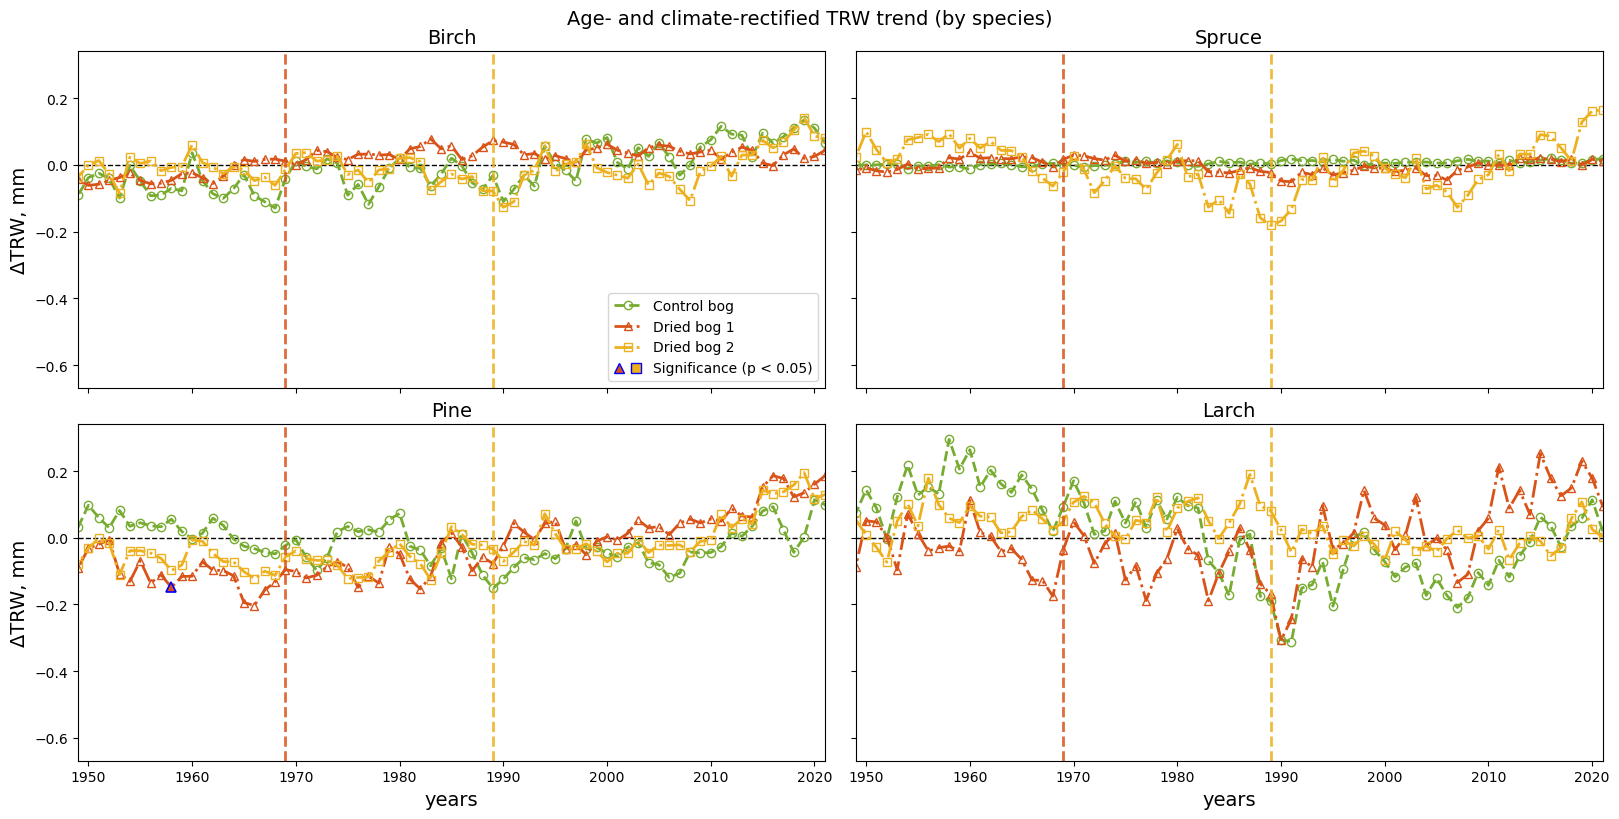

In [19]:
# (16) Climate-rectified TRW trend — cohort comparison
# --- INPUT:  X_reconstr_trend (T×N), dates (T,), cohort & location labels
# --- OUTPUT: Figure_7_BN.pdf, TRW_7_BN.csv
# Rationale:
#   Plot cohort means of the climate-rectified trend and mark per-year differences vs reference.

T = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

for ax, sp in zip(axes, SPEC_IDS):
    sel0 = (specium == sp) & (location == 1)
    sel1 = (specium == sp) & (location == 2)
    sel2 = (specium == sp) & (location == 3)

    y0 = row_nanmean(X_reconstr_trend[:, sel0]) if sel0.any() else np.full(T, np.nan)
    y1 = row_nanmean(X_reconstr_trend[:, sel1]) if sel1.any() else np.full(T, np.nan)
    y2 = row_nanmean(X_reconstr_trend[:, sel2]) if sel2.any() else np.full(T, np.nan)

    ax.axhline(0.0, color="k", linestyle="--", linewidth=1)

    ax.plot(dates, y0, "o--", linewidth=2, color=C0,
            markersize=6, markerfacecolor="none", markeredgecolor=C0, label=loc_names[0])
    ax.plot(dates, y1, "^-.", linewidth=2, color=C1,
            markersize=6, markerfacecolor="none", markeredgecolor=C1, label=loc_names[1])
    ax.plot(dates, y2, "s-.", linewidth=2, color=C2,
            markersize=6, markerfacecolor="none", markeredgecolor=C2, label=loc_names[2])

    P01 = pvals_by_year(X_reconstr_trend, sel0, sel1, dates, method=TEST) if (sel0.any() and sel1.any()) else np.full(T, np.nan)
    P02 = pvals_by_year(X_reconstr_trend, sel0, sel2, dates, method=TEST) if (sel0.any() and sel2.any()) else np.full(T, np.nan)

    sig1 = np.isfinite(P01) & (P01 < ALPHA)
    sig2 = np.isfinite(P02) & (P02 < ALPHA)

    y1_sig = y1.copy(); y1_sig[~sig1] = np.nan
    y2_sig = y2.copy(); y2_sig[~sig2] = np.nan
    ax.plot(dates, y1_sig, linestyle="None", marker="^", markersize=7,
            markerfacecolor=C1, markeredgecolor="b", markeredgewidth=1.2)
    ax.plot(dates, y2_sig, linestyle="None", marker="s", markersize=7,
            markerfacecolor=C2, markeredgecolor="b", markeredgewidth=1.2)

    mark_years(ax, MARK_YEARS, MARK_COLORS)
    if PLOT_YEARS is not None:
        apply_plot_years(ax, dates)

    title = spec_names[sp-1] if (sp-1) < len(spec_names) else f"Species {sp}"
    ax.set_title(title, fontsize=14);
    if (list(SPEC_IDS).index(sp) % 2) == 0:
        ax.set_ylabel('ΔTRW, mm', fontsize=14)
    if (list(SPEC_IDS).index(sp) // 2) == 1:
        ax.set_xlabel("years", fontsize=14)
    # [DIAG]
    # sig1_cnt = int(np.nansum(sig1)); sig2_cnt = int(np.nansum(sig2))
    # print(f"[DIAG][CLIM-TREND] Species {sp}: nC={sel0.sum()}, nD1={sel1.sum()}, nD2={sel2.sum()}, "
    #       f"sig(C vs D1)={sig1_cnt}, sig(C vs D2)={sig2_cnt} (TEST={TEST}, ALPHA={ALPHA})")

plt.suptitle("Age- and climate-rectified TRW trend (by species)", fontsize=14)
axes[0].legend([h0, h1, h2, sig],
               [loc_names[0], loc_names[1], loc_names[2], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)},
               loc="best")

if SAVE_OUTPUTS:
    plt.savefig(RESULTS / "Figure_7_BN.pdf", format="pdf")
    pd.DataFrame(X_reconstr_trend).to_csv(RESULTS / "TRW_7_BN.csv", index=False, header=False)
plt.show()


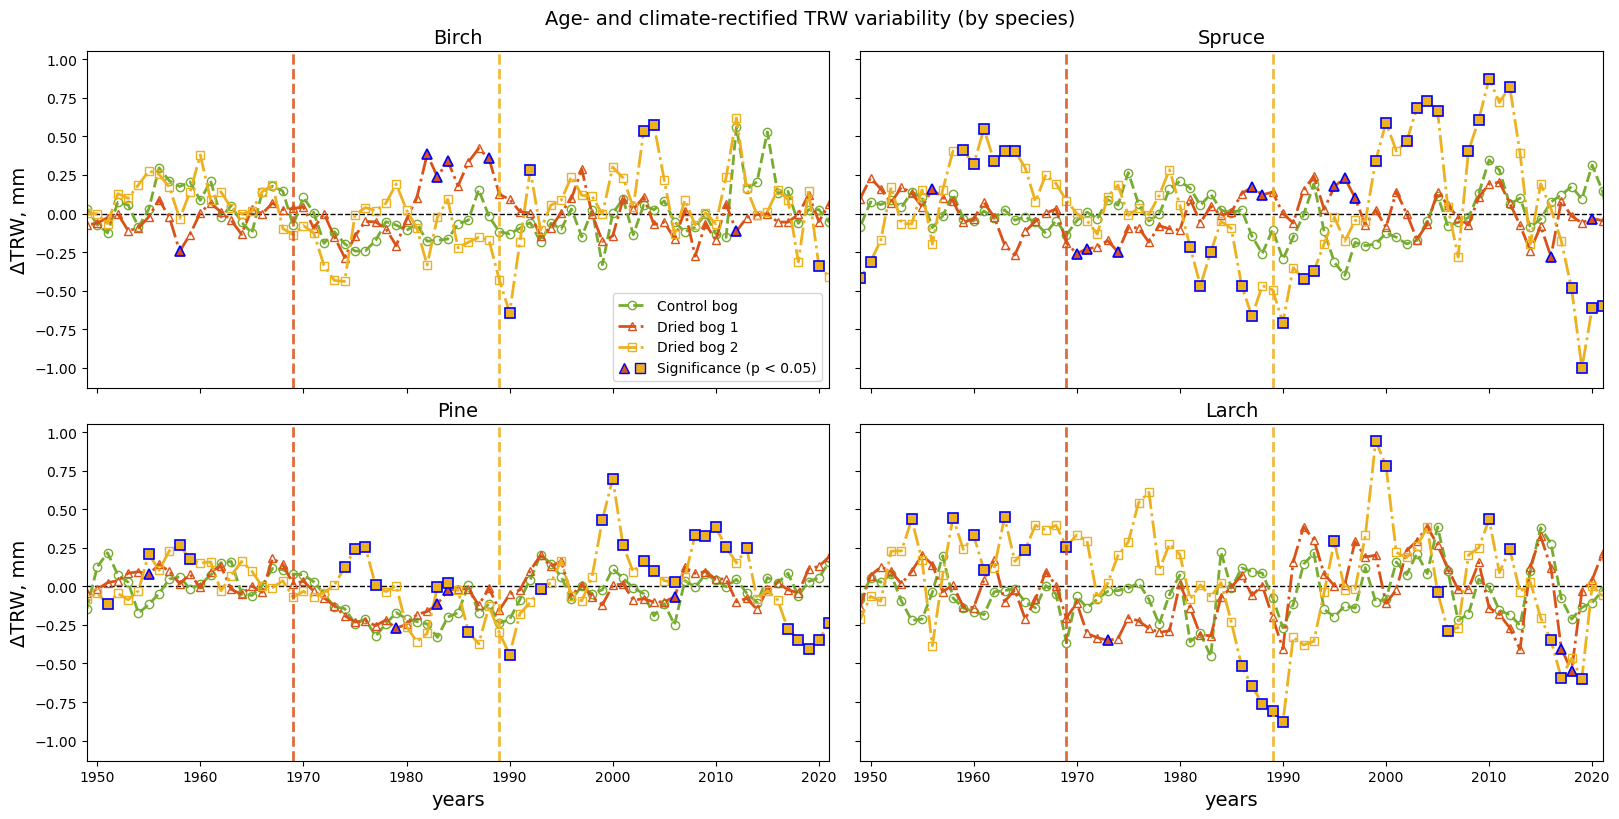

In [20]:
# (17) Climate-rectified TRW variability — cohort comparison
# --- INPUT:  X_reconstr_fluct (T×N), dates (T,), cohort & location labels
# --- OUTPUT: Figure_8_BN.pdf, TRW_8_BN.csv
# Rationale:
#   Mirror the trend visualization for the residual (stationary) variability with a zero baseline.

T = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

for ax, sp in zip(axes, SPEC_IDS):
    sel0 = (specium == sp) & (location == 1)
    sel1 = (specium == sp) & (location == 2)
    sel2 = (specium == sp) & (location == 3)

    y0 = row_nanmean(X_reconstr_fluct[:, sel0]) if sel0.any() else np.full(T, np.nan)
    y1 = row_nanmean(X_reconstr_fluct[:, sel1]) if sel1.any() else np.full(T, np.nan)
    y2 = row_nanmean(X_reconstr_fluct[:, sel2]) if sel2.any() else np.full(T, np.nan)

    ax.axhline(0.0, color='k', linestyle='--', linewidth=1)

    ax.plot(dates, y0, 'o--', linewidth=2, color=C0, markersize=6,
            markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])
    ax.plot(dates, y1, '^-.', linewidth=2, color=C1, markersize=6,
            markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])
    ax.plot(dates, y2, 's-.', linewidth=2, color=C2, markersize=6,
            markerfacecolor='none', markeredgecolor=C2, label=loc_names[2])

    # per-year tests vs Control
    P01 = pvals_by_year(X_reconstr_fluct, sel0, sel1, dates, method=TEST) if (sel0.any() and sel1.any()) else np.full(T, np.nan)
    P02 = pvals_by_year(X_reconstr_fluct, sel0, sel2, dates, method=TEST) if (sel0.any() and sel2.any()) else np.full(T, np.nan)
    sig1 = np.isfinite(P01) & (P01 < ALPHA)     
    sig2 = np.isfinite(P02) & (P02 < ALPHA)

    y1_sig = y1.copy(); y1_sig[~sig1] = np.nan
    y2_sig = y2.copy(); y2_sig[~sig2] = np.nan
    ax.plot(dates, y1_sig, linestyle='None', marker='^', markersize=7,
            markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2)
    ax.plot(dates, y2_sig, linestyle='None', marker='s', markersize=7,
            markerfacecolor=C2, markeredgecolor='b', markeredgewidth=1.2)

    mark_years(ax, MARK_YEARS, MARK_COLORS)
    if PLOT_YEARS is not None:
        apply_plot_years(ax, dates)
        
    title = spec_names[sp-1] if (sp-1) < len(spec_names) else f"Species {sp}"
    ax.set_title(title, fontsize=14);
    if (list(SPEC_IDS).index(sp) % 2) == 0:
        ax.set_ylabel('ΔTRW, mm', fontsize=14)
    if (list(SPEC_IDS).index(sp) // 2) == 1:
        ax.set_xlabel("years", fontsize=14)
    # [DIAG]
    # sig1_cnt = int(np.nansum(sig1)); sig2_cnt = int(np.nansum(sig2))
    # print(f"[DIAG][CLIM-FLUCT] Species {sp}: nC={sel0.sum()}, nD1={sel1.sum()}, nD2={sel2.sum()}, "
    #       f"sig(C vs D1)={sig1_cnt}, sig(C vs D2)={sig2_cnt} (TEST={TEST}, ALPHA={ALPHA})")

plt.suptitle('Age- and climate-rectified TRW variability (by species)', fontsize=14)

axes[0].legend([h0, h1, h2, sig],
               [loc_names[0], loc_names[1], loc_names[2], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)},
               loc='best')

if SAVE_OUTPUTS:
    plt.savefig(RESULTS / "Figure_8_BN.pdf", format="pdf")
    pd.DataFrame(X_reconstr_fluct).to_csv(RESULTS / "TRW_8_BN.csv", index=False, header=False)
plt.show()


In [21]:
# (18) Extract localized intervention trend (column-wise demeaning)
# --- INPUT:  X_reconstr_trend (T×N)
# --- OUTPUT: Xa_extr_trend (T×N), TRW_9_BN.csv
# Rationale:
#   Demean each tree’s residual trend to isolate within-tree, site-localized deviations.
#   Preserve NaNs and index alignment.

T, N = X_reconstr_trend.shape
col_means = np.nanmean(X_reconstr_trend, axis=0)            # (N,)
Xa_extr_trend = X_reconstr_trend - col_means[np.newaxis, :] # (T×N)

# [DIAG]
# diag_print("Xa_extr_trend (T x N)", Xa_extr_trend)

if SAVE_OUTPUTS:
    pd.DataFrame(Xa_extr_trend).to_csv(RESULTS / "TRW_9_BN.csv", index=False, header=False)


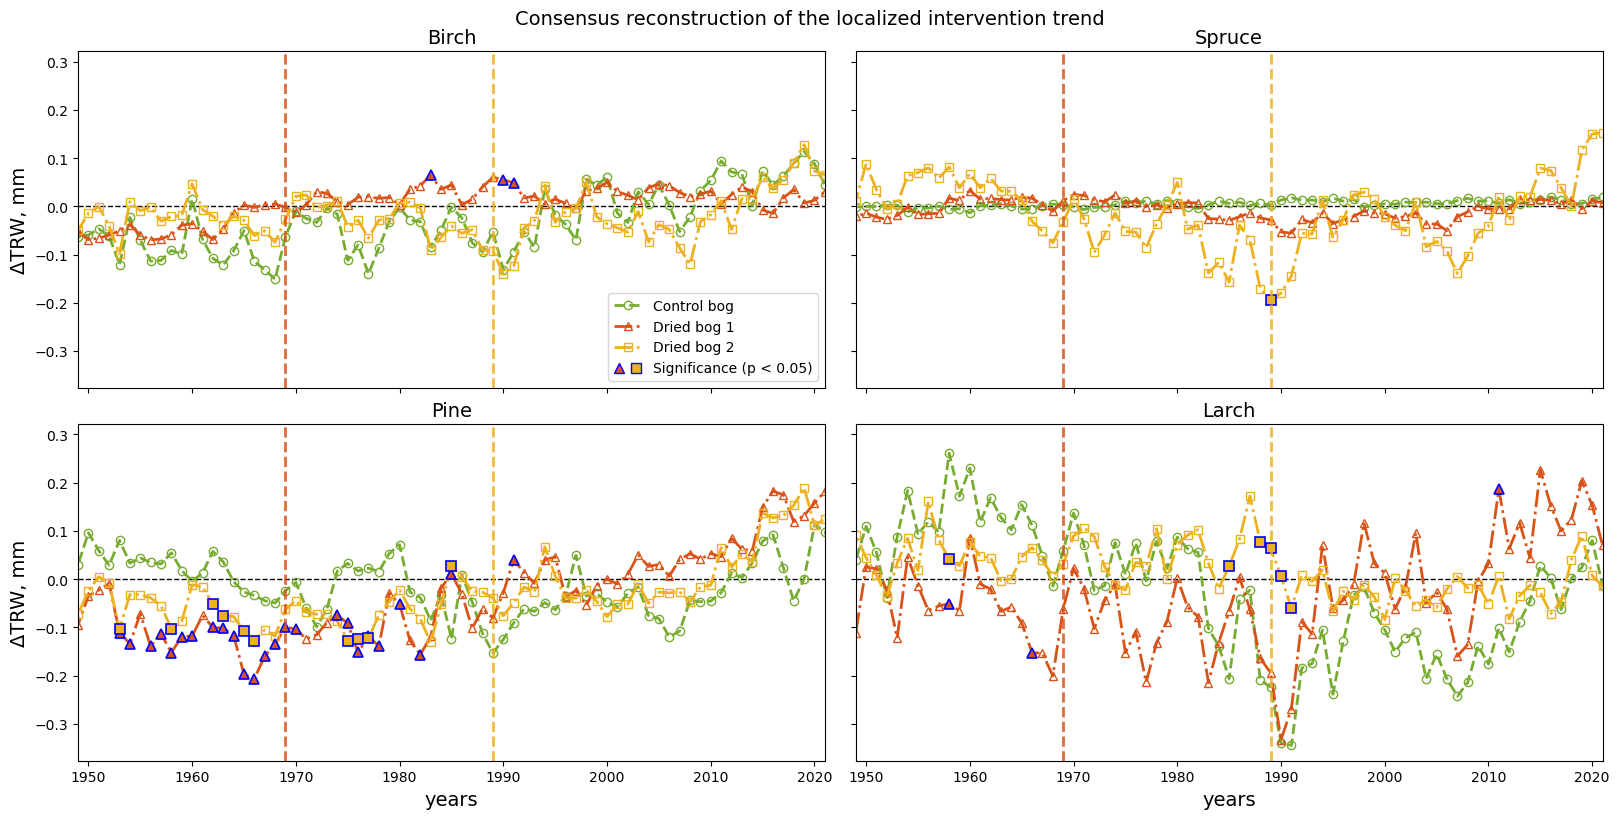

In [22]:
# (19) Localized intervention trend — cohort means with per-year tests
# --- INPUT:  Xa_extr_trend (T×N), dates (T,), cohort & location labels
# --- OUTPUT: Figure_9_BN.pdf
# Rationale:
#   Compare cohort means of localized trend and highlight years different from the reference group.

T = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

for ax, sp in zip(axes, SPEC_IDS):
    sel0 = (specium == sp) & (location == 1)  # Control
    sel1 = (specium == sp) & (location == 2)  # D1
    sel2 = (specium == sp) & (location == 3)  # D2

    y0 = row_nanmean(Xa_extr_trend[:, sel0]) if sel0.any() else np.full(T, np.nan)
    y1 = row_nanmean(Xa_extr_trend[:, sel1]) if sel1.any() else np.full(T, np.nan)
    y2 = row_nanmean(Xa_extr_trend[:, sel2]) if sel2.any() else np.full(T, np.nan)

    ax.axhline(0.0, color='k', linestyle='--', linewidth=1)

    ax.plot(dates, y0, 'o--', linewidth=2, markersize=6, color=C0,
            markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])
    ax.plot(dates, y1, '^-.', linewidth=2, markersize=6, color=C1,
            markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])
    ax.plot(dates, y2, 's-.', linewidth=2, markersize=6, color=C2,
            markerfacecolor='none', markeredgecolor=C2, label=loc_names[2])

    P12 = pvals_by_year(Xa_extr_trend, sel0, sel1, dates, method=TEST)
    P13 = pvals_by_year(Xa_extr_trend, sel0, sel2, dates, method=TEST)
    sig12 = np.isfinite(P12) & (P12 < ALPHA)  
    sig13 = np.isfinite(P13) & (P13 < ALPHA)

    y1_sig = y1.copy(); y1_sig[~sig12] = np.nan
    y2_sig = y2.copy(); y2_sig[~sig13] = np.nan
    ax.plot(dates, y1_sig, linestyle='None', marker='^', markersize=7,
            markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2)
    ax.plot(dates, y2_sig, linestyle='None', marker='s', markersize=7,
            markerfacecolor=C2, markeredgecolor='b', markeredgewidth=1.2)

    mark_years(ax, MARK_YEARS, MARK_COLORS)
    if PLOT_YEARS is not None:
        apply_plot_years(ax, dates)

    title = spec_names[sp-1] if (sp-1) < len(spec_names) else f"Species {sp}"
    ax.set_title(title, fontsize=14);
    if (list(SPEC_IDS).index(sp) % 2) == 0:
        ax.set_ylabel('ΔTRW, mm', fontsize=14)
    if (list(SPEC_IDS).index(sp) // 2) == 1:
        ax.set_xlabel("years", fontsize=14)
    # [DIAG]
    # sig1_cnt = int(np.nansum(sig1)); sig2_cnt = int(np.nansum(sig2))
    # print(f"[DIAG][CLIM-TREND] Species {sp}: nC={sel0.sum()}, nD1={sel1.sum()}, nD2={sel2.sum()}, "
    #       f"sig(C vs D1)={sig1_cnt}, sig(C vs D2)={sig2_cnt} (TEST={TEST}, ALPHA={ALPHA})")

plt.suptitle('Consensus reconstruction of the localized intervention trend', fontsize=14)

axes[0].legend([h0, h1, h2, sig],
               [loc_names[0], loc_names[1], loc_names[2], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)},
               loc='best')

if SAVE_OUTPUTS:
    plt.savefig(RESULTS / "Figure_9_BN.pdf", format="pdf")
plt.show()


In [23]:
# (20) Extract localized intervention fluctuations (column-wise demeaning)
# --- INPUT:  X_reconstr_fluct (T×N)
# --- OUTPUT: Xa_extr_fluct (T×N), TRW_10_BN.csv
# Rationale:
#   Demean each tree’s residual variability to obtain within-tree localized fluctuations.

T, N = X_reconstr_fluct.shape
mu_fluct = np.nanmean(X_reconstr_fluct, axis=0)          # (N,)
Xa_extr_fluct = X_reconstr_fluct - mu_fluct[None, :]     # (T×N), NaNs preserved

# [DIAG]
# diag_print("Xa_extr_fluct (T x N)", Xa_extr_fluct)

if SAVE_OUTPUTS:
    pd.DataFrame(Xa_extr_fluct).to_csv(RESULTS / "TRW_10_BN.csv", index=False, header=False)


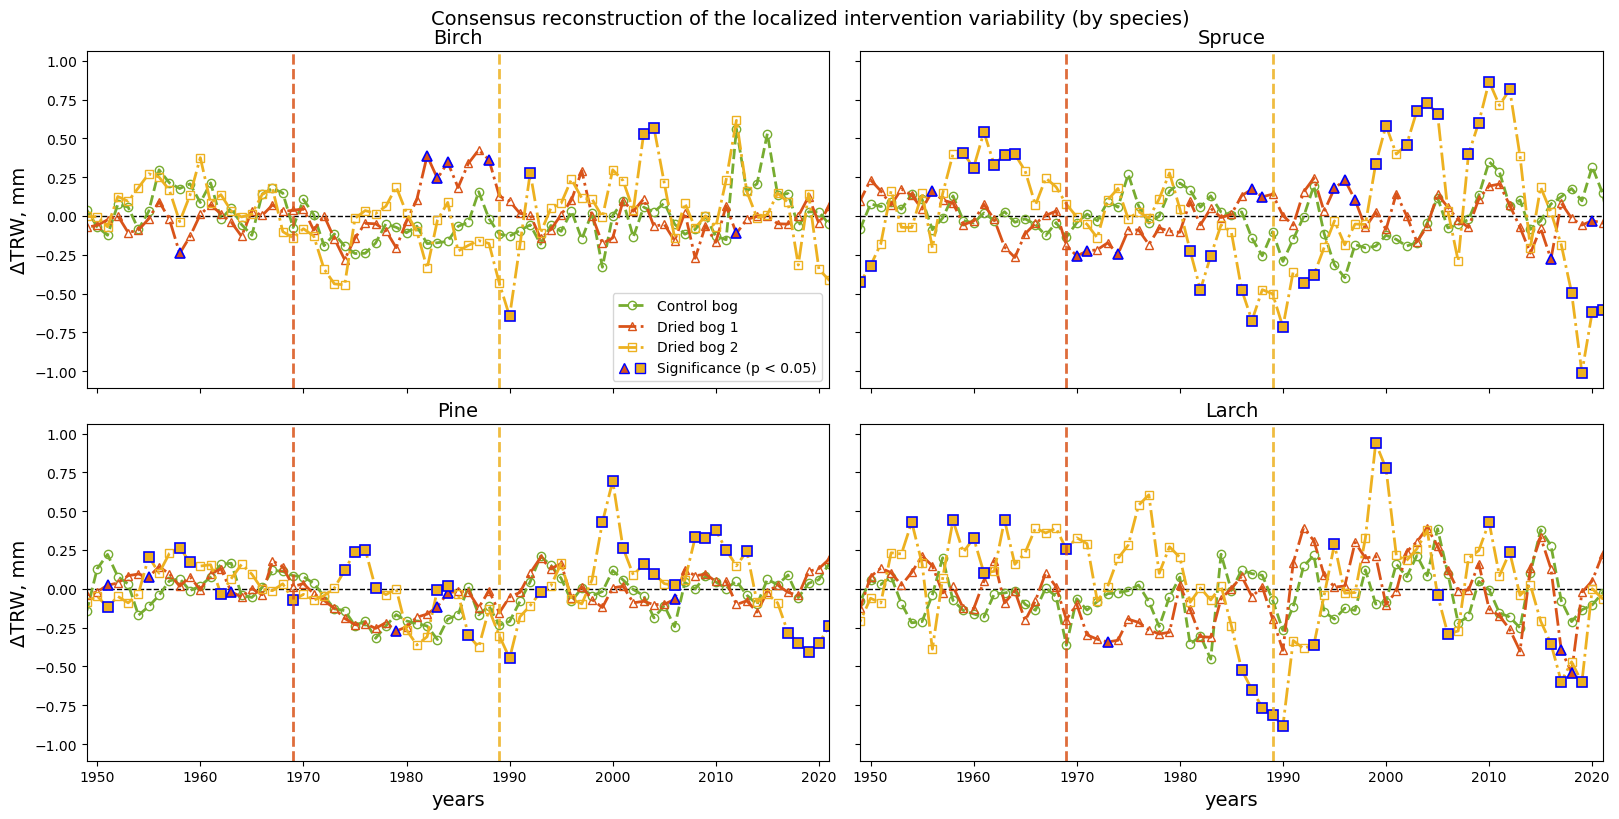

In [24]:
# (21) Localized intervention variability — cohort means with per-year tests
# --- INPUT:  Xa_extr_fluct (T×N), dates (T,), cohort & location labels
# --- OUTPUT: Figure_10_BN.pdf
# Rationale:
#   Plot cohort means of localized variability and mark years different from the reference cohort.

T = len(dates)

fig, axes = plt.subplots(2, 2, figsize=(16, 8), sharex=True, sharey=True, constrained_layout=True)
axes = axes.ravel()
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

for ax, sp in zip(axes, SPEC_IDS):
    sel0 = (specium == sp) & (location == 1)
    sel1 = (specium == sp) & (location == 2)
    sel2 = (specium == sp) & (location == 3)

    y0 = row_nanmean(Xa_extr_fluct[:, sel0]) if sel0.any() else np.full(T, np.nan)
    y1 = row_nanmean(Xa_extr_fluct[:, sel1]) if sel1.any() else np.full(T, np.nan)
    y2 = row_nanmean(Xa_extr_fluct[:, sel2]) if sel2.any() else np.full(T, np.nan)

    ax.axhline(0.0, color='k', linestyle='--', linewidth=1)
    
    ax.plot(dates, y0, 'o--', linewidth=2, color=C0, markersize=6,
            markerfacecolor='none', markeredgecolor=C0, label=loc_names[0])
    ax.plot(dates, y1, '^-.', linewidth=2, color=C1, markersize=6,
            markerfacecolor='none', markeredgecolor=C1, label=loc_names[1])
    ax.plot(dates, y2, 's-.', linewidth=2, color=C2, markersize=6,
            markerfacecolor='none', markeredgecolor=C2, label=loc_names[2])

    P01 = pvals_by_year(Xa_extr_fluct, sel0, sel1, dates, method=TEST) if (sel0.any() and sel1.any()) else np.full(T, np.nan)
    P02 = pvals_by_year(Xa_extr_fluct, sel0, sel2, dates, method=TEST) if (sel0.any() and sel2.any()) else np.full(T, np.nan)
    sig1 = np.isfinite(P01) & (P01 < ALPHA)
    sig2 = np.isfinite(P02) & (P02 < ALPHA)

    y1_sig = y1.copy(); y1_sig[~sig1] = np.nan
    y2_sig = y2.copy(); y2_sig[~sig2] = np.nan
    ax.plot(dates, y1_sig, linestyle='None', marker='^', markersize=7,
            markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2)
    ax.plot(dates, y2_sig, linestyle='None', marker='s', markersize=7,
            markerfacecolor=C2, markeredgecolor='b', markeredgewidth=1.2)

    mark_years(ax, MARK_YEARS, MARK_COLORS)
    if PLOT_YEARS is not None:
        apply_plot_years(ax, dates)

    title = spec_names[sp-1] if (sp-1) < len(spec_names) else f"Species {sp}"
    ax.set_title(title, fontsize=14);
    if (list(SPEC_IDS).index(sp) % 2) == 0:
        ax.set_ylabel('ΔTRW, mm', fontsize=14)
    if (list(SPEC_IDS).index(sp) // 2) == 1:
        ax.set_xlabel("years", fontsize=14)
    # [DIAG]
    # sig1_cnt = int(np.nansum(sig1)); sig2_cnt = int(np.nansum(sig2))
    # print(f"[DIAG][CLIM-FLUCT] Species {sp}: nC={sel0.sum()}, nD1={sel1.sum()}, nD2={sel2.sum()}, "
    #       f"sig(C vs D1)={sig1_cnt}, sig(C vs D2)={sig2_cnt} (TEST={TEST}, ALPHA={ALPHA})")

plt.suptitle('Consensus reconstruction of the localized intervention variability (by species)', fontsize=14)

axes[0].legend([h0, h1, h2, sig],
               [loc_names[0], loc_names[1], loc_names[2], f"Significance (p < {ALPHA:g})"],
               handler_map={tuple: HandlerTuple(ndivide=None)},
               loc='best')

if SAVE_OUTPUTS:
    plt.savefig(RESULTS / "Figure_10_BN.pdf", format="pdf")
plt.show()


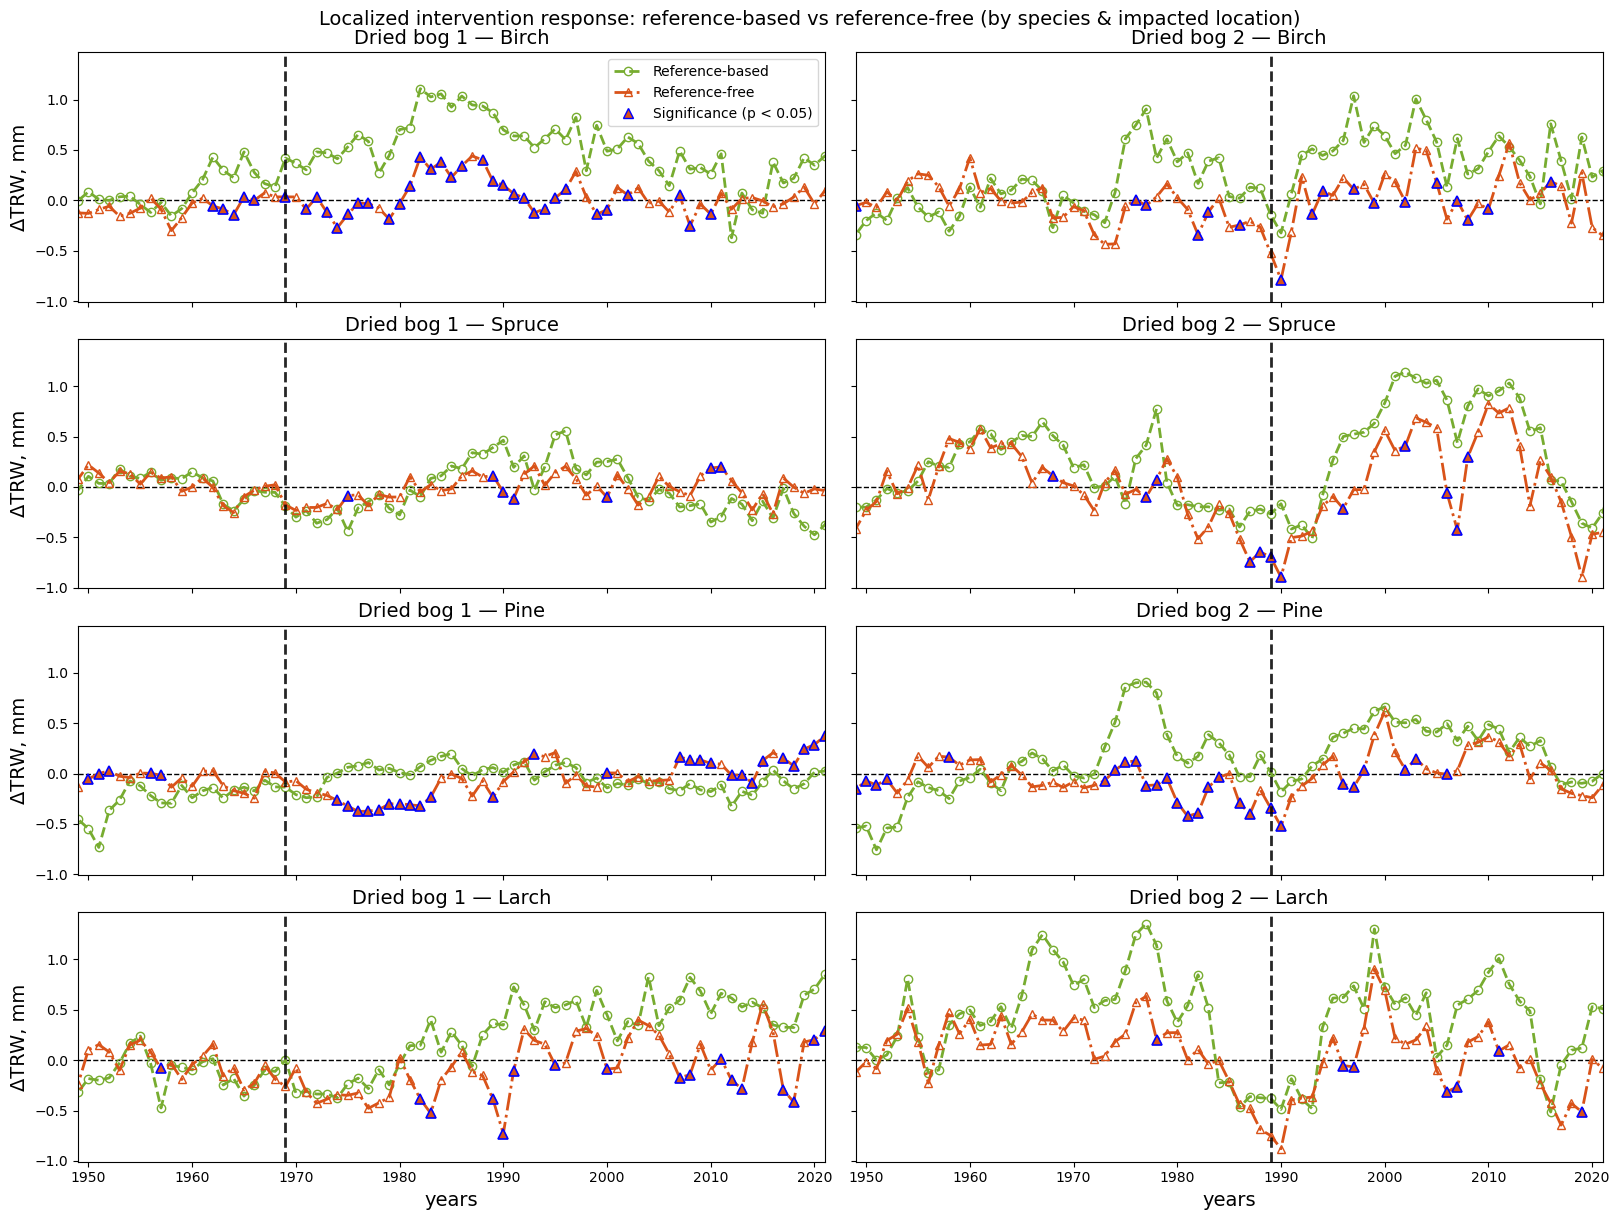

Dried bog 1 --- Birch
    C_aver    C_spec    C_unspec  C_sp/C_unsp
     0.6354     0.8785     0.1714     5.1240

Dried bog 1 --- Spruce
    C_aver    C_spec    C_unspec  C_sp/C_unsp
     0.5344     0.8727     0.2129     4.0984

Dried bog 1 --- Pine
    C_aver    C_spec    C_unspec  C_sp/C_unsp
    -0.0246     0.6762     0.1848     3.6588

Dried bog 1 --- Larch
    C_aver    C_spec    C_unspec  C_sp/C_unsp
     0.4458     0.7842     0.1796     4.3652

Dried bog 2 --- Birch
    C_aver    C_spec    C_unspec  C_sp/C_unsp
     0.4935     0.8375     0.2327     3.5995

Dried bog 2 --- Spruce
    C_aver    C_spec    C_unspec  C_sp/C_unsp
     0.7922     0.8774     0.3224     2.7211

Dried bog 2 --- Pine
    C_aver    C_spec    C_unspec  C_sp/C_unsp
     0.4022     0.7655     0.2054     3.7264

Dried bog 2 --- Larch
    C_aver    C_spec    C_unspec  C_sp/C_unsp
     0.7967     0.9108     0.2034     4.4789



In [25]:
# (22) Control-based vs reference-free estimates — species × impacted locations
# --- INPUT:  data (T×N), Xa_extr_trend (T×N), Xa_extr_fluct (T×N), dates (T,), specium (N,), location (N,), TEST, ALPHA
# --- OUTPUT: TRW_11_BN.csv, TRW_11_BN_data_ctrl.csv, Figure_11_BN.pdf
# Rationale:
#   Build two comparators per impacted location: (i) reference-based = impacted − mean(Control), (ii) reference-free = mean(Xa_extr_trend + Xa_extr_fluct).
#   Test year-wise divergence and overlay significance; compute tail-period correlations (C_aver, C_spec, |C_unspec|, ratio).
#   Save both the comparison plots and the derived matrices for audit and replication.

T, N = data.shape
imp_locs  = [2, 3]
tail_year = 1951
ix = np.flatnonzero(dates == tail_year)
tail_start = int(ix[0])
# [DIAG]
# print(f"[DIAG][CTRL] tail_start: idx={tail_start}, year={int(dates[tail_start])}")

Xa_extr = Xa_extr_trend + Xa_extr_fluct
legend_names = ["Reference-based", "Reference-free"]

fig, axes = plt.subplots(len(SPEC_IDS), len(imp_locs), figsize=(16, 12),
                         sharex=True, sharey=True, constrained_layout=True)
axes = np.atleast_2d(axes)
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0.02, hspace=0.02)

global_vals = [] 

ctrl_lines, corr_lines = [], []
summary_vals = {loc_id: {} for loc_id in imp_locs}
data_ctrl = np.full_like(data, np.nan)

for i, sp in enumerate(SPEC_IDS):
    sel_ctrl = (specium == sp) & (location == 1)
    ctrl_mean = row_nanmean(data[:, sel_ctrl])[:, None] if sel_ctrl.any() else np.full((T, 1), np.nan)

    if sel_ctrl.any():
        data_ctrl[:, sel_ctrl] = data[:, sel_ctrl] - ctrl_mean

    for j, loc_id in enumerate(imp_locs):
        ax = axes[i, j]
        sel_imp = (specium == sp) & (location == loc_id)

        y_refbased = row_nanmean(data[:, sel_imp] - ctrl_mean) if (sel_ctrl.any() and sel_imp.any()) else np.full(T, np.nan)
        y_reffree  = row_nanmean(Xa_extr[:, sel_imp]) if sel_imp.any() else np.full(T, np.nan)

        ax.axhline(0.0, color='k', linestyle='--', linewidth=1)
        
        ax.plot(dates, y_refbased, 'o--', linewidth=2, color=C0, markersize=6,
                markerfacecolor='none', markeredgecolor=C0, label=legend_names[0])
        ax.plot(dates, y_reffree,  '^-.', linewidth=2, color=C1, markersize=6,
                markerfacecolor='none', markeredgecolor=C1, label=legend_names[1])

        # per-year p-values
        Pval = np.full(T, np.nan)
        if sel_ctrl.any() and sel_imp.any():
            naive_vecs = data[:, sel_imp] - ctrl_mean
            recon_vecs = Xa_extr[:, sel_imp]
            for ti in range(T):
                x = naive_vecs[ti, :]
                y = recon_vecs[ti, :]
                m = np.isfinite(x) & np.isfinite(y)
                if m.sum() >= 1 and np.isfinite(ctrl_mean[ti, 0]):
                    Pval[ti] = pval_two_group(x[m], y[m], method=TEST)

        sig_mask = np.isfinite(Pval) & (Pval < ALPHA)
        y_rf_sig = y_reffree.copy(); y_rf_sig[~sig_mask] = np.nan
        ax.plot(dates, y_rf_sig, linestyle='None', marker='^', markersize=7,
                markerfacecolor=C1, markeredgecolor='b', markeredgewidth=1.2)

        if loc_id == 2:
            mark_years(ax, (MARK_YEARS[0],),
                       colors=(BLACK_COLOUR if isinstance(BLACK_COLOUR, str) else (BLACK_COLOUR[0],)))
        else:  # loc_id == 3
            y2 = MARK_YEARS[1] if (hasattr(MARK_YEARS, '__len__') and len(MARK_YEARS) > 1) else MARK_YEARS[0]
            c2 = (BLACK_COLOUR if isinstance(BLACK_COLOUR, str)
                  else (BLACK_COLOUR[1] if (hasattr(BLACK_COLOUR, '__len__') and len(BLACK_COLOUR) > 1) else BLACK_COLOUR[0]))
            mark_years(ax, (y2,), colors=(c2,))

        valid = np.isfinite(y_refbased) | np.isfinite(y_reffree)
        if PLOT_YEARS is not None:
            apply_plot_years(ax, dates); ax.autoscale(enable=False, axis='x')
        else:
            if valid.any():
                yrs = dates[valid]; ax.set_xlim(yrs.min()-1, yrs.max()+1)

        x0, x1 = ax.get_xlim()
        if valid.any():
            idx = (dates >= x0) & (dates <= x1)
            vals = np.r_[y_refbased[idx], y_reffree[idx]]
            vals = vals[np.isfinite(vals)]
            if vals.size:
                global_vals.append(vals)

        title = f"{loc_names[loc_id-1]} — {spec_names[sp-1]}" if (sp-1) < len(spec_names) else f"{loc_names[loc_id-1]} — Species {sp}"
        ax.set_title(title, fontsize=14);
        if j == 0:
            ax.set_ylabel("ΔTRW, mm", fontsize=14)
        if i == len(SPEC_IDS) - 1:
            ax.set_xlabel("years", fontsize=14)

        ctrl_lines.append(
            f"[DIAG][CTRL] Species {sp} [{loc_names[loc_id-1]}]: "
            f"n_ctrl={sel_ctrl.sum()}, n_imp={sel_imp.sum()}, significant years = {int(np.nansum(sig_mask))} (ALPHA={ALPHA})"
        )

        # tail correlations
        c_aver = np.nan; med_diag = np.nan; med_off = np.nan; ratio = np.nan
        if sel_ctrl.any() and sel_imp.any():
            A = (data[:, sel_imp] - ctrl_mean)[tail_start:, :]
            B = Xa_extr[:, sel_imp][tail_start:, :]
            if A.size and B.size:
                m_imp = A.shape[1]
                C = np.full((m_imp, m_imp), np.nan)
                for ii in range(m_imp):
                    ai = A[:, ii]
                    for jj in range(m_imp):
                        bj = B[:, jj]
                        mask = np.isfinite(ai) & np.isfinite(bj)
                        if mask.sum() >= 2:
                            C[ii, jj] = pearsonr(ai[mask], bj[mask]).statistic

                c_aver = corr_1d_pairwise(y_refbased[tail_start:], y_reffree[tail_start:])
                diag_vals = np.diag(C)
                off_vals  = np.abs(C[~np.eye(C.shape[0], dtype=bool)])
                med_diag  = np.nanmedian(diag_vals) if diag_vals.size else np.nan
                med_off   = np.nanmedian(off_vals)  if off_vals.size  else np.nan
                ratio     = (med_diag / med_off) if np.isfinite(med_diag) and np.isfinite(med_off) and med_off != 0 else np.nan

                corr_lines.append(
                    f"[DIAG][CTRL][corr] Species {sp} [{loc_names[loc_id-1]}] (tail_year={int(tail_year)}): "
                    f"C_aver={c_aver:.4f}, med(diag)={med_diag:.4f}, med(|off|)={med_off:.4f}, ratio={ratio:.4f}"
                )

        summary_vals[loc_id][sp] = (c_aver, med_diag, med_off, ratio)

        if sel_ctrl.any():
            data_ctrl[:, sel_imp] = data[:, sel_imp] - ctrl_mean

if global_vals:
    all_vals = np.concatenate(global_vals)
    ymin, ymax = float(np.nanmin(all_vals)), float(np.nanmax(all_vals))
    pad = 0.05 * max(1.0, ymax - ymin)
    for ax in axes.ravel():
        ax.set_ylim(ymin - pad, ymax + pad)

axes[0, 0].legend([h0, h1, Line2D([], [], ls="None", marker="^", color="b", mfc=C1, mec="b", ms=7)],
                  [legend_names[0], legend_names[1], f"Significance (p < {ALPHA:g})"],
                  handler_map={tuple: HandlerTuple(ndivide=None)},
                  loc="best")

plt.suptitle("Localized intervention response: reference-based vs reference-free (by species & impacted location)", fontsize=14)
if SAVE_OUTPUTS:
    plt.savefig(RESULTS / "Figure_11_BN.pdf", format="pdf") 
plt.show()

for loc_id in [2, 3]:
    for sp in [1, 2, 3, 4]:
        loc_title = loc_names[loc_id-1]
        sp_title  = spec_names[sp-1] if (sp-1) < len(spec_names) else f"Species {sp}"
        print(f"{loc_title} --- {sp_title}")
        print("    C_aver    C_spec    C_unspec  C_sp/C_unsp")
        if sp in summary_vals[loc_id]:
            c_aver, med_diag, med_off, ratio = summary_vals[loc_id][sp]
            print(f"    {c_aver:7.4f}    {med_diag:7.4f}    {med_off:7.4f}    {ratio:7.4f}\n")
        else:
            print("    NaN       NaN       NaN       NaN\n")

_rows = []
for loc_id in [2, 3]:
    loc_title = loc_names[loc_id-1]
    for sp in [1, 2, 3, 4]:
        sp_title = spec_names[sp-1] if (sp-1) < len(spec_names) else f"Species {sp}"
        if sp in summary_vals[loc_id]:
            c_aver, med_diag, med_off, ratio = summary_vals[loc_id][sp]
        else:
            c_aver = med_diag = med_off = ratio = np.nan
        _rows.append({
            "Location": loc_title,
            "Species": sp_title,
            "C_aver": c_aver,
            "C_spec": med_diag,
            "C_unspec": med_off,
            "C_sp/C_unsp": ratio
        })
if SAVE_OUTPUTS:
    pd.DataFrame(_rows, columns=["Location","Species","C_aver","C_spec","C_unspec","C_sp/C_unsp"]).to_csv(RESULTS / "TRW_11_BN_table.csv", index=False)
    pd.DataFrame(Xa_extr).to_csv(RESULTS / "TRW_11_BN.csv", index=False, header=False)
    pd.DataFrame(data_ctrl).to_csv(RESULTS / "TRW_11_BN_data_ctrl.csv", index=False, header=False)
    
# [DIAG]
# for line in ctrl_lines: print(line)
# for line in corr_lines: print(line)

In [26]:
# (23) Window index construction + plot-range helpers
# --- INPUT:  dates (T,), PLOT_YEARS, APPLY_PLOT_YEARS_TO_WINDOWS
# --- OUTPUT: first_years (F,), last_years (Lw,), fi_pos_view (≤F), li_pos_view (≤Lw)
# Rationale:
#   Construct canonical local-trend windows as grids of start/end years (monotone indices).
#   Optionally restrict computation to PLOT_YEARS; always clip visualization via position slices.
#   Provide helpers to set human-readable tick labels and to draw location-specific guide lines.

def _idx_of_year(dates_arr: np.ndarray, year: int) -> int:
    idx = np.where(np.asarray(dates_arr, int) == int(year))[0]
    if idx.size == 0:
        raise ValueError(f"Year {year} not found in `dates`.")
    return int(idx[0])

# Fixed anchors (calendar years)
i1910 = _idx_of_year(dates, 1910)
i2018 = _idx_of_year(dates, 2018)
i1914 = _idx_of_year(dates, 1914)
i2022 = _idx_of_year(dates, 2022)

first_years_full = np.arange(i1910, i2018 + 1, dtype=int)  # start indices
last_years_full  = np.arange(i1914, i2022 + 1, dtype=int)  # end   indices

def _clip_indices_to_plot_years(first_idx, last_idx, dates_arr, plot_years):
    if plot_years is None:
        return first_idx, last_idx
    lo, hi = map(int, plot_years)
    fi_mask = (dates_arr[first_idx] >= lo) & (dates_arr[first_idx] <= hi)
    li_mask = (dates_arr[last_idx]  >= lo) & (dates_arr[last_idx]  <= hi)
    return first_idx[fi_mask], last_idx[li_mask]

def _view_positions_from_plot_years(first_idx, last_idx, dates_arr, plot_years):
    """Return 0-based *positions* into first/last arrays to slice heatmaps."""
    F = len(first_idx); Lw = len(last_idx)
    if plot_years is None:
        return np.arange(F, dtype=int), np.arange(Lw, dtype=int)
    lo, hi = map(int, plot_years)
    fi_pos = np.flatnonzero((dates_arr[first_idx] >= lo) & (dates_arr[first_idx] <= hi)).astype(int)
    li_pos = np.flatnonzero((dates_arr[last_idx]  >= lo) & (dates_arr[last_idx]  <= hi)).astype(int)
    if fi_pos.size == 0: fi_pos = np.arange(F, dtype=int)
    if li_pos.size == 0: li_pos = np.arange(Lw, dtype=int)
    return fi_pos, li_pos

# Decide computation vs visualization domains
if APPLY_PLOT_YEARS_TO_WINDOWS and (PLOT_YEARS is not None):
    first_years, last_years = _clip_indices_to_plot_years(first_years_full, last_years_full, dates, PLOT_YEARS)
else:
    first_years, last_years = first_years_full, last_years_full

# Positions for heatmap views (always clip visually by PLOT_YEARS)
fi_pos_view, li_pos_view = _view_positions_from_plot_years(first_years, last_years, dates, PLOT_YEARS)

# [DIAG]
# print(f"[DIAG] first_years: n={first_years.size}, years=[{int(dates[first_years[0]])}..{int(dates[first_years[-1]])}]")
# print(f"[DIAG]  last_years: n={last_years.size},  years=[{int(dates[last_years[0]])}..{int(dates[last_years[-1]])}]")
# print(f"[DIAG] windows monotonic: first={bool(np.all(np.diff(first_years)>0))}, last={bool(np.all(np.diff(last_years)>0))}")
# if PLOT_YEARS is not None:
#     print(f"[DIAG] view positions: |fi|={fi_pos_view.size}, |li|={li_pos_view.size}")


In [27]:
# (24) Monte-Carlo slope/scale statistics for fGn-like signals (H=1.0)
# --- INPUT:  first_years (F,), last_years (Lw,)
# --- OUTPUT: X_norm_H1_std (Lw×F)
# Rationale:
#   Generate fractional-Gaussian-noise-like surrogates (H=1.0), fit per-window OLS slopes, and normalize by residual σ.
#   Aggregate Δ/σ over many realizations to estimate a robust scale map by window length.

N = 64
L = N * 1024
H = 1.0
K = (H - 0.5) * (np.arange(1, L + 1, dtype=float) ** (H - 1.5))

max_len = (last_years[-1] - first_years[0] + 1)
L_years = np.arange(5, max_len + 1, dtype=int)

try:
    from scipy.signal import fftconvolve
    _use_fft = True
except Exception:
    _use_fft = False

print(f"_use_fft = {_use_fft}")

rng = np.random.default_rng(0)
Signal0 = np.empty((L, N), dtype=float)
for n in range(N):
    x = rng.standard_normal(L)
    y = fftconvolve(x, K, mode="full")[:L] if _use_fft else np.convolve(x, K, mode="full")[:L]
    Signal0[:, n] = y

X_signal = [None] * len(L_years)
X_norm_H1_std = np.full((last_years.size, first_years.size), np.nan)

for j, Lw in enumerate(L_years):
    total_rows = (Signal0.shape[0] // Lw) * Lw
    if total_rows == 0:
        X_signal[j] = np.array([], dtype=float)
        continue
    S = Signal0[:total_rows, :]
    S = np.reshape(S, (Lw, -1), order="F")  # (Lw × nBlocks*N)

    # OLS for each stacked column
    x = np.arange(1, Lw + 1, dtype=float)[:, None]
    xbar = float(x.mean())
    var_x = float(np.sum((x - xbar) ** 2))
    ybar  = S.mean(axis=0)
    cov_xy = (x - xbar).T @ (S - ybar)
    b = cov_xy.ravel() / var_x
    a = ybar - b * xbar
    yhat = a[None, :] + b[None, :] * x

    R = S - yhat
    sigma = np.std(R, axis=0, ddof=1)
    Delta = (yhat[-1, :] - yhat[0, :]) / max(Lw - 1, 1)

    with np.errstate(divide='ignore', invalid='ignore'):
        X_signal[j] = Delta / sigma

    print(f"Computed statistics for window length L = {Lw}")

# Aggregate by (last, first) positions
for fi, f_idx in enumerate(first_years):
    for li in range(fi, last_years.size):
        Lw = (last_years[li] - f_idx + 1)
        j = Lw - L_years[0]
        if 0 <= j < len(L_years) and X_signal[j] is not None and X_signal[j].size:
            X_norm_H1_std[li, fi] = np.std(X_signal[j], ddof=1)
print(f"H={H:.1f}, N={N}, L={L}, |L_years|={L_years.size}")
# [DIAG]
# if X_norm_H1_std.size:
#     p5, p50, p95 = np.percentile(X_norm_H1_std, [5, 50, 95])
#     print(f"[DIAG][B2] X_norm_H1_std percentiles: p5={p5:.3f}, median={p50:.3f}, p95={p95:.3f}")
# print(f"[DIAG][B2] X_signal cells = {len(X_signal)}, L_years range = [{L_years[0]}..{L_years[-1]}]")


_use_fft = True
Computed statistics for window length L = 5
Computed statistics for window length L = 6
Computed statistics for window length L = 7
Computed statistics for window length L = 8
Computed statistics for window length L = 9
Computed statistics for window length L = 10
Computed statistics for window length L = 11
Computed statistics for window length L = 12
Computed statistics for window length L = 13
Computed statistics for window length L = 14
Computed statistics for window length L = 15
Computed statistics for window length L = 16
Computed statistics for window length L = 17
Computed statistics for window length L = 18
Computed statistics for window length L = 19
Computed statistics for window length L = 20
Computed statistics for window length L = 21
Computed statistics for window length L = 22
Computed statistics for window length L = 23
Computed statistics for window length L = 24
Computed statistics for window length L = 25
Computed statistics for window length L = 26

In [28]:
# (25) Local-window slopes and cross-cohort correlations (reference-based vs reference-free)
# --- INPUT:  data_ctrl (T×N), Xa_extr (T×N), specium (N,), location (N,), first_years (F,), last_years (Lw,)
# --- OUTPUT: X_trees_ref (Lw×F×N), X_trees_nov (Lw×F×N),
#             C_trees_aver/spec/unspec/ratio (Lw×F×|S|×|Loc|)
# Rationale:
#   Compute per-tree normalized slopes (Δ/σ) within each window for both approaches (reference-based, reference-free).
#   Summarize correlations between averaged cohort series (C_aver), same-tree pairs (C_spec), and cross-tree pairs (C_unspec).
#   Record the robustness ratio median(C_spec)/median(|C_unspec|) to evaluate signal specificity.

T, N_trees = data_ctrl.shape
u_spec = np.unique(specium[np.isfinite(specium)]).astype(int)
u_loc  = np.unique(location[np.isfinite(location)]).astype(int)
spec_to_i = {s: i for i, s in enumerate(u_spec)}
loc_to_i  = {l: i for i, l in enumerate(u_loc)}
S, Lc = len(u_spec), len(u_loc)
F, Lw = len(first_years), len(last_years)

X_trees_ref    = np.full((Lw, F, N_trees), np.nan)
X_trees_nov    = np.full((Lw, F, N_trees), np.nan)
C_trees_aver   = np.full((Lw, F, S, Lc), np.nan)
C_trees_spec   = np.full((Lw, F, S, Lc), np.nan)
C_trees_unspec = np.full((Lw, F, S, Lc), np.nan)
C_trees_ratio  = np.full((Lw, F, S, Lc), np.nan)

cohorts = []
for s in u_spec:
    for l in u_loc:
        idx_cols = np.flatnonzero((specium == s) & (location == l))
        if idx_cols.size:
            cohorts.append((spec_to_i[s], loc_to_i[l], idx_cols))

def _ols_win_norm(Ywin: np.ndarray, require_full: bool = True):
    """Per-column OLS over rows of Ywin, returning (yhat, Δ, σ, Δ/σ)."""
    Y = np.asarray(Ywin, float)                 # (Lr × N)
    W = np.isfinite(Y).astype(float)
    x = np.arange(Y.shape[0], dtype=float)      # 0..Lr-1
    S   = W.sum(0);   Sx  = x @ W;   Sxx = (x**2) @ W
    Yz  = np.nan_to_num(Y) * W
    Sy  = Yz.sum(0);  Sxy = (x[:, None] * Yz).sum(0)
    denom = (S * Sxx - Sx**2)

    if require_full:
        good = (S == Y.shape[0]) & (denom > 0)
    else:
        good = (S >= 2) & (denom > 0)

    a = np.full(Y.shape[1], np.nan)
    b = np.full(Y.shape[1], np.nan)
    a[good] = (Sy[good] * Sxx[good] - Sx[good] * Sxy[good]) / denom[good]
    b[good] = (S[good] * Sxy[good] - Sx[good] * Sy[good]) / denom[good]

    yhat = np.full_like(Y, np.nan)
    if good.any():
        yhat[:, good] = a[good][None, :] + b[good][None, :] * x[:, None]

    Sigma = np.full(Y.shape[1], np.nan)
    if good.any():
        R  = np.where(np.isfinite(Y), Y - yhat, np.nan)
        ss = np.nansum(R**2, axis=0)
        dof = np.maximum(S - 1, 1)
        with np.errstate(invalid='ignore', divide='ignore'):
            Sigma[good] = np.sqrt(ss[good] / dof[good])
        Sigma[Sigma <= 0] = np.nan

    Delta = np.full(Y.shape[1], np.nan)
    if good.any():
        Delta[good] = (yhat[-1, good] - yhat[0, good]) / max(1, (Y.shape[0] - 1))

    Xnorm = np.full(Y.shape[1], np.nan)
    with np.errstate(invalid='ignore', divide='ignore'):
        Xnorm[good] = Delta[good] / Sigma[good]
    return yhat, Delta, Sigma, Xnorm

def _corr_block_pairwise(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    """Pairwise listwise correlation between columns of A and B (same #rows)."""
    A = np.asarray(A, float); B = np.asarray(B, float)
    M = np.isfinite(A)[:, :, None] & np.isfinite(B)[:, None, :]
    cnt = M.sum(axis=0)
    A0, B0 = np.nan_to_num(A), np.nan_to_num(B)

    sumA = (A0[:, :, None] * M).sum(axis=0)
    sumB = (B0[:, None, :] * M).sum(axis=0)
    with np.errstate(invalid='ignore', divide='ignore'):
        meanA = sumA / np.maximum(cnt, 1)
        meanB = sumB / np.maximum(cnt, 1)

    Ac = (A0[:, :, None] - meanA[None, :, :]) * M
    Bc = (B0[:, None, :] - meanB[None, :, :]) * M
    num  = (Ac * Bc).sum(axis=0)
    denA = (Ac**2).sum(axis=0)
    denB = (Bc**2).sum(axis=0)
    with np.errstate(invalid='ignore', divide='ignore'):
        C = num / np.sqrt(denA * denB)
    C[cnt < 2] = np.nan
    return C

# Main loops (respect computation clip if APPLY_PLOT_YEARS_TO_WINDOWS=True)
for fi, f_idx in enumerate(first_years):
    for li in range(fi, Lw):
        idx = np.arange(f_idx, last_years[li] + 1, dtype=int)  # inclusive
        R = data_ctrl[idx, :]
        N = Xa_extr  [idx, :]

        _, _, _, X_ref = _ols_win_norm(R, require_full=True)
        _, _, _, X_nov = _ols_win_norm(N, require_full=True)
        X_trees_ref[li, fi, :] = X_ref
        X_trees_nov[li, fi, :] = X_nov

        for si, lii, cols in cohorts:
            Rg = R[:, cols]; Ng = N[:, cols]
            if Rg.size == 0:
                continue

            mr = row_nanmean(Rg)
            mn = row_nanmean(Ng)
            C_trees_aver[li, fi, si, lii] = corr_1d_pairwise(mr, mn)

            Cg = _corr_block_pairwise(Rg, Ng)
            if Cg.size:
                d = np.diag(Cg); d_fin = d[np.isfinite(d)]
                if d_fin.size:
                    C_trees_spec[li, fi, si, lii] = np.nanmedian(d_fin)

                off = Cg[~np.eye(Cg.shape[0], dtype=bool)]
                off_fin = off[np.isfinite(off)]
                if off_fin.size:
                    C_trees_unspec[li, fi, si, lii] = np.nanmedian(off_fin)
                    den = np.nanmedian(np.abs(off_fin))
                    num = np.nanmedian(d_fin) if d_fin.size else np.nan
                    C_trees_ratio[li, fi, si, lii] = (
                        num / den if np.isfinite(num) and np.isfinite(den) and den != 0 else np.nan
                    )
# [DIAG]
# print(f"[DIAG] X_trees_ref size = {X_trees_ref.shape[0]}x{X_trees_ref.shape[1]}x{X_trees_ref.shape[2]} (last×first×N_trees)")
# print(f"[DIAG] X_trees_nov size = {X_trees_nov.shape[0]}x{X_trees_nov.shape[1]}x{X_trees_nov.shape[2]} (last×first×N_trees)")
# K = min(F, Lw)
# total_pairs = K * (K + 1) // 2
# mask_ref = np.any(np.isfinite(X_trees_ref), axis=2)
# mask_nov = np.any(np.isfinite(X_trees_nov), axis=2)
# n_ref, n_nov = int(mask_ref.sum()), int(mask_nov.sum())
# print(f"[DIAG] Windows filled: ref={n_ref}/{total_pairs} ({100*n_ref/max(1,total_pairs):.1f}%), "
#       f"nov={n_nov}/{total_pairs} ({100*n_nov/max(1,total_pairs):.1f}%)")

# for name, A in [('aver', C_trees_aver), ('spec', C_trees_spec), ('unspec', C_trees_unspec)]:
#     vals = A[np.isfinite(A)]
#     if vals.size:
#         p5, p50, p95 = np.percentile(vals, [5, 50, 95])
#         print(f"[DIAG] {name}: p5={p5:.3f}, med={p50:.3f}, p95={p95:.3f}")

# vals = C_trees_ratio[np.isfinite(C_trees_ratio)]
# if vals.size:
#     print(f"[DIAG] Ratio: min={vals.min():.3f}, med={np.median(vals):.3f}, "
#           f"max={vals.max():.3f}, frac(|r|>3)={100*np.mean(np.abs(vals)>3):.1f}%")

In [29]:
# (26) Common heatmap helpers

def _auto_tick_positions(n: int, max_labels: int = 10) -> np.ndarray:
    """Pick tick positions 0..n-1 so that the number of labels ≤ max_labels (include last)."""
    if n <= 1:
        return np.array([0], dtype=int)
    step = max(1, int(np.ceil(n / max_labels)))
    ticks = np.arange(0, n, step, dtype=int)
    if ticks[-1] != n - 1:
        ticks = np.r_[ticks, n - 1]
    return ticks

def _heatmap_ticks(ax, dates_arr, first_idx, last_idx, fi_pos, li_pos, max_labels=10):
    """Set ticks and YYYY labels for the sliced heatmap domain (last × first)."""
    nx, ny = len(fi_pos), len(li_pos)
    xt = _auto_tick_positions(nx, max_labels=max_labels)
    yt = _auto_tick_positions(ny, max_labels=max_labels)
    ax.set_xticks(xt); ax.set_yticks(yt)
    ax.set_xticklabels([int(dates_arr[first_idx[fi_pos[i]]]) for i in xt], rotation=45, ha='right')
    ax.set_yticklabels([int(dates_arr[last_idx [li_pos[i]]])  for i in yt])

def _mark_heatmap_years_by_loc(ax, dates_arr, first_idx, last_idx, fi_pos, li_pos, loc_id):
    """
    Draw dashed guide line(s) depending on location:
      - Control (1): no lines
      - Dried bog 1 (2): only MARK_YEARS[0] with MARK_COLORS[0] or BLACK_COLOUR[0]
      - Dried bog 2 (3): only MARK_YEARS[1] with MARK_COLORS[1] or BLACK_COLOUR[1]
    """
    if loc_id == 1 or MARK_YEARS is None:
        return

    years_colors = []
    if loc_id == 2:
        y = MARK_YEARS[0] if hasattr(MARK_YEARS, '__len__') else MARK_YEARS
        c = (BLACK_COLOUR[0] if (hasattr(BLACK_COLOUR, '__len__') and len(BLACK_COLOUR) >= 1)
             else (BLACK_COLOUR if isinstance(BLACK_COLOUR, str) else 'k'))
        years_colors.append((int(y), c))
    elif loc_id == 3 and hasattr(MARK_YEARS, '__len__') and len(MARK_YEARS) >= 2:
        y = MARK_YEARS[1]
        c = (BLACK_COLOUR[1] if (hasattr(BLACK_COLOUR, '__len__') and len(BLACK_COLOUR) >= 2)
             else (BLACK_COLOUR if isinstance(BLACK_COLOUR, str) else 'k'))
        years_colors.append((int(y), c))

    if not years_colors:
        return

    fi_years = dates_arr[first_idx[fi_pos]]
    li_years = dates_arr[last_idx [li_pos]]
    for y, col in years_colors:
        vx = np.where(fi_years == y)[0]
        if vx.size:
            ax.axvline(x=float(vx[0]), color=col, linestyle='--', linewidth=1.2, alpha=0.85)
        hy = np.where(li_years == y)[0]
        if hy.size:
            ax.axhline(y=float(hy[0]), color=col, linestyle='--', linewidth=1.2, alpha=0.85)


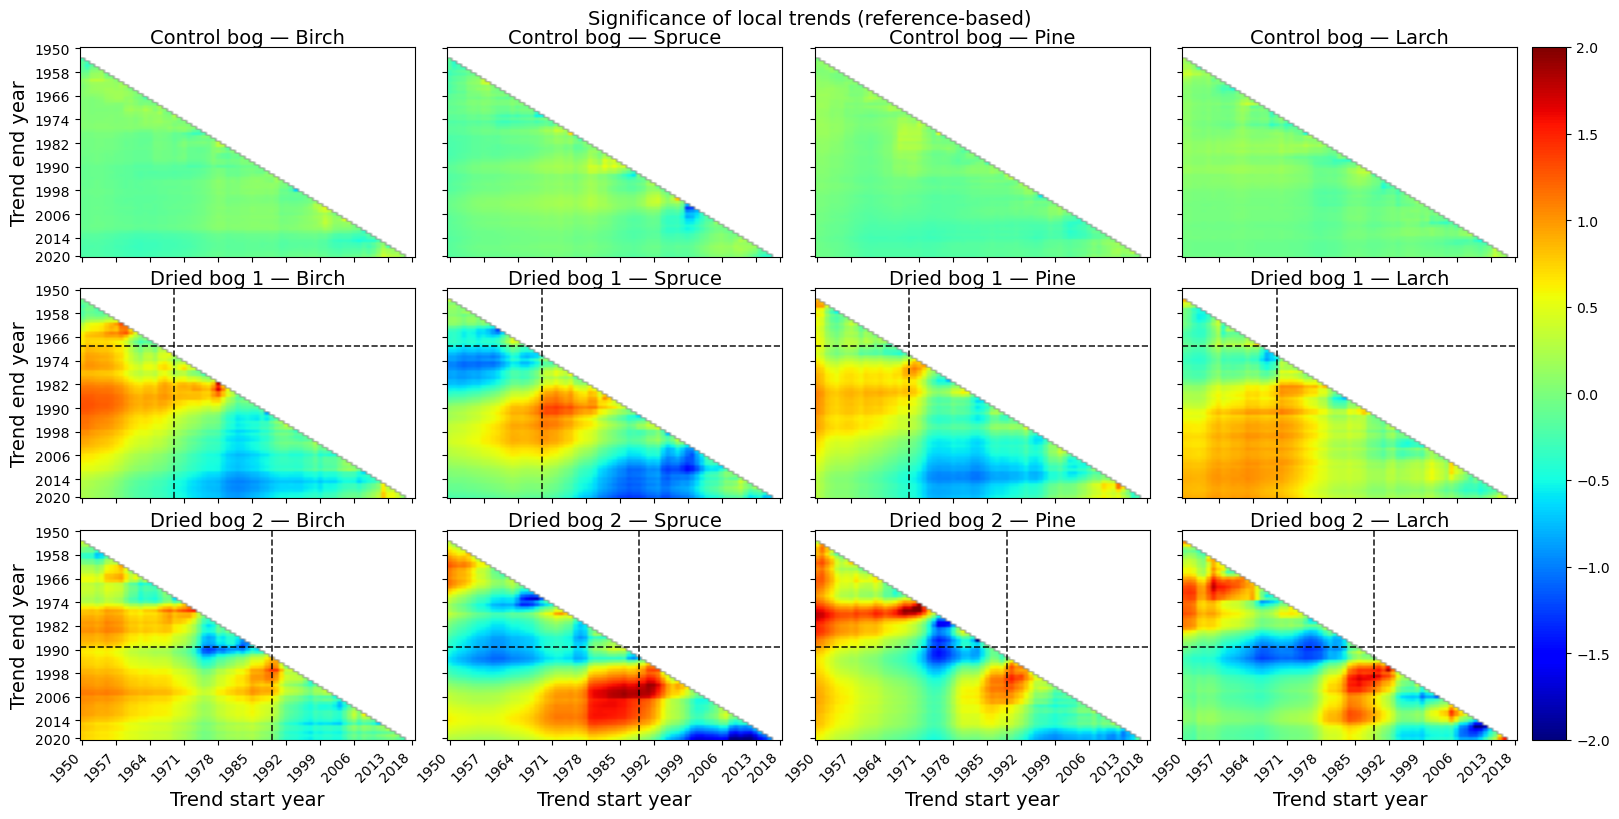

In [30]:
# (27) Heatmaps — significance of local trends (reference-based)
# --- INPUT:  X_trees_ref (Lw×F×N), X_norm_H1_std (Lw×F), dates, first_years, last_years, specium, location, spec_names, loc_names
# --- OUTPUT: Figure_12_BN.pdf
# Rationale:
#   Average Δ/σ over trees within each cohort and Z-score by the simulated scale map from B2.
#   Visualize Z-scores (end×start) with transparency where no data are available; annotate with human-readable years.
#   Add location-specific guide lines to relate significant windows to intervention timing.

fi_pos = fi_pos_view if fi_pos_view.size else np.arange(len(first_years))
li_pos = li_pos_view if li_pos_view.size else np.arange(len(last_years))

Lw, F, _ = X_trees_ref.shape
fig, axes = plt.subplots(len(U_LOC), len(SPEC_IDS), figsize=(16, 8),sharex=True, sharey=True, constrained_layout=True, squeeze=False)
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0, hspace=0.02)

for ri, loc_id in enumerate(U_LOC):
    for ci, sp in enumerate(SPEC_IDS):
        ax = axes[ri, ci]
        sel = (location == loc_id) & (specium == sp)
        if not np.any(sel):
            ax.axis('off'); continue

        Z_mean_full = nanmean_axis_safe(X_trees_ref[:, :, sel], axis=2)
        cnt_full    = np.isfinite(X_trees_ref[:, :, sel]).sum(axis=2)

        Z_mean = Z_mean_full[li_pos][:, fi_pos]
        cnt    = cnt_full   [li_pos][:, fi_pos]
        scale  = X_norm_H1_std[li_pos][:, fi_pos]

        with np.errstate(divide='ignore', invalid='ignore'):
            Z = Z_mean / scale

        alpha = (cnt > 0) & np.isfinite(Z)
        im = ax.imshow(Z, origin='upper', aspect='auto', cmap='jet', vmin=-2, vmax=2)
        im.set_alpha(alpha.astype(float))

        _heatmap_ticks(ax, dates, first_years, last_years, fi_pos, li_pos, max_labels=10)
        title = f"{loc_names[loc_id-1]} — {spec_names[sp-1]}" if (sp-1) < len(spec_names) else f"{loc_names[loc_id-1]} — Species {sp}"
        ax.set_title(title, pad=2, fontsize=14)
        if ci == 0:
            ax.set_ylabel("Trend end year", fontsize=14)
        if ri == len(U_LOC) - 1:
            ax.set_xlabel("Trend start year", fontsize=14)

        _mark_heatmap_years_by_loc(ax, dates, first_years, last_years, fi_pos, li_pos, loc_id)
        # fig.colorbar(im, ax=ax, pad=0.01, fraction=0.035)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                    pad=0.01, fraction=0.025,
                    location="right")

fig.suptitle('Significance of local trends (reference-based)', fontsize=14)
if SAVE_OUTPUTS:
    fig.savefig(RESULTS / "Figure_12_BN.pdf", format="pdf")
plt.show()

# [DIAG]
# for ri, loc_id in enumerate(U_LOC):
#     for ci, sp in enumerate(SPEC_IDS):
#         sel = (location == loc_id) & (specium == sp)
#         if not np.any(sel): continue
#         Z_mean_full = nanmean_axis_safe(X_trees_ref[:, :, sel], axis=2)
#         Z = Z_mean_full[li_pos][:, fi_pos] / X_norm_H1_std[li_pos][:, fi_pos]
#         vals = Z[np.isfinite(Z)]
#         if vals.size:
#             p5, p50, p95 = np.percentile(vals, [5, 50, 95])
#             print(f"[DIAG] loc={loc_id} spec={sp}: nTrees={sel.sum()}, "
#                   f"valid={100*vals.size/Z.size:.1f}%, Z: p5={p5:.3f}, med={p50:.3f}, p95={p95:.3f}")
#         else:
#             print(f"[DIAG] loc={loc_id} spec={sp}: nTrees={sel.sum()}, no valid Z")


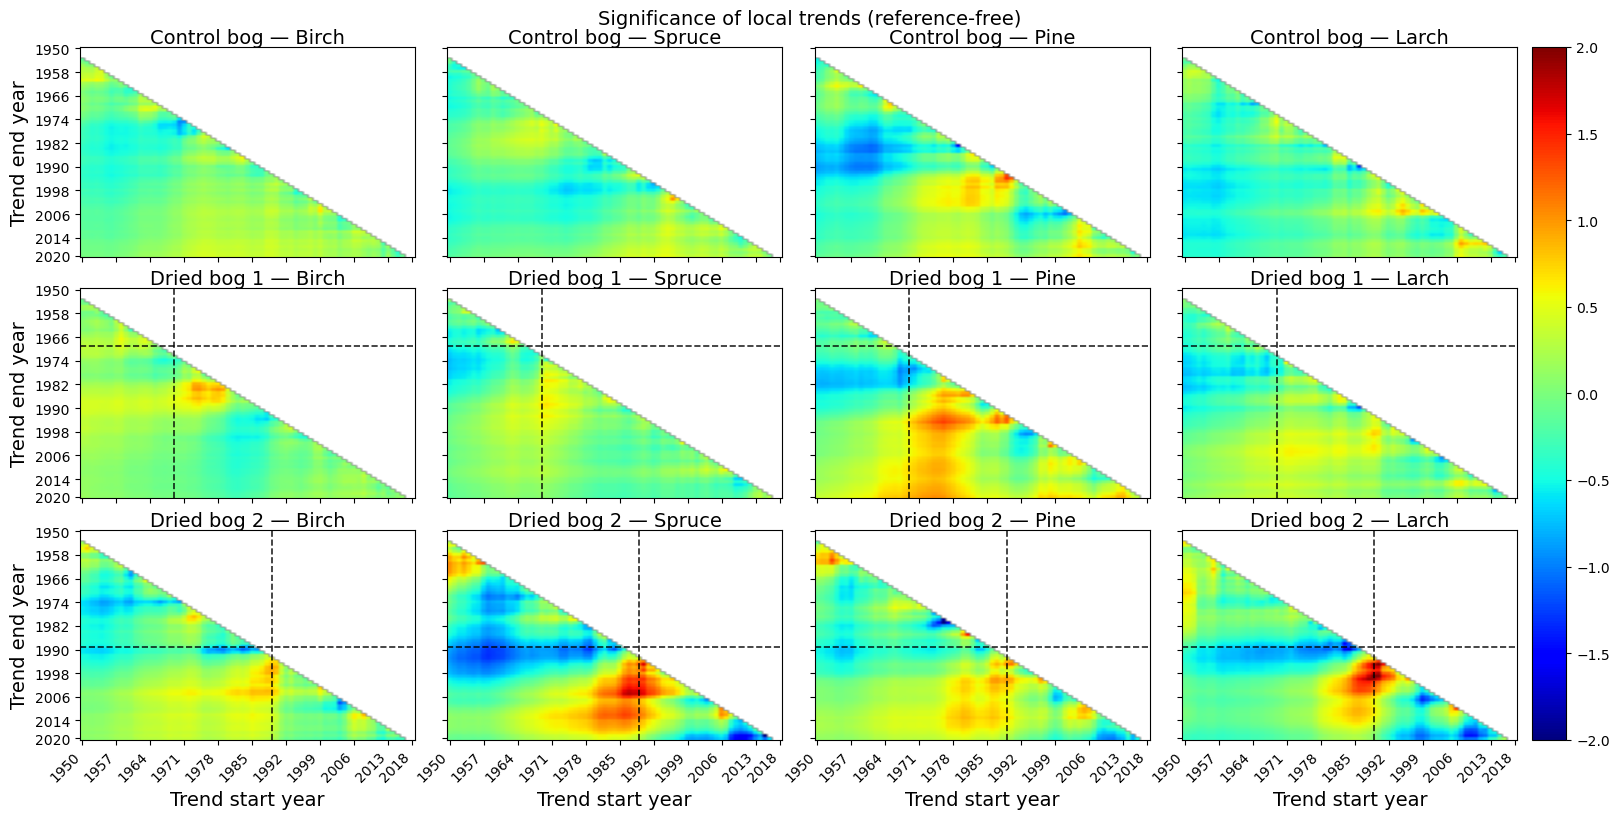

In [31]:
# (28) Heatmaps — significance of local trends (reference-free)
# --- INPUT:  X_trees_nov (Lw×F×N), X_norm_H1_std (Lw×F), dates, first_years, last_years, specium, location, spec_names, loc_names
# --- OUTPUT: Figure_13_BN.pdf
# Rationale:
#   Mirror 26 for the reference-free series; keep identical slicing, color scale limits, and annotations.
#   Enable direct visual comparison of where both approaches agree/disagree on local trend significance.

fi_pos = fi_pos_view if fi_pos_view.size else np.arange(len(first_years))
li_pos = li_pos_view if li_pos_view.size else np.arange(len(last_years))

Lw, F, _ = X_trees_nov.shape
fig, axes = plt.subplots(len(U_LOC), len(SPEC_IDS), figsize=(16, 8),sharex=True, sharey=True, constrained_layout=True, squeeze=False)
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0, hspace=0.02)

for ri, loc_id in enumerate(U_LOC):
    for ci, sp in enumerate(SPEC_IDS):
        ax = axes[ri, ci]
        sel = (location == loc_id) & (specium == sp)
        if not np.any(sel):
            ax.axis('off'); continue

        Z_mean_full = nanmean_axis_safe(X_trees_nov[:, :, sel], axis=2)
        cnt_full    = np.isfinite(X_trees_nov[:, :, sel]).sum(axis=2)

        Z_mean = Z_mean_full[li_pos][:, fi_pos]
        cnt    = cnt_full   [li_pos][:, fi_pos]
        scale  = X_norm_H1_std[li_pos][:, fi_pos]

        with np.errstate(divide='ignore', invalid='ignore'):
            Z = Z_mean / scale

        alpha = (cnt > 0) & np.isfinite(Z)
        im = ax.imshow(Z, origin='upper', aspect='auto', cmap='jet', vmin=-2, vmax=2)
        im.set_alpha(alpha.astype(float))

        _heatmap_ticks(ax, dates, first_years, last_years, fi_pos, li_pos, max_labels=10)
        title = f"{loc_names[loc_id-1]} — {spec_names[sp-1]}" if (sp-1) < len(spec_names) else f"{loc_names[loc_id-1]} — Species {sp}"
        ax.set_title(title, pad=2, fontsize=14)
        if ci == 0:
            ax.set_ylabel("Trend end year", fontsize=14)
        if ri == len(U_LOC) - 1:
            ax.set_xlabel("Trend start year", fontsize=14)

        _mark_heatmap_years_by_loc(ax, dates, first_years, last_years, fi_pos, li_pos, loc_id)
        # fig.colorbar(im, ax=ax, pad=0.01, fraction=0.035)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                    pad=0.01, fraction=0.025,
                    location="right")

fig.suptitle('Significance of local trends (reference-free)', fontsize=14)
if SAVE_OUTPUTS:
    fig.savefig(RESULTS / "Figure_13_BN.pdf", format="pdf")
plt.show()

# [DIAG]
# for ri, loc_id in enumerate(U_LOC):
#     for ci, sp in enumerate(SPEC_IDS):
#         sel = (location == loc_id) & (specium == sp)
#         if not np.any(sel): continue
#         Z_mean_full = nanmean_axis_safe(X_trees_nov[:, :, sel], axis=2)
#         Z = Z_mean_full[li_pos][:, fi_pos] / X_norm_H1_std[li_pos][:, fi_pos]
#         vals = Z[np.isfinite(Z)]
#         if vals.size:
#             p5, p50, p95 = np.percentile(vals, [5, 50, 95])
#             print(f"[DIAG] loc={loc_id} spec={sp}: nTrees={sel.sum()}, "
#                   f"valid={100*vals.size/Z.size:.1f}%, Z: p5={p5:.3f}, med={p50:.3f}, p95={p95:.3f}")
#         else:
#             print(f"[DIAG] loc={loc_id} spec={sp}: nTrees={sel.sum()}, no valid Z")


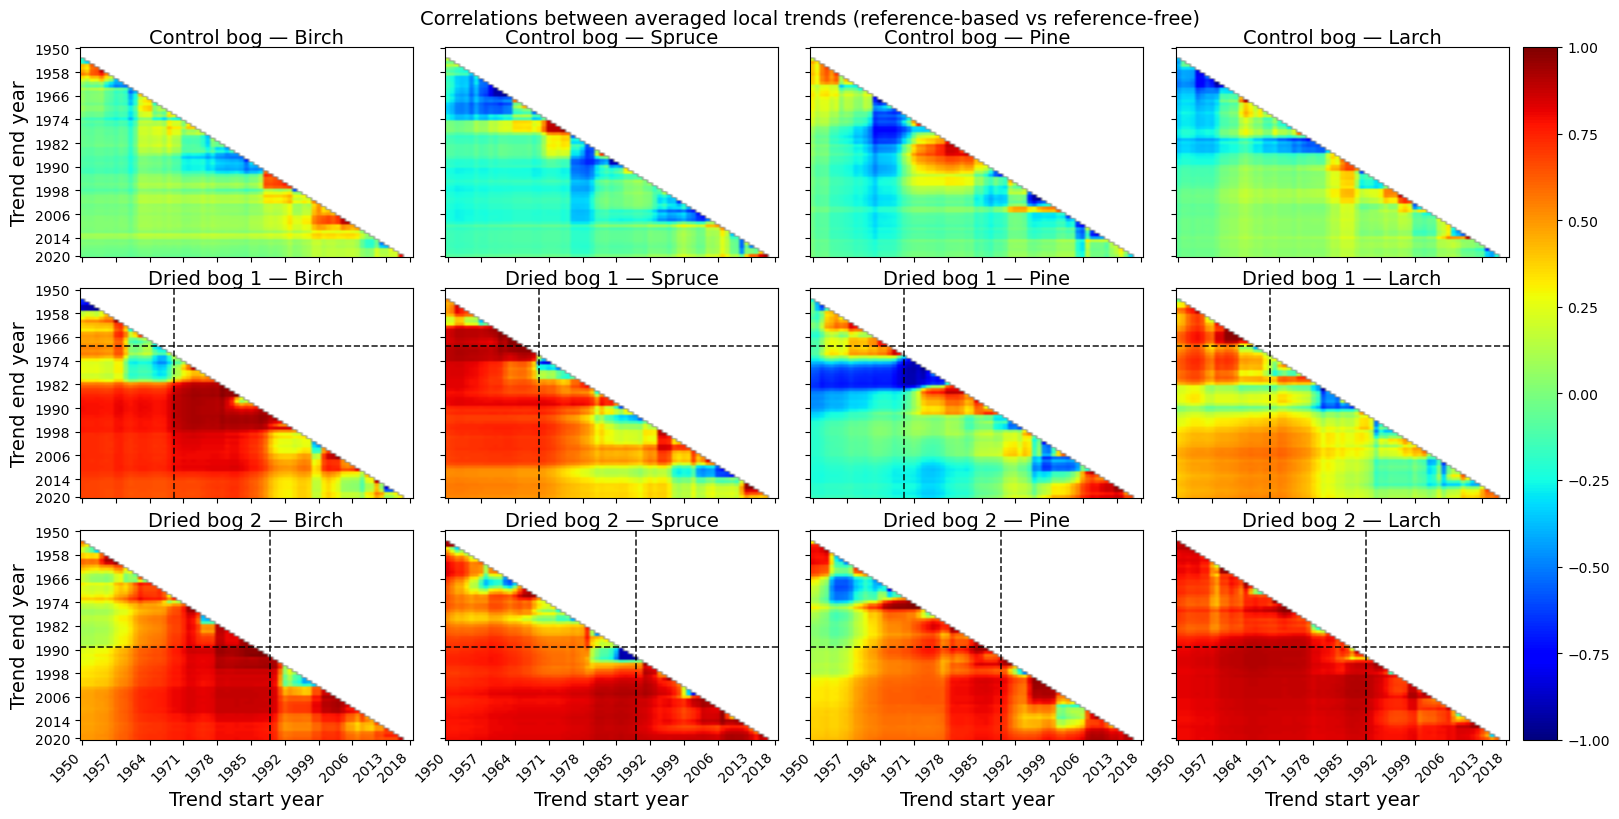

In [32]:
# (29) Correlations between averaged local trends (reference-based vs reference-free)
# --- INPUT:  C_trees_aver (Lw×F×|S|×|Loc|), dates, first_years, last_years, specium, location, spec_names, loc_names
# --- OUTPUT: Figure_14_BN.pdf
# Rationale:
#   Display window-wise correlations between cohort-averaged local trends from the two approaches.
#   Use a symmetric color scale (−1..1) and clip the viewed domain to PLOT_YEARS for consistent interpretation.
#   Save both the figure and the full correlation cube for downstream meta-analysis.

fi_pos = fi_pos_view if fi_pos_view.size else np.arange(len(first_years))
li_pos = li_pos_view if li_pos_view.size else np.arange(len(last_years))

Lw, F, S, Lc = C_trees_aver.shape
fig, axes = plt.subplots(len(U_LOC), len(SPEC_IDS), figsize=(16, 8),sharex=True, sharey=True, constrained_layout=True, squeeze=False)
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0, hspace=0.02)

for ri, loc_id in enumerate(U_LOC):
    for ci, sp in enumerate(SPEC_IDS):
        ax = axes[ri, ci]
        M_full = C_trees_aver[:, :, ci, ri]
        M = M_full[li_pos][:, fi_pos]
        if np.isfinite(M).any():
            im = ax.imshow(M, origin='upper', aspect='auto', cmap='jet', vmin=-1, vmax=1)
            im.set_alpha(np.isfinite(M).astype(float))

            _heatmap_ticks(ax, dates, first_years, last_years, fi_pos, li_pos, max_labels=10)
            title = f"{loc_names[loc_id-1]} — {spec_names[sp-1]}" if (sp-1) < len(spec_names) else f"{loc_names[loc_id-1]} — Species {sp}"
            ax.set_title(title, pad=2, fontsize=14)
            if ci == 0:
                ax.set_ylabel("Trend end year", fontsize=14)
            if ri == len(U_LOC) - 1:
                ax.set_xlabel("Trend start year", fontsize=14)

            _mark_heatmap_years_by_loc(ax, dates, first_years, last_years, fi_pos, li_pos, loc_id)
            # fig.colorbar(im, ax=ax, pad=0.01, fraction=0.035)
        else:
            ax.axis('off')

cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                    pad=0.01, fraction=0.025,
                    location="right")

fig.suptitle("Correlations between averaged local trends (reference-based vs reference-free)", fontsize=14)
if SAVE_OUTPUTS:
    fig.savefig(RESULTS / "Figure_14_BN.pdf", format="pdf")
plt.show()

# [DIAG]
# for ri, loc_id in enumerate(U_LOC):
#     for ci, sp in enumerate(SPEC_IDS):
#         M = C_trees_aver[:, :, ci, ri][li_pos][:, fi_pos]
#         vals = M[np.isfinite(M)]
#         if vals.size:
#             p5, p50, p95 = np.percentile(vals, [5, 50, 95])
#             print(f"[DIAG] loc={loc_id} spec={sp}: valid={100*vals.size/M.size:.1f}%, "
#                   f"C_aver: p5={p5:.3f}, med={p50:.3f}, p95={p95:.3f}")
#         else:
#             print(f"[DIAG] loc={loc_id} spec={sp}: no valid C_aver")


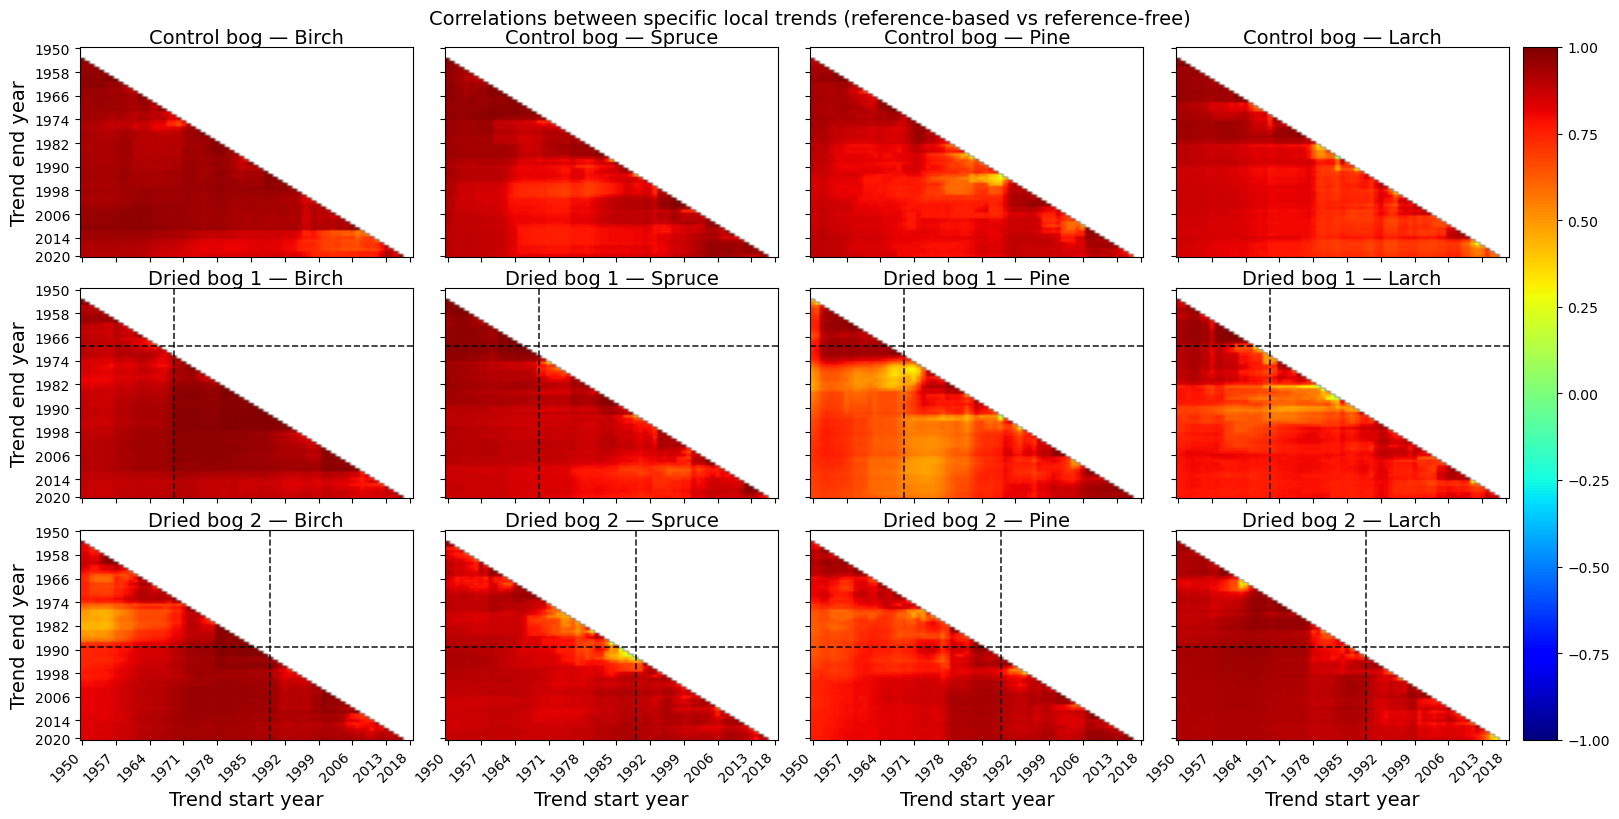

In [33]:
# (30) Correlations: specific (same-tree) local trends — styled view
# --- INPUT:  C_trees_spec (Lw×F×|S|×|Loc|), dates, first_years, last_years, specium, location, spec_names, loc_names
# --- OUTPUT: Figure_15_BN.pdf
# Rationale:
#   Visualize diagonal (same-tree) correlations between reference-based and reference-free local trends.
#   Emphasize within-tree consistency across windows and species/locations; persist the tensor for auditing.

fi_pos = fi_pos_view if fi_pos_view.size else np.arange(len(first_years))
li_pos = li_pos_view if li_pos_view.size else np.arange(len(last_years))

Lw, F, S, Lc = C_trees_spec.shape
fig, axes = plt.subplots(len(U_LOC), len(SPEC_IDS), figsize=(16, 8),sharex=True, sharey=True, constrained_layout=True, squeeze=False)
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0, hspace=0.02)

for ri, loc_id in enumerate(U_LOC):
    for ci, sp in enumerate(SPEC_IDS):
        ax = axes[ri, ci]
        M_full = C_trees_spec[:, :, ci, ri]  # (Lw × F)
        M = M_full[li_pos][:, fi_pos]
        if np.isfinite(M).any():
            im = ax.imshow(M, origin='upper', aspect='auto', cmap='jet', vmin=-1, vmax=1)
            im.set_alpha(np.isfinite(M).astype(float))
            _heatmap_ticks(ax, dates, first_years, last_years, fi_pos, li_pos, max_labels=10)
            title = f"{loc_names[loc_id-1]} — {spec_names[sp-1]}" if (sp-1) < len(spec_names) else f"{loc_names[loc_id-1]} — Species {sp}"
            ax.set_title(title, pad=2, fontsize=14)
            if ci == 0:
                ax.set_ylabel("Trend end year", fontsize=14)
            if ri == len(U_LOC) - 1:
                ax.set_xlabel("Trend start year", fontsize=14)
            _mark_heatmap_years_by_loc(ax, dates, first_years, last_years, fi_pos, li_pos, loc_id)
            # fig.colorbar(im, ax=ax, pad=0.01, fraction=0.035)
        else:
            ax.axis('off')

cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                    pad=0.01, fraction=0.025,
                    location="right")

fig.suptitle("Correlations between specific local trends (reference-based vs reference-free)", fontsize=14)
if SAVE_OUTPUTS:
    fig.savefig(RESULTS / "Figure_15_BN.pdf", format="pdf")
plt.show()

# [DIAG]
# for ri, loc_id in enumerate(U_LOC):
#     for ci, sp in enumerate(SPEC_IDS):
#         M = C_trees_spec[:, :, ci, ri][li_pos][:, fi_pos]
#         vals = M[np.isfinite(M)]
#         if vals.size:
#             p5, p50, p95 = np.percentile(vals, [5, 50, 95])
#             print(f"[DIAG] loc={loc_id} spec={sp}: valid={100*vals.size/M.size:.1f}%, p5={p5:.3f}, med={p50:.3f}, p95={p95:.3f}")
#         else:
#             print(f"[DIAG] loc={loc_id} spec={sp}: no valid C_spec")


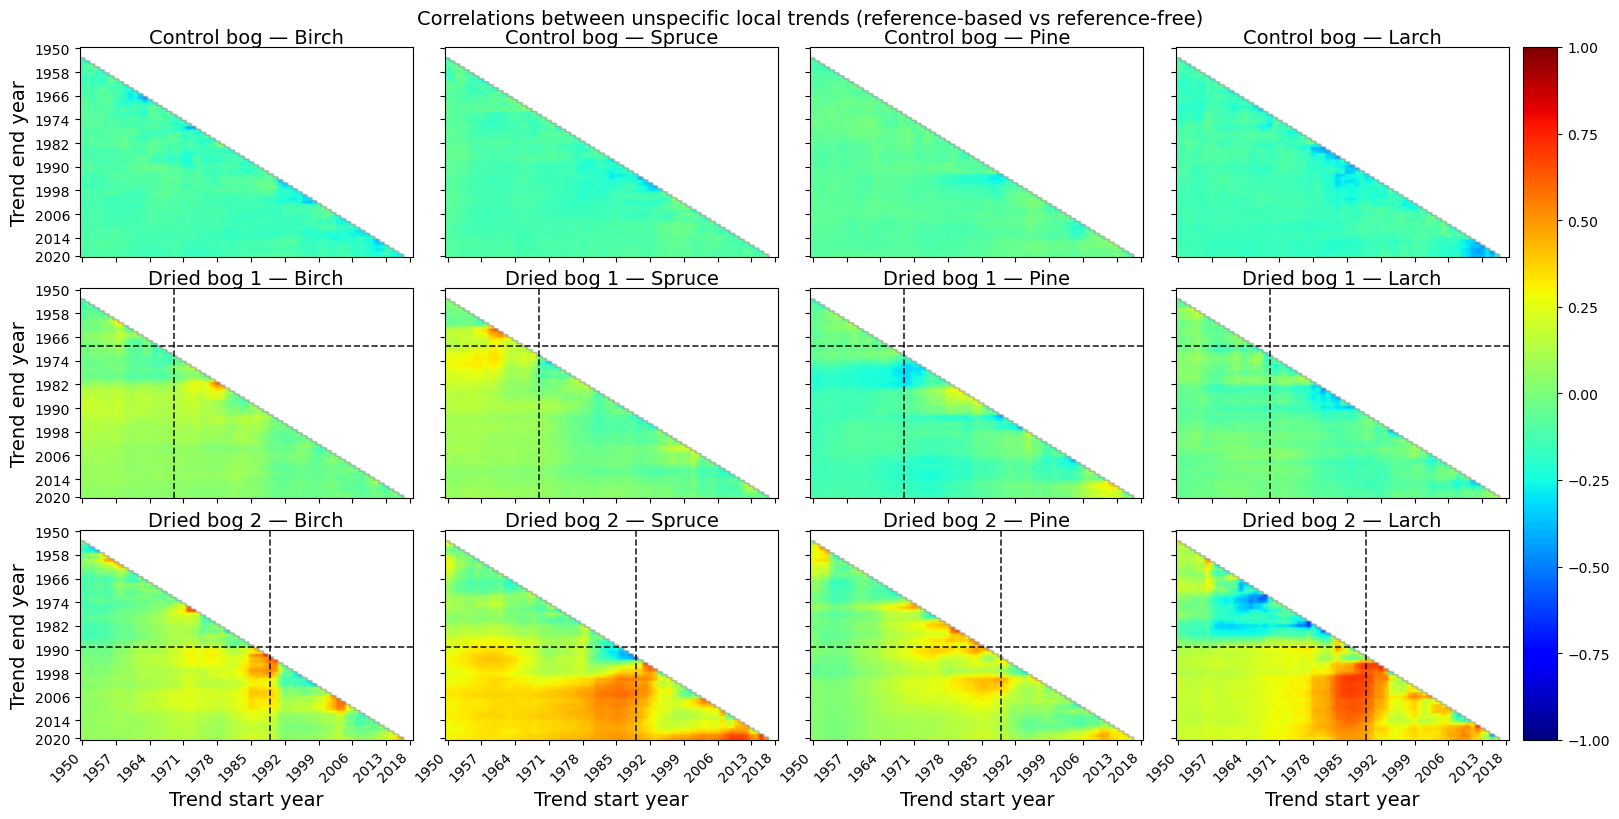

In [34]:
# (31) Correlations: unspecific (different-tree) local trends — styled view
# --- INPUT:  C_trees_unspec (Lw×F×|S|×|Loc|), dates, first_years, last_years, specium, location, spec_names, loc_names
# --- OUTPUT: Figure_16_BN.pdf
# Rationale:
#   Show off-diagonal (cross-tree) correlations to quantify non-specific agreement between approaches.
#   Compare with B7 to assess how much of the agreement is truly tree-specific vs cohort-level background.

fi_pos = fi_pos_view if fi_pos_view.size else np.arange(len(first_years))
li_pos = li_pos_view if li_pos_view.size else np.arange(len(last_years))

Lw, F, S, Lc = C_trees_unspec.shape
fig, axes = plt.subplots(len(U_LOC), len(SPEC_IDS), figsize=(16, 8),sharex=True, sharey=True, constrained_layout=True, squeeze=False)
fig.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0, hspace=0.02)

for ri, loc_id in enumerate(U_LOC):
    for ci, sp in enumerate(SPEC_IDS):
        ax = axes[ri, ci]
        M_full = C_trees_unspec[:, :, ci, ri]
        M = M_full[li_pos][:, fi_pos]
        if np.isfinite(M).any():
            im = ax.imshow(M, origin='upper', aspect='auto', cmap='jet', vmin=-1, vmax=1)
            im.set_alpha(np.isfinite(M).astype(float))
            _heatmap_ticks(ax, dates, first_years, last_years, fi_pos, li_pos, max_labels=10)
            title = f"{loc_names[loc_id-1]} — {spec_names[sp-1]}" if (sp-1) < len(spec_names) else f"{loc_names[loc_id-1]} — Species {sp}"
            ax.set_title(title, pad=2, fontsize=14)
            if ci == 0:
                ax.set_ylabel("Trend end year", fontsize=14)
            if ri == len(U_LOC) - 1:
                ax.set_xlabel("Trend start year", fontsize=14)
            _mark_heatmap_years_by_loc(ax, dates, first_years, last_years, fi_pos, li_pos, loc_id)
            # fig.colorbar(im, ax=ax, pad=0.01, fraction=0.035)
        else:
            ax.axis('off')

cbar = fig.colorbar(im, ax=axes.ravel().tolist(),
                    pad=0.01, fraction=0.025,
                    location="right")

fig.suptitle("Correlations between unspecific local trends (reference-based vs reference-free)", fontsize=14)
if SAVE_OUTPUTS:
    fig.savefig(RESULTS / "Figure_16_BN.pdf", format="pdf")
plt.show()

# [DIAG]
# for ri, loc_id in enumerate(U_LOC):
#     for ci, sp in enumerate(SPEC_IDS):
#         M = C_trees_unspec[:, :, ci, ri][li_pos][:, fi_pos]
#         vals = M[np.isfinite(M)]
#         if vals.size:
#             p5, p50, p95 = np.percentile(vals, [5, 50, 95])
#             print(f"[DIAG] loc={loc_id} spec={sp}: valid={100*vals.size/M.size:.1f}%, p5={p5:.3f}, med={p50:.3f}, p95={p95:.3f}")
#         else:
#             print(f"[DIAG] loc={loc_id} spec={sp}: no valid C_unspec")


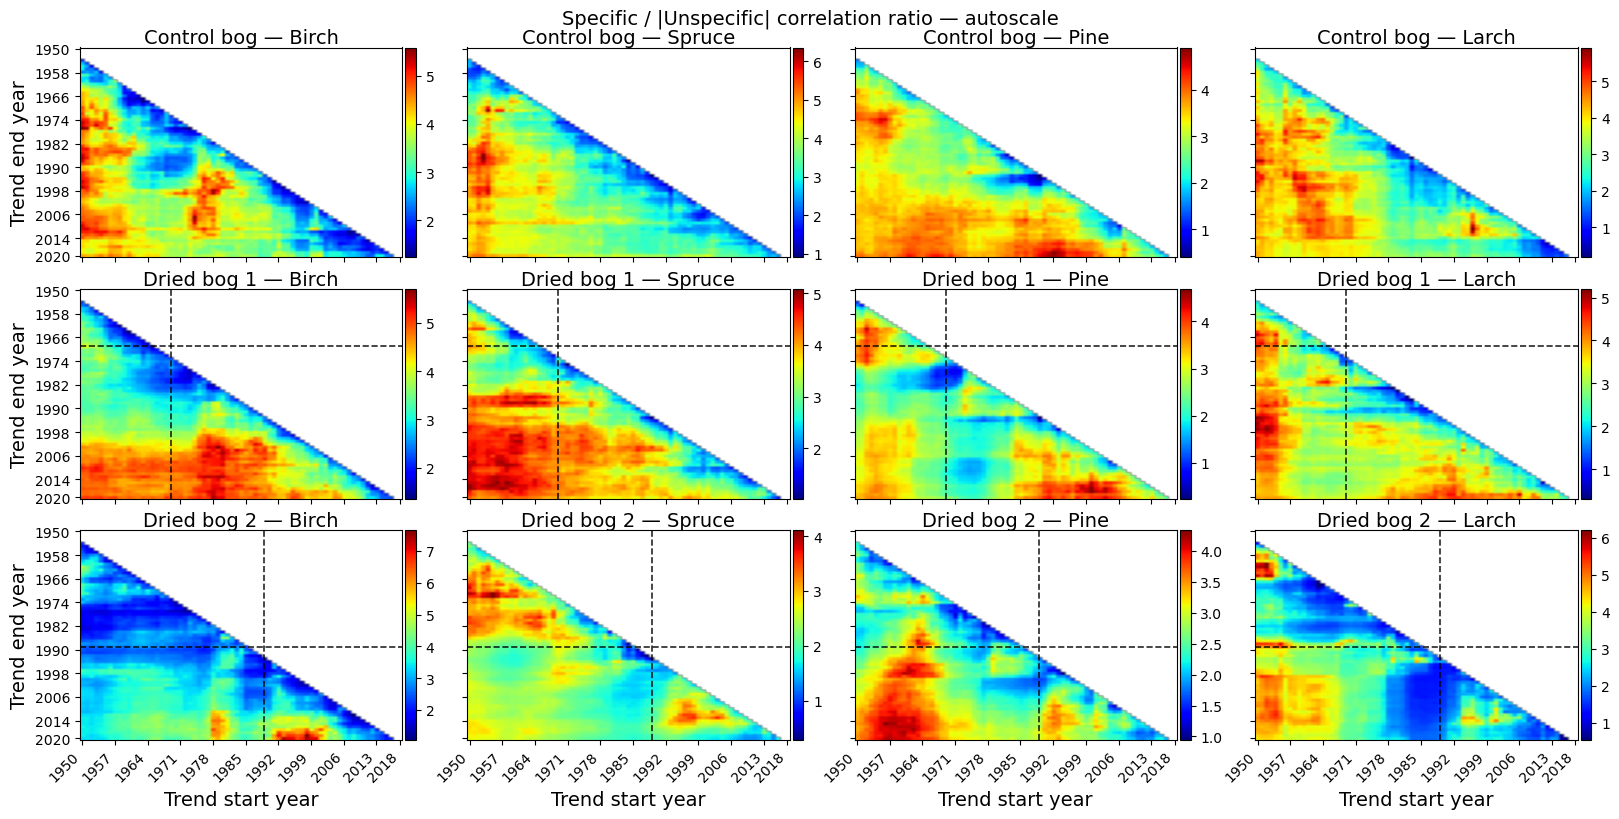

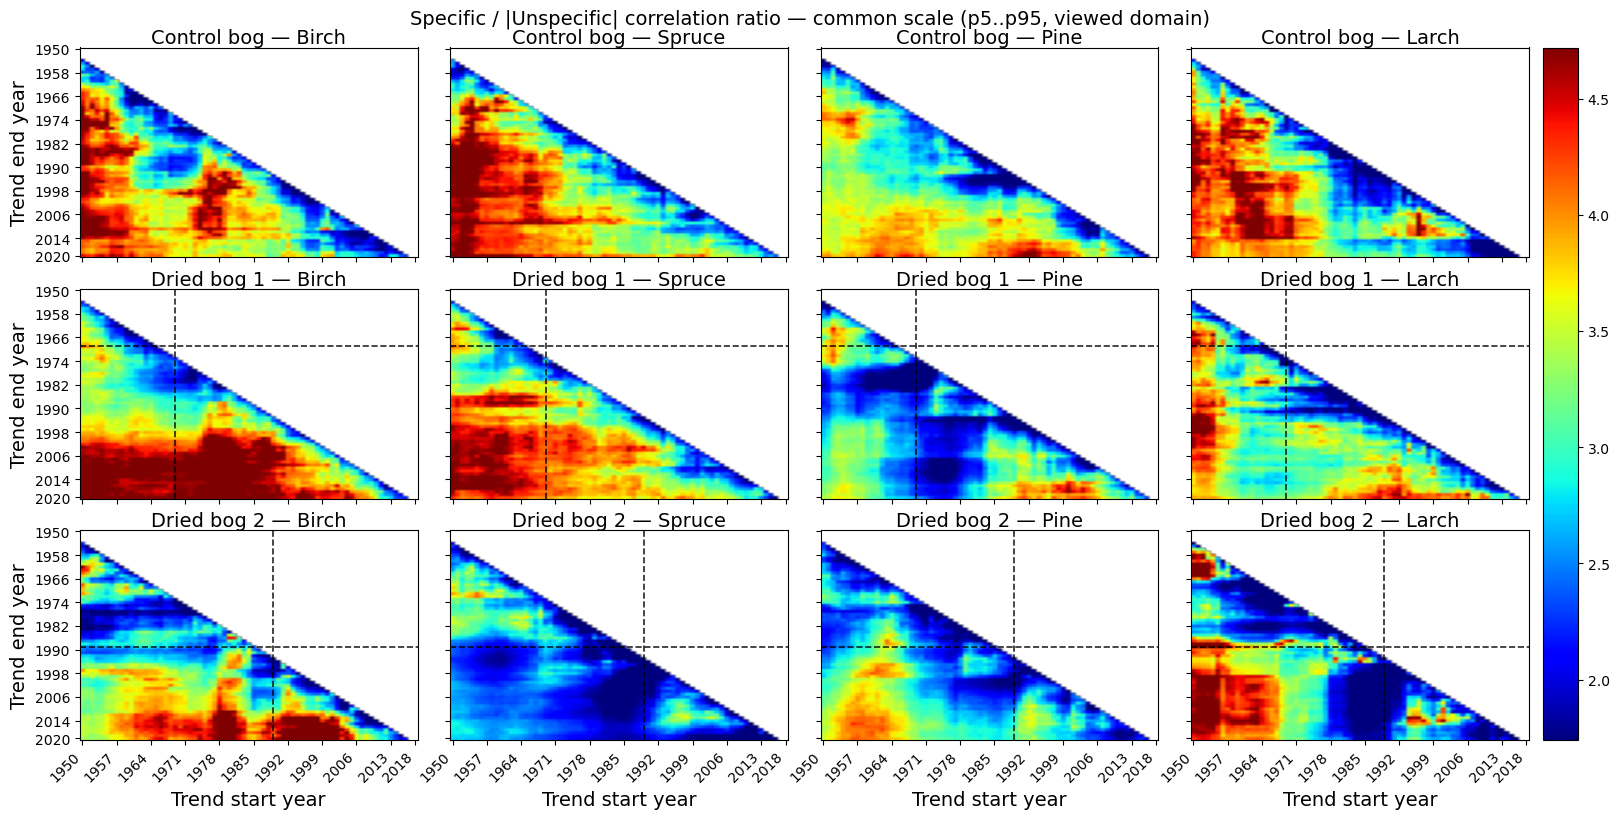

In [35]:
# (32) Ratio of specific to |unspecific| correlations — autoscale + common-scale panel
# --- INPUT:  C_trees_ratio (Lw×F×|S|×|Loc|), dates, first_years, last_years, specium, location, spec_names, loc_names
# --- OUTPUT: Figure_17_BN.pdf, Figure_17_BN_common.pdf
# Rationale:
#   Map the robustness ratio median(C_spec)/median(|C_unspec|) to highlight windows with specific agreement.
#   Provide two views: autoscaled per-panel and a common p5–p95 color scale across all panels for comparability.
#   Save the ratio tensor and both figures for publication-ready reporting.

fi_pos = fi_pos_view if fi_pos_view.size else np.arange(len(first_years))
li_pos = li_pos_view if li_pos_view.size else np.arange(len(last_years))

Lw, F, S, Lc = C_trees_ratio.shape

# --- Figure A: autoscale
figA, axesA = plt.subplots(len(U_LOC), len(SPEC_IDS), figsize=(16, 8),sharex=True, sharey=True, constrained_layout=True, squeeze=False)
figA.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0, hspace=0.02)

for ri, loc_id in enumerate(U_LOC):
    for ci, sp in enumerate(SPEC_IDS):
        ax = axesA[ri, ci]
        M_full = C_trees_ratio[:, :, ci, ri]
        M = M_full[li_pos][:, fi_pos]
        if np.isfinite(M).any():
            im = ax.imshow(M, origin='upper', aspect='auto', cmap='jet')  # autoscale
            im.set_alpha(np.isfinite(M).astype(float))
            _heatmap_ticks(ax, dates, first_years, last_years, fi_pos, li_pos, max_labels=10)
            title = f"{loc_names[loc_id-1]} — {spec_names[sp-1]}" if (sp-1) < len(spec_names) else f"{loc_names[loc_id-1]} — Species {sp}"
            ax.set_title(title, pad=2, fontsize=14)
            if ci == 0:
                ax.set_ylabel("Trend end year", fontsize=14)
            if ri == len(U_LOC) - 1:
                ax.set_xlabel("Trend start year", fontsize=14)
            _mark_heatmap_years_by_loc(ax, dates, first_years, last_years, fi_pos, li_pos, loc_id)
            figA.colorbar(im, ax=ax, pad=0.01, fraction=0.035)
        else:
            ax.axis('off')

figA.suptitle("Specific / |Unspecific| correlation ratio — autoscale", fontsize=14)
if SAVE_OUTPUTS:
    figA.savefig(RESULTS / "Figure_17_BN.pdf", format="pdf")
plt.show()

# --- Figure B: common color scale (p5..p95 over the viewed domain)
vals_view = []
for ri, loc_id in enumerate(U_LOC):
    for ci, sp in enumerate(SPEC_IDS):
        Mv = C_trees_ratio[:, :, ci, ri][li_pos][:, fi_pos]
        if np.isfinite(Mv).any():
            vals_view.append(Mv[np.isfinite(Mv)])
vals_view = np.concatenate(vals_view) if vals_view else np.array([])

if vals_view.size:
    vmin = np.percentile(vals_view, 5)
    vmax = np.percentile(vals_view, 95)
else:
    vmin, vmax = -5.0, 5.0

figB, axesB = plt.subplots(len(U_LOC), len(SPEC_IDS), figsize=(16, 8),sharex=True, sharey=True, constrained_layout=True, squeeze=False)
figB.set_constrained_layout_pads(w_pad=0, h_pad=0, wspace=0, hspace=0.02)

for ri, loc_id in enumerate(U_LOC):
    for ci, sp in enumerate(SPEC_IDS):
        ax = axesB[ri, ci]
        M_full = C_trees_ratio[:, :, ci, ri]
        M = M_full[li_pos][:, fi_pos]
        if np.isfinite(M).any():
            im = ax.imshow(M, origin='upper', aspect='auto', cmap='jet', vmin=vmin, vmax=vmax)
            im.set_alpha(np.isfinite(M).astype(float))
            _heatmap_ticks(ax, dates, first_years, last_years, fi_pos, li_pos, max_labels=10)
            title = f"{loc_names[loc_id-1]} — {spec_names[sp-1]}" if (sp-1) < len(spec_names) else f"{loc_names[loc_id-1]} — Species {sp}"
            ax.set_title(title, pad=2, fontsize=14)
            if ci == 0:
                ax.set_ylabel("Trend end year", fontsize=14)
            if ri == len(U_LOC) - 1:
                ax.set_xlabel("Trend start year", fontsize=14)
            _mark_heatmap_years_by_loc(ax, dates, first_years, last_years, fi_pos, li_pos, loc_id)
            # figB.colorbar(im, ax=ax, pad=0.01, fraction=0.035)
        else:
            ax.axis('off')

cbar = figB.colorbar(im, ax=axesB.ravel().tolist(),
                    pad=0.01, fraction=0.025,
                    location="right")

figB.suptitle("Specific / |Unspecific| correlation ratio — common scale (p5..p95, viewed domain)", fontsize=14)
if SAVE_OUTPUTS:
    figB.savefig(RESULTS / "Figure_17_BN_common.pdf", format="pdf")
plt.show()

# [DIAG]
# if vals_view.size:
#     p5, p50, p95 = np.percentile(vals_view, [5, 50, 95])
#     print(f"[DIAG] ratio(view) overall: p5={p5:.3f}, med={p50:.3f}, p95={p95:.3f}, "
#           f"min={vals_view.min():.3f}, max={vals_view.max():.3f}")

# for ri, loc_id in enumerate(U_LOC):
#     for ci, sp in enumerate(SPEC_IDS):
#         Mv = C_trees_ratio[:, :, ci, ri][li_pos][:, fi_pos]
#         v = Mv[np.isfinite(Mv)]
#         if v.size:
#             p5, p50, p95 = np.percentile(v, [5, 50, 95])
#             print(f"[DIAG] loc={loc_id} spec={sp}: valid={100*v.size/Mv.size:.1f}%, "
#                   f"ratio(view): p5={p5:.3f}, med={p50:.3f}, p95={p95:.3f}")
#         else:
#             print(f"[DIAG] loc={loc_id} spec={sp}: no valid ratio")
